# [KTO]_final_analysis_v1_2211

In [1]:
# basic
import gc
import os
import sys
import warnings
warnings.filterwarnings(action='ignore') 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#--------------------#
# handling
#--------------------#
import math
import time
import random
import importlib
import xlsxwriter
import numpy as np
import pandas as pd
from collections import Counter
from datetime import datetime, timedelta
#--------------------#
# Vis
#--------------------#
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
## Vis for jupyter theme
from IPython.display import Image
from jupyterthemes import jtplot
jtplot.style(theme= 'grade3', context='notebook', ticks=True, grid=False) ## dark backgroud jupyter notebook theme
# plt.style.use(['seaborn-white']) ## dark background style ## white style : 'seaborn-white'
plt.style.use(['dark_background']) ## dark background style ## white style : 'seaborn-white'
## Vis for korean 
import matplotlib.font_manager as fm
font_location = '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf'
fprop = fm.FontProperties(fname=font_location)
font_name = fprop.get_name()
matplotlib.rc('font', family=font_name)

In [2]:
#--------------------#
# sphere package
#--------------------#
sys.path.append("/home/das_share/sphere_class/")
import SpherePackage
from SpherePackage import *
for pkg in [SpherePackage] :
    _ = importlib.reload(pkg)

#--------------------#
# kto package
#--------------------#
sys.path.append("../src/")
import kto_util
import kto_prep
import kto_config
import kto_anlaysis
import kto_drcard_weekly_report_custom
import SphereRelation
import relation_utils

from kto_drcard_weekly_report_custom import *
from kto_anlaysis import *
from kto_config import *
from kto_prep import *
from kto_util import *
from SphereRelation import *
from relation_utils import *

for pkg in [kto_config, kto_prep, kto_util, kto_anlaysis, kto_drcard_weekly_report_custom, SphereRelation, relation_utils] :
    _ = importlib.reload(pkg)

# 0. config

# 1.Data import

 - sample data

In [3]:
#------------------------------------------------#
# 1. log Data import
#------------------------------------------------#
# ## 1) origin
# df_app_log = DataImport.read_files(
#     input_path = INPUT_PATH + DATA_TYPE + APP_KEY, ##+ '/web/', 
#     today = today + timedelta(days = 1), 
#     dates = dates,
#     platform_total = True, reduce_memory = True, verbose = False)

# 2) pickle
# from return_pickle import * 
# # CheckDate.check_date_return_pickle(s_date = s_date, e_date=e_date)
# df_app_log = ReadFile.read_pickle(s_date= s_date, e_date= e_date)

# # make smaple 
# sample_rate = 0.2
# df_app_log_sample = df_app_log.sample(int(len(df_app_log) * sample_rate))

# # save to_pickle
# file_path = '/data/in/'
# file_nm = 'df_app_log_sample.pkl'
# df_app_log_sample.to_pickle(file_path + file_nm)

# --------------------------------#
# # import to sampel pickle data
# --------------------------------#
df_app_log = pd.read_pickle('/home/minkyung62/analysis_report/00_custom_analysis/kto_custom/data/sample_data/df_app_log_sample.pkl')

 - full data

In [4]:
# df_app_log.info(memory_usage = "deep")

# # remove unnecessary rows 
# df_app_log = df_app_log.drop(columns= ['seq', 'sphere_id', 'user_grade'])

# # remove unnecessary rows 
# LST_IMPORTANT_EVNET = [EVENT_APP_INSTALL, EVENT_CONTENT_DETAIL, EVENT_SUBSCRIBE, EVENT_DRCARD_APPLY_DONE] + LST_DRCARD_EVENTS
# df_app_log = df_app_log[
#     ~((df_app_log['duration'] <= 1000) &
#     (df_app_log['abs_events'].apply(lambda x : True if len(x) <= 3 else False)) &
#     (df_app_log['abs_events'].apply(lambda x : True if len(set(x) & set(LST_IMPORTANT_EVNET)) == 0 else False)))
#     ]

# # downcasting loop
# for column in df_app_log:
#     if df_app_log[column].dtype == 'float64':
#         df_app_log[column]=pd.to_numeric(df_app_log[column], downcast='float')
#     if df_app_log[column].dtype == 'int64':
#         df_app_log[column]=pd.to_numeric(df_app_log[column], downcast='integer')
#     if column in [KEY_ID_DEVICE, KEY_ID_USER,'adid', 'gender', 'app_key']:
#         df_app_log[column]=df_app_log[column].astype('category')
# df_app_log.info(memory_usage = "deep")

# # save to_pickle
# file_path = '../data/in/'
# total_file_nm = 'df_app_log_total'
# for i in range(5) :
#     file_nm = f'{total_file_nm}_{i}.pkl'
#     df_app_log[int(len(df_app_log)/5*i):int(len(df_app_log)/5*(i+1))].to_pickle(file_path + file_nm)

# #--------------------------------#
# # # impprt full data pickle
# #--------------------------------#
# file_path = '../data/in/'
# total_file_nm = 'df_app_log_total'
# df_app_log_0 = pd.read_pickle(file_path + total_file_nm + '_0.pkl')
# df_app_log_1 = pd.read_pickle(file_path + total_file_nm + '_1.pkl')
# df_app_log_2 = pd.read_pickle(file_path + total_file_nm + '_2.pkl')
# df_app_log_3 = pd.read_pickle(file_path + total_file_nm + '_3.pkl')
# df_app_log_4 = pd.read_pickle(file_path + total_file_nm + '_4.pkl')

# df_app_log = pd.concat([
#     df_app_log_0,
#     df_app_log_1,
#     df_app_log_2,
#     df_app_log_3,
#     df_app_log_4
#     ])

# del df_app_log_0, df_app_log_1,df_app_log_2,df_app_log_3,df_app_log_4 
# gc.collect()

In [4]:
#------------------------#
# 0. import app install Data  
#------------------------#
# make app install obj
app_pipe_obj = AppInstallPipe(INPUT_PATH_INSTALL, APP_KEY)

#------------------------#
# 1. import extra campaign Data  
#------------------------#
campaign_file_path =\
    '/home/minkyung62/analysis_report/00_custom_analysis/kto_custom/data/sample_data/campaign_list_final/'
lst_campaign_query = ['여행가는 달', '설치', '디지털주민증', '원더티켓', '여행콕콕', '구독']
df_campaign = KtoPrep.kto_campaign_import(campaign_file_path)
df_campaign = KtoPrep.kto_campaign_prep(df_campaign, lst_campaign_query = lst_campaign_query)
df_campaign_survey = KtoPrep.kto_survey_prep(df_campaign, survey_col_nm = 'survey.questions')


#------------------------#
# 2. import extra data (drcard)
#------------------------#
ABSOLUTE_INPUT_PATH =\
    '/home/minkyung62/analysis_report/00_custom_analysis/kto_custom/data/sample_data/앱(App) 유입.20221001_20221004-혜택명칭 체크_수정.xlsx'
store_file_sheet_nm = '배너 INDEX'
df_store_file = pd.read_excel(ABSOLUTE_INPUT_PATH, sheet_name=store_file_sheet_nm, engine='openpyxl') 
df_store_file = df_store_file.rename(columns = {'QR 순번' : PARAM_QR_STORE_CODE})
df_store_file.head(10)

target latest file :  kto_android_20220801_20221123.json


,지역,params_qrStoreCode,장소명
0,평창,pc01,스페이스 창공
1,평창,pc02,평창군(관광두레 전반)
2,평창,pc03,평창캠프닉
3,평창,pc04,오대산 힐링빌리지
4,평창,pc05,어름치마을
5,평창,pc06,방림별곡카페
6,평창,pc07,옐로우트리카페
7,평창,pc08,평창사랑
8,평창,pc09,너나드리
9,평창,pc10,대관령마켓


##### linebyline

In [57]:
# 1. kto_campaign_import
lst_campaign_data = [x for x in os.listdir(campaign_file_path) if 'campaign' in x]
df_campaign = pd.DataFrame()
for _file_path in  lst_campaign_data:
    ## 1) import json
    with open(campaign_file_path + '/' +  _file_path, 'r') as file:
        subscribe_data = json.load(file)
subscribe_data[0]

#     ## 2) conver json to datafraem
#     for i in range(len(subscribe_data)) :   
#         _target_campaign_nm = subscribe_data[i]['campaign_nm']
#         _target_campaign_data = subscribe_data[i]['target_list']
        
#         _df_campaign = pd.json_normalize(_target_campaign_data)
#         _df_campaign['campaign_nm'] = _target_campaign_nm
#         df_campaign = pd.concat([
#             df_campaign,_df_campaign
#         ])
# df_campaign = df_campaign.reset_index(drop = True)

{'campaign_nm': '[설문 3] 여행콕콕 핫플레이스 만족도 조사 - 9월 개편',
 'target_list': [{'uid': 'C-Her78Fl69vW5wTcHjEmw',
   'click_boolean': False,
   'click_date': None},
  {'uid': 'euOnShCJQsujR9BIWAkMwA',
   'click_boolean': False,
   'click_date': None},
  {'uid': 'Pd4ILMlQRZmkwTOpRHXtXQ',
   'click_boolean': False,
   'click_date': None},
  {'uid': 'uq9jryAZQue73HfSKFXjQg',
   'click_boolean': False,
   'click_date': None},
  {'uid': 'jbqC-tX2js9zZ3fDKALNiw',
   'click_boolean': False,
   'click_date': None},
  {'uid': 'Qt_4qsTVTmyOWq47PnG3fw',
   'click_boolean': False,
   'click_date': None},
  {'uid': 'eDiWq2nuT5SXLqGbaMjKXQ',
   'click_boolean': False,
   'click_date': None},
  {'uid': 'njCWktktAZVOwuM4zb0ZIQ',
   'click_boolean': False,
   'click_date': None},
  {'uid': 'ERuWeNQWsnEb5vjNKtu0kw',
   'click_boolean': False,
   'click_date': None},
  {'uid': 'MxxLwurUUhju3Xeb-zIBYw',
   'click_boolean': True,
   'click_date': '2022,10,07 21:12:27',
   'survey': {'questions': [{'question_order': 0

In [22]:
{x: [_lst for _lst in list(df_campaign.campaign_nm.unique()) if x in _lst] for x in lst_campaign_query}['여행콕콕']

['[설문 3] 여행콕콕 핫플레이스 만족도 조사 - 9월 개편',
 '[설문 2] 여행콕콕 AI추천 만족도 조사 (1분지연)',
 '[설문 2] 여행콕콕 핫플레이스 추천 만족도 조사 (노출 조건 조정)',
 '[설문 3] 여행콕콕 AI추천 만족도 조사 - 9월 개편 - 조건완화',
 '[설문 3] 여행콕콕 AI콕콕플래너 만족도 조사 - 10월 지연시간 단축',
 '[설문 3] 여행콕콕 AI콕콕플래너 만족도 조사 - 9월 개편',
 '[설문 2] 여행콕콕 핫플레이스 추천 만족도 조사',
 '[설문 3] 여행콕콕 AI추천 만족도 조사 - 9월 개편',
 '[설문 2] 여행콕콕 AI추천 만족도 조사',
 '[설문 2] 여행콕콕 핫플레이스 추천 만족도 조사 (2분지연)',
 '[설문 2] 여행콕콕 AI추천 만족도 조사 (노출 위치 조정)',
 '[설문 2] 여행콕콕 핫플레이스 추천 만족도 조사 (여행콕콕배너2회클릭)',
 '[설문 4] 여행콕콕 AI콕콕플래너 - 주관식 의견 수렴']

In [34]:
# 2. kto_campaign_prep
dict_cmapaign_lst = {
    x : [_lst for _lst in list(df_campaign.campaign_nm.unique()) if x in _lst] 
    for x in lst_campaign_query  
    }

lst_conditions = []
lst_answer = []
for _key, _value in dict_cmapaign_lst.items() :
    for _v in _value :
        ## ex) _v => '[설문 3] 여행콕콕 핫플레이스 만족도 조사 - 9월 개편'
        condition = (df_campaign['campaign_nm'] == _v)
        lst_conditions.append(condition)
        lst_answer.append(_key)
df_campaign['campaign_cate'] = np.select(lst_conditions, lst_answer)            ## campaign_cate에 lst_campaign_query에 어느 cate에 해당하는지 value 추가

In [35]:
lst_conditions 
lst_answer 

[0           True
 1           True
 2           True
 3           True
 4           True
            ...  
 1215495    False
 1215496    False
 1215497    False
 1215498    False
 1215499    False
 Name: campaign_nm, Length: 1215500, dtype: bool,
 0          False
 1          False
 2          False
 3          False
 4          False
            ...  
 1215495    False
 1215496    False
 1215497    False
 1215498    False
 1215499    False
 Name: campaign_nm, Length: 1215500, dtype: bool,
 0          False
 1          False
 2          False
 3          False
 4          False
            ...  
 1215495    False
 1215496    False
 1215497    False
 1215498    False
 1215499    False
 Name: campaign_nm, Length: 1215500, dtype: bool,
 0          False
 1          False
 2          False
 3          False
 4          False
            ...  
 1215495    False
 1215496    False
 1215497    False
 1215498    False
 1215499    False
 Name: campaign_nm, Length: 1215500, dtype: bool,
 0      

['여행가는 달',
 '여행가는 달',
 '설치',
 '설치',
 '설치',
 '설치',
 '설치',
 '설치',
 '설치',
 '설치',
 '설치',
 '설치',
 '설치',
 '설치',
 '설치',
 '설치',
 '설치',
 '설치',
 '설치',
 '디지털주민증',
 '디지털주민증',
 '디지털주민증',
 '디지털주민증',
 '디지털주민증',
 '디지털주민증',
 '디지털주민증',
 '디지털주민증',
 '디지털주민증',
 '디지털주민증',
 '디지털주민증',
 '디지털주민증',
 '디지털주민증',
 '디지털주민증',
 '디지털주민증',
 '디지털주민증',
 '디지털주민증',
 '원더티켓',
 '원더티켓',
 '원더티켓',
 '원더티켓',
 '원더티켓',
 '원더티켓',
 '원더티켓',
 '원더티켓',
 '여행콕콕',
 '여행콕콕',
 '여행콕콕',
 '여행콕콕',
 '여행콕콕',
 '여행콕콕',
 '여행콕콕',
 '여행콕콕',
 '여행콕콕',
 '여행콕콕',
 '여행콕콕',
 '여행콕콕',
 '여행콕콕',
 '구독',
 '구독',
 '구독',
 '구독',
 '구독',
 '구독',
 '구독',
 '구독',
 '구독',
 '구독',
 '구독',
 '구독',
 '구독',
 '구독',
 '구독',
 '구독',
 '구독',
 '구독',
 '구독',
 '구독',
 '구독',
 '구독',
 '구독']

In [13]:
# 3. kto_survey_prep
lst_for_df = []
for _, row in df_campaign.iterrows() :
    _row = row['survey.questions']
    lst_for_df.append(DataImport.flatten_json(_row))
df_survey_rst = pd.DataFrame(lst_for_df)
df_survey_rst = df_survey_rst.\
    rename(
        columns = {x : x.replace('_', '')  for x in df_survey_rst.columns}
        )
lst_for_df
df_survey_rst

# _df_campaign_survey = pd.concat(
#     [df_campaign,df_survey_rst], axis = 1
# ).dropna(axis = 1, how = 'all').drop(columns = 'survey.questions')

[{'_question_text': '방문 전에  "대한민국 구석구석"를 알고 계셨나요?',
  '_question_order': 0,
  '_reply_text': '아니오'},
 {'': nan},
 {'': nan},
 {'_question_text': '방문 전에  "대한민국 구석구석"를 알고 계셨나요?',
  '_question_order': 0,
  '_reply_text': '예'},
 {'': nan},
 {'': nan},
 {'': nan},
 {'': nan},
 {'': nan},
 {'': nan},
 {'': nan},
 {'_question_text': '방문 전에  "대한민국 구석구석"를 알고 계셨나요?',
  '_question_order': 0,
  '_reply_text': '아니오'},
 {'_question_text': '방문 전에  "대한민국 구석구석"를 알고 계셨나요?',
  '_question_order': 0,
  '_reply_text': '예'},
 {'': nan},
 {'': nan},
 {'': nan},
 {'': nan},
 {'_question_text': '방문 전에  "대한민국 구석구석"를 알고 계셨나요?',
  '_question_order': 0,
  '_reply_text': '예'},
 {'': nan},
 {'': nan},
 {'_question_text': '방문 전에  "대한민국 구석구석"를 알고 계셨나요?',
  '_question_order': 0,
  '_reply_text': '예'},
 {'': nan},
 {'': nan},
 {'': nan},
 {'': nan},
 {'_question_text': '방문 전에  "대한민국 구석구석"를 알고 계셨나요?',
  '_question_order': 0,
  '_reply_text': '예'},
 {'': nan},
 {'': nan},
 {'': nan},
 {'_question_text': '방문 전에  "대한민국 구석구석"

,questiontext,questionorder,replytext,
0,"방문 전에 ""대한민국 구석구석""를 알고 계셨나요?",0.0,아니오,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,"방문 전에 ""대한민국 구석구석""를 알고 계셨나요?",0.0,예,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
1215495,NaN,NaN,NaN,NaN
1215496,NaN,NaN,NaN,NaN
1215497,만족도를 별점으로 표시해주세요.😀,0.0,5,NaN
1215498,NaN,NaN,NaN,NaN


# 2.Preprocess

In [5]:
def import_prop_manul_data_ver_mk(file_path) :
    df_prop_manual = pd.read_excel(file_path, engine='openpyxl') 
    df_prop_manual = df_prop_manual.rename(
        columns = {
            [x for x in df_prop_manual.columns if '회원ID' in x][0] : KEY_ID_USER,
            [x for x in df_prop_manual.columns if '성별' in x][0] : 'gender',
            [x for x in df_prop_manual.columns if '생년' in x][0] : 'birth_y',
            [x for x in df_prop_manual.columns if '회원가입일시' in x][0] : 'created_date_user',
            }
        )
    lst_female_label = ['W', 'w', '여자', '여성', '여']
    lst_male_label = ['M', 'm', '남자', '남성', '남']
    df_prop_manual['gender'] =\
        df_prop_manual['gender'].apply(lambda x : 'f' if x in lst_female_label else 'm')

    return df_prop_manual

In [6]:
#------------------------------------------------#
# 1. prep
#------------------------------------------------#
## 1) log
df_app_log = SpherePrep.BasicPrep.basic_prep(df_app_log, month = True)
## +커스텀) user id에 ',Y'가 포함되어 있는 경우 이를 제거
df_app_log[KEY_ID_USER] = df_app_log[KEY_ID_USER].apply(
                            lambda x : KtoPrep.kto_user_id_prep(x)
                            )
    
# ## 2) param
# LST_MANUAL_EVENTS_MAIN = [
#     EVENT_CONTENT_DETAIL, EVENT_SEARCH,  # basic
#     EVENT_HOME_BANNER, EVENT_HOME_TOP_BANNER, # banner
#     EVENT_SafeTravel_Main, # 여행콕콕
#     EVENT_DRCARD_DEEPLINK, EVENT_DRCARD_APPLY_DONE, # 디지털 주민증
#     EVENT_PROMOTION_DETAIL, EVENT_PROMOTION_RESERVE, # 여행상품홍보관
#     ]
# _, df_param = DataImport.json_to_dataframe_nodeN(
#     df_app_log, [KEY_ID_DEVICE, KEY_ID_USER], type = 'manual',
#     lst_manual_events = LST_MANUAL_EVENTS_MAIN
#     )

## 3) user_prop
### (0) import manual prop data --------------->manual data<
manual_prop_file_path = '/home/minkyung62/analysis_report/00_custom_analysis/kto_custom/data/sample_data/KTO_user_prop_221108.xlsx'
df_prop_manual = import_prop_manul_data_ver_mk(manual_prop_file_path) 
df_app_log = pd.merge(
    left = df_app_log.drop(columns= ['gender', 'birth_y']),
    right = df_prop_manual[[KEY_ID_USER,'gender', 'birth_y']],
    on = KEY_ID_USER, how = 'left'
    )# ---------------------------------------- # 
### (1) make prop data
df_prop = SpherePrep.Prop.df_prop_pipe(
    df_app_log, KEY_ID = [KEY_ID_DEVICE, KEY_ID_USER],
    age_group_eml = False, drop_none_prop=False
    )
### (2) make additional age group
df_prop['age_group_large'] = np.select(
    [(df_prop['age'] < 40), (df_prop['age'] >= 40), df_prop['age'].isna()], 
    ['20_30', '40_50', None]
    )

## 4) "session" referr -- web 유입
lst_extrated_referr_cols = ['utm_campaign', 'utm_source', 'utm_medium']
df_app_log = SpherePrep.Attribution_Prep.gen_session_referr_cols(
    df_app_log, referr_col = 'referrer', 
    lst_extrated_referr_cols = lst_extrated_referr_cols,
    fill_na_organic = True
    )

## 5) "install" referr -- app 유입
df_app_log = SpherePrep.Attribution_Prep.refine_attribution_data(
        df_app_log, _REFERR_COL = 'install_referrer', atb_type = 'kochava',
        after_lookup_install = False)

In [7]:
#------------------------------------------------#
# 2. prep param detail data
#------------------------------------------------#
file_path = '../data/sample_data'
# df_param_contents = DataImport.extract_event_param(df_param, EVENT_CONTENT_DETAIL).drop_duplicates()
# df_param_search = DataImport.extract_event_param(df_param, EVENT_SEARCH).drop_duplicates()
# df_param_banner_top = DataImport.extract_event_param(df_param, EVENT_HOME_TOP_BANNER).drop_duplicates()
# df_param_banner_safeTravel = DataImport.extract_event_param(df_param, EVENT_HOME_BANNER).drop_duplicates()
# df_param_safeTravel = DataImport.extract_event_param(df_param, EVENT_SafeTravel_Main).drop_duplicates()
# df_param_drcard_qrscan = DataImport.extract_event_param(df_param, EVENT_DRCARD_DEEPLINK).drop_duplicates()
# df_param_drcard_apply = DataImport.extract_event_param(df_param, EVENT_DRCARD_APPLY_DONE).drop_duplicates()
# df_param_promotion_detail = DataImport.extract_event_param(df_param, EVENT_PROMOTION_DETAIL).drop_duplicates()
# df_param_promotion_reserve = DataImport.extract_event_param(df_param, EVENT_PROMOTION_RESERVE).drop_duplicates()

# # + param data prep
# df_param_contents = df_param_contents[~df_param_contents[PARAM_CONTENT_NAME].isna()]
# df_param_contents = df_param_contents.drop(columns = ['params_organization','params_sapContentCat1Id', 'params_sapContentFilter1', 'params_sapContentFilter2', 'params_sapContentFilter3', 'params_sapContentFilter3_'])

# # + contents
# df_param_safeTravel = df_param_safeTravel[~df_param_safeTravel[PARAM_SERVICE_TYPE].isna()]
# df_param_safeTravel[PARAM_SERVICE_TYPE] = df_param_safeTravel[PARAM_SERVICE_TYPE].apply(lambda x : '콕콕플래너' if x == 'ABC상점' else x)
# df_param_safeTravel['week'] = pd.to_datetime(df_param_safeTravel['date'], format='%Y%m%d %H:%M:%S').dt.week
# df_param_safeTravel['week'] = KtoPrep.convert_week_n_to_day(df_param_safeTravel['week'])
# # + drcard qrscan 
# df_param_drcard_qrscan[PARAM_QR_STORE_CODE] =\
#     df_param_drcard_qrscan[PARAM_QR_STORE_CODE].apply(lambda x : x.lower() if isinstance(x, str) else x)
# df_param_drcard_qrscan = pd.merge(
#     left = df_param_drcard_qrscan, right = df_store_file[[PARAM_QR_STORE_CODE, '지역', '장소명']],
#     how = 'left', on = PARAM_QR_STORE_CODE)
# df_param_drcard_qrscan = df_param_drcard_qrscan[~df_param_drcard_qrscan[PARAM_QR_STORE_CODE].isna()]
# df_param_drcard_qrscan = df_param_drcard_qrscan[df_param_drcard_qrscan[PARAM_QR_STORE_CODE] != 'intro']
# # + promotion(여행상품홍보관)
# df_param_promotion_reserve[PARAM_CONTENT_ID] =\
#     df_param_promotion_reserve[PARAM_CONTENT_ID].apply(lambda x : x[:x.find('\'')])
# df_param_promotion_reserve_prep = pd.merge(
#     left = df_param_promotion_reserve,
#     right= df_param_promotion_detail[[PARAM_CONTENT_ID, PARAM_CONTENT_NAME]].drop_duplicates().dropna(),
#     on = PARAM_CONTENT_ID, how = 'left'
#     )

# save_pkl
# df_param_contents.to_pickle(file_path + 'df_param_contents' + '.pkl')
# df_param_search.to_pickle(file_path + 'df_param_contents' + '.pkl')
# df_param_banner_top.to_pickle(file_path + 'df_param_banner_top' + '.pkl')
# df_param_banner_safeTravel.to_pickle(file_path + 'df_param_banner_safeTravel' + '.pkl')
# df_param_safeTravel.to_pickle(file_path + 'df_param_safeTravel' + '.pkl')
# df_param_drcard_qrscan.to_pickle(file_path + 'df_param_drcard_qrscan' + '.pkl')
# df_param_drcard_apply.to_pickle(file_path + 'df_param_drcard_apply' + '.pkl')
# df_param_promotion_detail.to_pickle(file_path + 'df_param_promotion_detail' + '.pkl')
# df_param_promotion_reserve.to_pickle(file_path + 'df_param_promotion_reserve' + '.pkl')

# read_pkl
df_param_contents = pd.read_pickle(file_path + '/df_param_contents' + '.pkl')
df_param_search = pd.read_pickle(file_path + '/df_param_search' + '.pkl')
df_param_banner_top = pd.read_pickle(file_path + '/df_param_banner_top' + '.pkl')
df_param_banner_safeTravel = pd.read_pickle(file_path + '/df_param_banner_safeTravel' + '.pkl')
df_param_safeTravel = pd.read_pickle(file_path + '/df_param_safeTravel' + '.pkl')
df_param_drcard_qrscan = pd.read_pickle(file_path + '/df_param_drcard_qrscan' + '.pkl')
df_param_drcard_apply = pd.read_pickle(file_path + '/df_param_drcard_apply' + '.pkl')
df_param_promotion_detail = pd.read_pickle(file_path + '/df_param_promotion_detail' + '.pkl')
df_param_promotion_reserve = pd.read_pickle(file_path + '/df_param_promotion_reserve' + '.pkl')


#------------------------------------------------#
# 3. prep survey data
#------------------------------------------------#
## safe travel
df_safetravel_survey_raw = df_campaign_survey[
    (df_campaign_survey['click_boolean']) &
    (df_campaign_survey['campaign_cate'] == '여행콕콕')
    ]
df_safetravel_survey_raw['campaign_cate'] = df_safetravel_survey_raw['campaign_nm'].apply(lambda x : KtoPrep.safetravel_campagin_categorizing(x))
df_safetravel_survey_raw['survey_type'] = df_safetravel_survey_raw['questiontext'].apply(lambda x : KtoPrep.safetravel_survey_type_categorizing(x))

df_safetravel_survey = df_safetravel_survey_raw.groupby(['campaign_nm','questiontext','replytext']).size().to_frame()
df_safetravel_survey = df_safetravel_survey.reset_index().rename(columns = {0 : 'cnt'})
df_safetravel_survey['campaign_cate'] = df_safetravel_survey['campaign_nm'].apply(lambda x : KtoPrep.safetravel_campagin_categorizing(x))
df_safetravel_survey['survey_type'] = df_safetravel_survey['questiontext'].apply(lambda x : KtoPrep.safetravel_survey_type_categorizing(x))
df_param_banner_safeTravel[PARAM_CONTENT_ID] = df_param_banner_safeTravel[PARAM_CONTENT_ID].apply(lambda x : x[:-1] if x[-1] == '\'' else x)

# 3.Analysis

## 0)Segment Setting
    - (1) referrer
    - (2) H/M/L seg by duration

In [8]:
#------------------------------------------------#
# 1. segment by referrer
#------------------------------------------------#
## seg by session referr 
dict_seg_from_referrs = KtoPrep.get_user_list_by_referr(
    df_app_log, KEY_ID = KEY_ID_DEVICE,
    DEPTH_1_COL = 'referrer_utm_campaign', 
    DEPTH_2_COL = 'referrer_utm_source') 
## seg by app install referr
dict_seg_from_install_referrs = KtoPrep.get_user_list_by_referr(
    df = df_app_log[df_app_log['install_referrer'] != 'organic'],
    KEY_ID = KEY_ID_DEVICE,
    DEPTH_1_COL = 'install_referrer', 
    DEPTH_2_COL = 'install_referrer_campaign') 

#------------------------------------------------#
# 2. segment by duration per device
#------------------------------------------------#
df_duration_per_device = df_app_log.groupby([KEY_ID_DEVICE])['duration'].sum()
dict_seg_duration = dict()
dict_seg_duration['high'] = df_duration_per_device[
    df_duration_per_device >= df_duration_per_device.quantile(0.9)].index
dict_seg_duration['middle'] = df_duration_per_device[
    (df_duration_per_device < df_duration_per_device.quantile(0.9)) &
    (df_duration_per_device >= df_duration_per_device.quantile(0.66))
    ].index
dict_seg_duration['low'] = df_duration_per_device[
    df_duration_per_device < df_duration_per_device.quantile(0.66)].index
lst_duration_over_10 = list(df_duration_per_device[df_duration_per_device >= 10].index)


#------------------------------------------------#
# 3. segment by new or re
#------------------------------------------------#
lst_new_device = list(df_app_log[df_app_log['created_date'] >= datetime.strptime(s_date, '%Y%m%d')][KEY_ID_DEVICE].unique())
lst_re_device = list(df_app_log[df_app_log['created_date'] < datetime.strptime(s_date, '%Y%m%d')][KEY_ID_DEVICE].unique())

#------------------------------------------------#
# 4. segment by fraud or total
#------------------------------------------------#
lst_fraud_device = list(df_app_log[df_app_log['duration'] <  5][KEY_ID_DEVICE].unique())
lst_total_device = list(df_app_log[KEY_ID_DEVICE].unique())
lst_total_user = list(df_app_log[KEY_ID_USER].unique())

#------------------------------------------------#
# 5. segment by demo (gender or age)
#------------------------------------------------#
## gender & age
dict_seg_age = dict()
dict_seg_gender = dict()
dict_seg_age['20_30'] = list(df_prop[df_prop['age'] < 40][KEY_ID_DEVICE])
dict_seg_age['40_50'] = list(df_prop[df_prop['age'] >= 40][KEY_ID_DEVICE])
dict_seg_gender['m'] = list(df_prop[df_prop['gender'] == 'm'][KEY_ID_DEVICE])
dict_seg_gender['f'] = list(df_prop[df_prop['gender'] == 'f'][KEY_ID_DEVICE])

#------------------------------------------------#
# 6. subscribe & app Install segment 
#------------------------------------------------#
## 1) total
lst_subscribe_device = list(df_app_log[
    df_app_log['abs_events'].apply(lambda x : True if EVENT_SUBSCRIBE in x else False)
    ][KEY_ID_DEVICE].unique())
lst_appinstall_device = list(df_app_log[
    df_app_log['abs_events'].apply(lambda x : True if EVENT_APP_INSTALL in x else False)
    ][KEY_ID_DEVICE].unique())
lst_appinstall_device_second_half = list(df_app_log[
    (df_app_log['date'] >= flag_date_app_sdk_installed) &
    (df_app_log['abs_events'].apply(lambda x : True if EVENT_APP_INSTALL in x else False))
    ][KEY_ID_DEVICE].unique())
## 2) monthly
dict_subscribe_by_monthly = KtoUtils.extract_event_segment_by_period(
    df_app_log, KEY_ID_DEVICE, target_event = EVENT_SUBSCRIBE, period = 'month')
dict_appinstall_by_monthly = KtoUtils.extract_event_segment_by_period(
    df_app_log, KEY_ID_DEVICE, target_event = EVENT_APP_INSTALL,  period = 'month')

#------------------------------------------------#
# 7. campagin segment 
#------------------------------------------------#
## device which click sth by each campaign
dict_seg_campaign_click_device = dict() 
for _cate in lst_campaign_query :
    _lst_click = list(
        df_campaign[
        (df_campaign['campaign_cate'] == _cate) &
        (df_campaign['click_boolean'] == True)
        ][KEY_ID_DEVICE].unique()
        )
    dict_seg_campaign_click_device[_cate] = _lst_click

#------------------------------------------------#
# 8. visit cnt segment (device)
#------------------------------------------------#
dict_seg_visit_cnt_device = {}
df_vivist_cnt = df_app_log.groupby([KEY_ID_DEVICE])['day'].nunique()
for _visit_cnt in [1,2,3] :
    if _visit_cnt == 1 :
        dict_seg_visit_cnt_device[_visit_cnt] = list((df_vivist_cnt[df_vivist_cnt == _visit_cnt]).index)
    else : 
        dict_seg_visit_cnt_device[_visit_cnt] = list((df_vivist_cnt[df_vivist_cnt >= _visit_cnt]).index)

## 1)주요 KPI 지표 성과 분석

### (1)Main KPI 

,total
total_active_device_cnt,8273698.00
total_active_user_cnt,71171.00
new_device_cnt,8091486.00
new_signUp_user_cnt,31056.00
new_subscribe_user_cnt,12227.00
new_appInstall_device_cnt,103752.00
avg_event_cnt_per_device,3.33
avg_duration_time_per_device,117.90
vip_device_cnt,827370.00
vip_device_rate,0.10


,5,6,7,8,9,10,11
total_active_device_cnt,436498.00,1446103.00,882324.00,1288663.00,1516833.00,1898522.00,1667571.00
total_active_user_cnt,4599.00,16152.00,11603.00,14452.00,14403.00,17098.00,30648.00
new_device_cnt,409493.00,1334214.00,780918.00,1156675.00,1343116.00,1614960.00,1323554.00
new_signUp_user_cnt,1765.00,6042.00,3196.00,4735.00,4631.00,8070.00,2439.00
new_subscribe_user_cnt,235.00,1908.00,1641.00,2852.00,1631.00,2089.00,1892.00
new_appInstall_device_cnt,1.00,0.00,25.00,24452.00,26663.00,30780.00,21853.00
avg_event_cnt_per_device,5.64,4.32,3.09,2.63,2.47,2.41,2.64
avg_duration_time_per_device,162.42,146.24,128.21,91.84,91.23,85.25,96.80
vip_device_cnt,73407.00,192889.00,95780.00,108946.00,132674.00,161888.00,138503.00
vip_device_rate,0.17,0.13,0.11,0.08,0.09,0.09,0.08


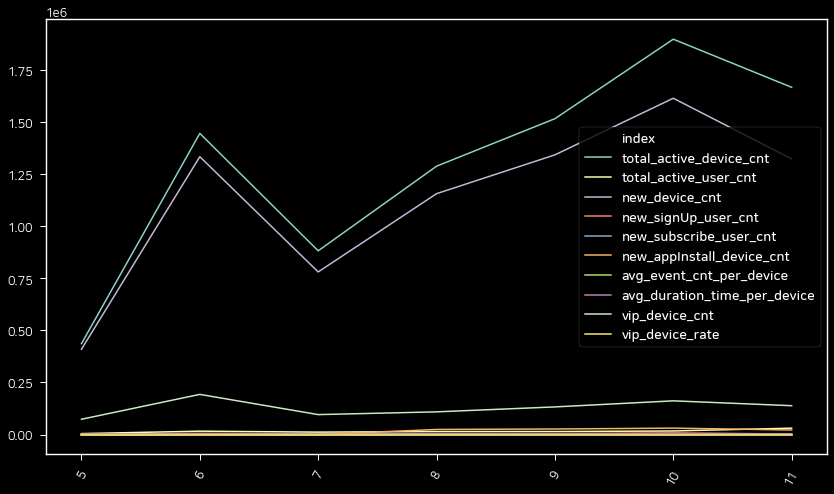

In [9]:
# make output
## 1) total kpi 
duration_time_high_10 = df_app_log.groupby(KEY_ID_DEVICE)['duration'].sum().quantile(0.9)
dict_output_kpi_total = KtoAnalysis.main_kpi_kto(df_app_log, df_prop_manual, duration_time_high_10)
df_output_kpi_total = pd.DataFrame.from_dict(
    dict_output_kpi_total, orient='index'
    ).rename(columns = {0 : 'total'})

## 2) monthly kpi total
df_output_kpi_monthly = pd.DataFrame()
for _m in df_app_log.month.unique() :
    _dict_output_kpi_montly = KtoAnalysis.main_kpi_kto(
        df_app_log[df_app_log['month'] == _m],
        df_prop_manual, 
        duration_time_high_10
        )
    _df_output_kpi_monthly = pd.DataFrame.from_dict(
        _dict_output_kpi_montly, orient='index'
        ).rename(columns = {0 : _m})
    
    df_output_kpi_monthly = pd.concat(
        [df_output_kpi_monthly,_df_output_kpi_monthly],
        axis = 1
    )

# print output
df_output_kpi_total.round(2)
df_output_kpi_monthly.round(2)

_df_vis = df_output_kpi_monthly.reset_index().melt(id_vars=['index']).round(2)
SphereVis.vis_line_longform(
    _df_vis, x = _df_vis['variable'], y = _df_vis['value'], hue = _df_vis['index']
    )

### (2) 재방문
    올해 중반까지 그렇게 큰 변화 없다가 최근 returning visitor 비율이 눈에 띄게 늘어남.
    실제로 returning visitor가 많이 증가한게 맞는지, 맞다면 cdp가 어느정도 기여를 했는지

1. 최근 실제 returning visitor가 늘어난게 맞는지.

2. returning visitor가 늘어났다면, CDP 기여분이 얼만큼 되며, 어떤 프로젝트가 가장 크게 기여했는지.
    1) CDP 기여분 측정
    [전체 재방문 유저중 '가볼래터'가입자 & 가볼래-터 가입자 중 '가볼래터' 구독 캠페인 클릭 유저]를 찾아내는 방법으로 간접적인 영향력 탐색

#### (a) returning

In [ ]:
## 1) 재방문 / 신규 유저 비율 추이 계산
standard_period = 'month'
df_returning_month = SphereRetention.returning_device_rate_main(
    df_app_log, vis = False, standard_period = standard_period)

In [ ]:
## 2) output_1
# for df_output, standard_period in zip([df_returning_month, df_returning_week], ['month', 'week_s_day']) : 
for df_output, standard_period in zip([df_returning_month], ['month']) : 
    vis, target_kpi = True, 're'
    if standard_period == 'week_s_day' :
        df_output = df_output[2:]
    df_output
    ## (3) vis
    if vis :
        _df_vis_long = pd.melt(
            df_output.reset_index()[[standard_period, 'new', 'returning']], 
            id_vars=standard_period
            )
        SphereVis.vis_line_longform(_df_vis_long, x = _df_vis_long[standard_period], y = 'value', hue = 'variable')
        _ = plt.title('new vs returning : {}'.format(standard_period.split('_')[0]), fontsize=20)
        plt.show()

        _df_vis = df_output
        _x = df_output.index
        if target_kpi == 're' : _y = df_output['returning_rate']
        elif target_kpi == 'new' : _y = df_output['new_rate']
        else : print('target kpi must be "new" or "re"')
        SphereVis.vis_line_longform(_df_vis, x = _x, y = _y)
        _ = plt.title('returning rate : {}'.format(standard_period.split('_')[0]), fontsize=20)
        _ = plt.axhline(y = round(_y.mean(), 4), color = 'r', linestyle = '-')
        plt.show()
        round(_y.mean(), 4)

#### (a-1) return reason & cdp 
    - CDP 기여 재방문 유저 그룹 정의 
    : 월별 재방문 유저 & 가볼래터 가입자 & 캠페인 클릭자 
    - 자연 재방문 유저 정의 
    : 월별 재방문 유저중, CDP 기여 재방문 유저 그룹을 제외한 나머지 유저 

In [ ]:
## 2) output_2
standard_period = 'month'
dict_re_device_by_month = KtoAnalysis.kpi_kto_returning_monthly(
    df_app_log, standard_period, dict_subscribe_by_monthly, dict_seg_campaign_click_device)

dict_output_tmp =dict()
for _month in dict_re_device_by_month.keys() :
    dict_output_tmp[_month] = dict()
   
    try : ratio_subsc_of_retrun = round(len(dict_re_device_by_month[_month]['lst_return_subscribe']) /\
        len(dict_re_device_by_month[_month]['lst_target_total'] ), 4)
    except ZeroDivisionError : ratio_subsc_of_retrun = 0
    try : ratio_campaign_of_retrun_subsc = round(
        len(dict_re_device_by_month[_month]['lst_return_subscribe_campagin']) /\
            len(dict_re_device_by_month[_month]['lst_return_subscribe']), 4)
    except ZeroDivisionError : ratio_campaign_of_retrun_subsc = 0
    
    # len(dict_re_device_by_month[_month]['lst_target_total'])
    # len(dict_re_device_by_month[_month]['lst_return_subscribe']), ratio_subsc_of_retrun
    # len(dict_re_device_by_month[_month]['lst_return_subscribe_campagin']), ratio_campaign_of_retrun_subsc
    
    dict_output_tmp[_month]['재방문자'] = int(len(dict_re_device_by_month[_month]['lst_target_total']))
    dict_output_tmp[_month]['재방문자 중 구독자 수'] = int(len(dict_re_device_by_month[_month]['lst_return_subscribe']))
    dict_output_tmp[_month]['재방문자 중 구독자 비율'] = round(ratio_subsc_of_retrun * 100, 4)
    dict_output_tmp[_month]['재방문자 중 CDP 캠페인을 통한 구독완료자 수'] = int(len(dict_re_device_by_month[_month]['lst_return_subscribe_campagin']))
    dict_output_tmp[_month]['재방문자 중 CDP 캠페인을 통한 구독완료자 비율'] = round(ratio_campaign_of_retrun_subsc * 100, 4)
    
    print('--------'*2)
    # dict_re_device_by_month[_month]['output_event'][3:].head(10)
    # dict_re_device_by_month[_month]['output_param'].head(10)
    # dict_re_device_by_month[_month]['output_referr'].head(10)
pd.DataFrame().from_dict(
    dict_output_tmp, orient = 'columns'
    )
pd.DataFrame().from_dict(
    dict_output_tmp, orient = 'columns'
    ).loc['재방문자 중 CDP 캠페인을 통한 구독완료자 비율', :].mean()

# 시각화 퍼널 추가

#### (b) retention

In [ ]:
# make output
df_retention_month = SphereRetention.retention_main(
    df_app_log.sample(int(len(df_app_log)*0.5)), KEY_ID = KEY_ID_DEVICE, period = 'month', vis = False)
df_retention_month.index = [int(float(x)) for x in df_retention_month.index]
# df_retention_month.index = df_retention_month.index.astype(str)
df_retention_week = SphereRetention.retention_main(
    df_app_log.sample(int(len(df_app_log)*0.5)), KEY_ID = KEY_ID_DEVICE, period = 'week', vis = False)
df_retention_week_fin = df_retention_week.iloc[2:]
df_retention_week_fin.index = KtoPrep.convert_week_n_to_day(df_retention_week_fin.index)
df_retention_month
df_retention_week

# print output
for _df_vis, _key in zip(
    [df_retention_month], #df_retention_week_fin, ],
    ['month'], #'week']
    ) :
    x = [int(float(x)) for x in df_retention_month.index] #_df_vis.index
    y = _df_vis[2] # 다음주차 방문 확률
    SphereVis.vis_line_longform(
        _df_vis, x = x, y = y
        )
    _ = plt.title(f'next [{_key}] Retention ', fontsize=24)
    _ = plt.axhline(y = round(_df_vis[2].mean(), 4), color = 'r', linestyle = '-')
    round(_df_vis[2].mean(), 4)

### (3) CDP 기여분
> Segment 정의
 - 2회 이상 방문 기기 : 2일 이상 방문 '디바이스'
 - 가볼래-터 가입 완료 기기 : 가볼래-터 가입 이벤트 완료 '디바이스' 
 - 캠페인 클릭 기기 : 캠페인 클릭 '디바이스' 

In [ ]:
# 1. CDP 기여분 탐색

VISIT_CNT = 3
## 1) 전체 2회 이상 방문 in 전체유저
lst_target_tmp_1 = dict_seg_visit_cnt_device[VISIT_CNT]
tuple_output_1 =\
    len(lst_target_tmp_1),\
    '전체 그룹',\
    len(lst_total_device),\
    round(len(lst_target_tmp_1) / len(lst_total_device) * 100, 2),\

## 2) 전체 2회 이상 방문 & 가볼래-터 가입자
lst_target_tmp_2 =\
    set(dict_seg_visit_cnt_device[VISIT_CNT]) &\
        set(lst_subscribe_device)
tuple_output_2 =\
    len(lst_target_tmp_2),\
    f'{VISIT_CNT}회 이상 방문',\
    len(lst_target_tmp_1),\
    round(len(lst_target_tmp_2) / len(lst_target_tmp_1) * 100, 2)

## 3) 전체 2회 이상 방문 & 가볼래-터 가입자 & CDP 캠페인 클릭 유저 
lst_target_tmp_3 =\
    set(dict_seg_visit_cnt_device[VISIT_CNT]) &\
        set(lst_subscribe_device) &\
            set(dict_seg_campaign_click_device['구독'])
tuple_output_3 =\
    len(lst_target_tmp_3),\
    f'{VISIT_CNT}회 이상 방문 & 가볼래-터_구독',\
    len(lst_target_tmp_2),\
    round(len(lst_target_tmp_3) / len(lst_target_tmp_2) * 100, 2)


df_output_tmp = {
    f'{VISIT_CNT}회 이상 방문' : list(tuple_output_1),
    f'{VISIT_CNT}회 이상 방문 & 가볼래-터_구독' : list(tuple_output_2),
    f'{VISIT_CNT}회 이상 방문 & 가볼래-터_구독 & CDP캠페인_클릭' : list(tuple_output_3),
}
df_output = pd.DataFrame.from_dict(
    df_output_tmp,
    orient = 'index',
    columns = ['타겟그룹 기기수', '비교그룹명','비교그룹 기기수' ,'비율']
    ).reset_index().rename(columns = {'index' : '타겟그룹명'})
df_output[['비교그룹명', '타겟그룹명', '비교그룹 기기수', '타겟그룹 기기수', '비율']]

## 2)대구석, 서비스 화면 분석

### (1) 주요 화면 도달 경로

In [ ]:
cdj_sample = 50000
# cdj_output_impurity_05_jaccard_09, _ = CDJ_main.run_cdj(df_app_log.sample(cdj_sample), EVENT_CONTENT_DETAIL, impurity=0.5, jaccard_score=0.9)
# cdj_output_impurity_05_jaccard_07, _ = CDJ_main.run_cdj(df_app_log.sample(cdj_sample), EVENT_CONTENT_DETAIL, impurity=0.5, jaccard_score=0.7)
cdj_output_impurity_03_jaccard_07, _ = CDJ_main.run_cdj(df_app_log.sample(cdj_sample), EVENT_CONTENT_DETAIL, impurity=0.3, jaccard_score=0.7)

In [ ]:
pd.options.display.max_colwidth = 100
cdj_output_impurity_05_jaccard_09.head(10)
cdj_output_impurity_05_jaccard_07.head(10)
cdj_output_impurity_03_jaccard_07.head(10)
pd.options.display.max_colwidth = 50

### (2) 사용자 그룹별 패턴 차이
    - 비교 그룹
        - 성별 & 연령
        - VIP : 로그인_O, 만족도_상위, 사용시간_상위, 검색어 & 컨텐츠_조회_O
        - normal : 로그인_X, 만족도_하위, 사용시간_하위, 검색어 & 컨텐츠_조회_X

##### linebyline
- relation_main
    - ChiSquare_statistic

In [30]:
# generator_events = (i for i in _df_target_prep['abs_events'])
next(generator_events)

['sapLogin']

In [61]:
_df_target = df_app_log[df_app_log[KEY_ID_DEVICE].isin(dict_seg_gender['f'])]
_df_non_target = df_app_log[df_app_log[KEY_ID_DEVICE].isin(dict_seg_gender['m'])]

In [62]:
 _df_target.groupby(KEY_ID_DEVICE).agg({'abs_events':'sum'}).reset_index()

,uid,abs_events
0,--J_DqB3kQ7JUp4-2O-5qw,"[travelLetterMain, travelLetterLike, sapConten..."
1,--kmV9FNAyslFHVckvs7BA,"[sapHome, homeBanner, sapContentDetail, sapCon..."
2,-04df0r1pAH9j41UHgY85Q,"[sapLogin, balanceGameMain, travelLetterMain, ..."
3,-09BKQFhCgqIhFaWuUiNSA,[sapLogin]
4,-0KH-aSJPgayJGZA0t0Riw,"[drawerMain, festivalMain, contentMain]"
...,...,...
17626,zyvY_dNNg_104c5sGg57zw,"[monthForTripMain, drawerMain, drawerMain, sap..."
17627,zzCOKt9vfZ0gnHoEKdrtYA,"[sapLogin, sapLogin, sapLogin, sapHome, drawer..."
17628,zzFmuF_D58fP5g_EHVNwtQ,"[sapLogin, sapContentDetail, festivalMain, sap..."
17629,zzlWOsj0kQyU_DksfnHEBQ,"[sapHome, drawerMain, sapContentDetail, sapHom..."


In [21]:
_df_target_prep = _df_target.groupby(KEY_ID_DEVICE).agg({'abs_events':'sum'}).reset_index()
_df_target_prep['abs_events'] = _df_target_prep['abs_events'].apply(lambda x : list(set(x)))

_df_non_target_prep = _df_non_target.groupby(KEY_ID_DEVICE).agg({'abs_events':'sum'}).reset_index()
_df_non_target_prep['abs_events'] = _df_non_target_prep['abs_events'].apply(lambda x : list(set(x)))

In [40]:
# df_concat = pd.concat([_df_target_prep, _df_non_target_prep],0)
# df_concat = df_concat[df_concat.duplicated([KEY_ID_DEVICE]) == False].reset_index(drop = True)

# lst_df_stat = list()
# for _df_tmp in [_df_target_prep, _df_non_target_prep, df_concat] :
#     _n_total_user_cnt = _df_tmp[KEY_ID_DEVICE].nunique()

#     ### (1) count withEvent 
#     dict_events_stat = get_count_event(df = _df_tmp, key_id = KEY_ID_DEVICE, events_col = 'abs_events')

#     ### (2) count withOutEvent
#     for key in dict_events_stat.keys() :
#         dict_events_stat[key]['n_withOutEvent'] = _n_total_user_cnt - dict_events_stat[key]['n_withEvent']      ## 해당 이벤트를 하지 않은 총 기기 수
    
#     ### (3) append result as DataFrame
#     lst_df_stat.append(pd.DataFrame().from_dict(dict_events_stat, orient = 'index'))

# #========================#
# ## 2) merge seg & non_seg & total
# #========================#
# ### (1) columns name change & merge
# lst_df_stat[0].columns = ['Seg_withEvent', 'Seg_withOutEvent']
# lst_df_stat[1].columns = ['nonSeg_withEvent', 'nonSeg_withOutEvent']
# lst_df_stat[2].columns = ['total_withEvent', 'total_withOutEvent']
# df_stat = pd.concat(lst_df_stat, axis= 1)

### (2) interpolate(특정 seg가 미실행한 event값 채우기)
#### Seg_withOutEvent의 값이 결측치인 이벤트의 경우 전체 기기 수로 채움
#### <- Seg_withOutEvent가 결측치인 경우: 해당 이벤트가 위의 딕셔너리 키값으로 존재하지 않기 때문 <=> 이는 해당 이벤트를 실행한 _df_tmp 내 기기가 없기 때문
df_stat.loc[df_stat['Seg_withOutEvent'].isna(), 'Seg_withOutEvent'] = df_target[key_id].nunique()    
df_stat.loc[df_stat['nonSeg_withOutEvent'].isna(), 'nonSeg_withOutEvent'] = df_non_target[key_id].nunique()
df_stat = df_stat.fillna(0).astype(int)


df_exp_table = pd.DataFrame()
df_exp_table['ExpRate'] = round(df_stat['total_withEvent']  /(df_stat['total_withEvent'] + df_stat['total_withOutEvent']),4)
df_exp_table['Seg_ExpRate'] = (df_stat['Seg_withEvent'] + df_stat['Seg_withOutEvent']) * df_exp_table['ExpRate']
df_exp_table['Seg_noExpRate'] = (df_stat['Seg_withEvent'] + df_stat['Seg_withOutEvent']) * (1 - df_exp_table['ExpRate'])
df_exp_table['nonSeg_ExpRate'] = (df_stat['nonSeg_withEvent'] + df_stat['nonSeg_withOutEvent']) * df_exp_table['ExpRate']
df_exp_table['nonSeg_noExpRate'] = (df_stat['nonSeg_withEvent'] + df_stat['nonSeg_withOutEvent']) * (1 - df_exp_table['ExpRate'])
df_exp_table = df_exp_table.drop(columns = 'ExpRate')


#========================#
## 4) ChiSquare_stat 생성 
#========================#
### (1) ChiSquare_stat 값 생성
df_stat['ChiSquare_stat'] = round(
    ((df_stat['Seg_withEvent']-df_exp_table['Seg_ExpRate'])**2)/df_exp_table['Seg_ExpRate'] +
    ((df_stat['Seg_withOutEvent']-df_exp_table['Seg_noExpRate'])**2)/df_exp_table['Seg_noExpRate'] +
    ((df_stat['nonSeg_withEvent']-df_exp_table['nonSeg_ExpRate'])**2)/df_exp_table['nonSeg_ExpRate'] +
    ((df_stat['nonSeg_withOutEvent']-df_exp_table['nonSeg_noExpRate'])**2)/df_exp_table['nonSeg_noExpRate'],
    4) 

### (2) ChiSquare_stat 부호 결정
df_stat.loc[
    (df_stat['Seg_withEvent'] - df_exp_table['Seg_ExpRate']) < 0,
    'ChiSquare_stat'] = df_stat['ChiSquare_stat'] * -1

#### !!!!!!!!!!!!!!!아래 부분 질문(주석의 의미가 잘 이해되지 않음)!!!!!!!!!!!!!!!
df_stat.loc[
    ((df_stat['Seg_withEvent'] - df_exp_table['Seg_ExpRate']) == 0) & 
    ((df_stat['nonSeg_withEvent'] - df_exp_table['nonSeg_ExpRate']) > 0),
    'ChiSquare_stat'] = df_stat['ChiSquare_stat'] * -1
    # total vs seg의 경우 SE - R*S = 0이되어 부호를 결정하지 못함 (target 집단이 전체인 상황)
    # 따라서 total vs seg의 경우 S'E - R*S'값을 기준으로 부호를 결정


In [44]:
df_stat.loc[df_stat['nonSeg_withOutEvent'].isna()]

,Seg_withEvent,Seg_withOutEvent,nonSeg_withEvent,nonSeg_withOutEvent,total_withEvent,total_withOutEvent
digitalIdCardApplyOut,2,17629,NaN,NaN,2,35111
playListMonthlyRecom,1,17630,NaN,NaN,1,35112


In [22]:
ChiSquare_statistic(_df_target_prep, _df_non_target_prep, KEY_ID_DEVICE, events_col = 'abs_events')

,Seg_withEvent,Seg_withOutEvent,nonSeg_withEvent,nonSeg_withOutEvent,total_withEvent,total_withOutEvent,ChiSquare_stat
sapContentDetail,12354,5277,11694,5985,23866,11247,62.7148
travelLetterLike,3574,14057,2197,15482,5721,29392,398.3720
sapContentCommentAdd,2223,15408,951,16728,3134,31979,567.4235
contentSurveyTake,2656,14975,1173,16506,3775,31338,654.0753
travelLetterMain,4971,12660,3142,14537,8041,27072,543.1953
...,...,...,...,...,...,...,...
abcCourse,5,17626,14,17665,17,35096,-4.6664
subscribeDelete,6,17625,13,17666,19,35094,-2.8589
playListYoutuberRecom,2,17629,2,17677,4,35109,0.0623
playListTravelerRecom,3,17628,3,17676,6,35107,-0.1597


In [45]:
df_stat = ChiSquare_statistic(_df_target_prep, _df_non_target_prep, KEY_ID_DEVICE, events_col = 'abs_events')
df_stat = df_stat.sort_values('ChiSquare_stat', ascending=False).rename(columns = {'ChiSquare_stat' : 'relation'})
df_stat = df_stat.replace([np.inf, -np.inf], np.nan).dropna()

df_stat

,Seg_withEvent,Seg_withOutEvent,nonSeg_withEvent,nonSeg_withOutEvent,total_withEvent,total_withOutEvent,relation
contentSurveyTake,2656,14975,1173,16506,3775,31338,654.0753
sapContentCommentAdd,2223,15408,951,16728,3134,31979,567.4235
travelLetterMain,4971,12660,3142,14537,8041,27072,543.1953
balanceGame,4412,13219,2896,14783,7244,27869,402.8307
travelLetterLike,3574,14057,2197,15482,5721,29392,398.3720
...,...,...,...,...,...,...,...
recommendedTags,205,17426,424,17255,628,34485,-76.6778
abcCourseDetail,392,17239,678,17001,1060,34053,-78.3048
safeTravelBanner,208,17423,465,17214,669,34444,-99.1350
safeTravelMain,757,16874,1259,16420,2001,33112,-131.3374


In [54]:
### normalization
_df_stat = df_stat.copy()
scaler = Normalizer()

_df_stat = _df_stat.dropna()
_df_stat.head(3)
_df_stat['relation'] = np.transpose(scaler.fit_transform(np.array(_df_stat.relation).reshape(1,-1)))
#### np.array(_df_stat.relation).shape > (86, ) <-> np.array(_df_stat.relation).reshape(1,-1).shape > (1,86)
#### 해당 레퍼런스: https://rfriend.tistory.com/345
_df_stat.head(3)

df_stat = raltaion_ratio(_df_stat)

,Seg_withEvent,Seg_withOutEvent,nonSeg_withEvent,nonSeg_withOutEvent,total_withEvent,total_withOutEvent,relation
contentSurveyTake,2656,14975,1173,16506,3775,31338,654.0753
sapContentCommentAdd,2223,15408,951,16728,3134,31979,567.4235
travelLetterMain,4971,12660,3142,14537,8041,27072,543.1953


,Seg_withEvent,Seg_withOutEvent,nonSeg_withEvent,nonSeg_withOutEvent,total_withEvent,total_withOutEvent,relation
contentSurveyTake,2656,14975,1173,16506,3775,31338,0.486761
sapContentCommentAdd,2223,15408,951,16728,3134,31979,0.422275
travelLetterMain,4971,12660,3142,14537,8041,27072,0.404244


In [70]:
### raltaion_ratio
_df_Seg_withEvent_rate = _df_stat[['Seg_withEvent']].apply(
        lambda x : round(x / df_stat[['Seg_withEvent', 'Seg_withOutEvent']].sum(1), 4))    
#### sum(1)의 의미: 각 행의 ['Seg_withEvent', 'Seg_withOutEvent']를 sum
#### if 걍 sum()이었다면 각각 'Seg_withEvent'와 'Seg_withOutEvent'에 대해 모든 행의 값을 더했을것

_df_nonSeg_withEvent_rate = df_stat[['nonSeg_withEvent']].apply(
        lambda x : round(x / df_stat[['nonSeg_withEvent', 'nonSeg_withOutEvent']].sum(1), 4))  

pd.concat([_df_Seg_withEvent_rate, _df_nonSeg_withEvent_rate, df_stat['relation']], axis = 1)

,Seg_withEvent,nonSeg_withEvent,relation
contentSurveyTake,0.1506,0.0663,654.0753
sapContentCommentAdd,0.1261,0.0538,567.4235
travelLetterMain,0.2819,0.1777,543.1953
balanceGame,0.2502,0.1638,402.8307
travelLetterLike,0.2027,0.1243,398.3720
...,...,...,...
recommendedTags,0.0116,0.0240,-76.6778
abcCourseDetail,0.0222,0.0384,-78.3048
safeTravelBanner,0.0118,0.0263,-99.1350
safeTravelMain,0.0429,0.0712,-131.3374


#### original code

In [28]:
# 1) 성별 & 연령
## (1) 성별
_df_target = df_app_log[df_app_log[KEY_ID_DEVICE].isin(dict_seg_gender['f'])]
_df_non_target = df_app_log[df_app_log[KEY_ID_DEVICE].isin(dict_seg_gender['m'])]
df_relataion_by_gender = SphereRelation.relation_main(
    df_target = _df_target, df_non_target  = _df_non_target,  
    key_id = KEY_ID_DEVICE, 
    # sample_size = 30000, 
    normalizing=False, ratio = True)
df_relataion_by_gender.head(10)
df_relataion_by_gender.tail(10).sort_values(by = 'relation')

## (2) 연령
_df_target = df_app_log[df_app_log[KEY_ID_DEVICE].isin(dict_seg_age['20_30'])]
_df_non_target = df_app_log[df_app_log[KEY_ID_DEVICE].isin(dict_seg_age['40_50'])]
df_relataion_by_age = SphereRelation.relation_main(
    df_target = _df_target, df_non_target  = _df_non_target,  
    key_id = KEY_ID_DEVICE, sample_size = 30000, normalizing=False, ratio = True)
df_relataion_by_age.head(10)
df_relataion_by_age.tail(10).sort_values(by = 'relation')

seg_1 : 30000, seg_2 30000


,Seg_withEvent,nonSeg_withEvent,relation
contentSurveyTake,0.1039,0.0444,313.9363
travelLetterMain,0.2020,0.1233,275.1806
sapContentCommentAdd,0.0846,0.0365,247.5991
balanceGame,0.1845,0.1173,213.7290
balanceGameMain,0.2350,0.1611,208.1826
travelLetterLike,0.1402,0.0842,191.0591
eventlBanner,0.0664,0.0302,174.4235
eventlMain,0.0796,0.0430,142.9334
sapLogin,0.2749,0.2263,77.3581
sapContentDetail,0.6190,0.5760,46.6741


,Seg_withEvent,nonSeg_withEvent,relation
safeTravelMain,0.0324,0.0585,-95.7529
sapHome,0.3937,0.4496,-77.1605
bottomNavi,0.0688,0.0969,-62.4154
safeTravelBanner,0.0081,0.0194,-56.9181
abcCourseDetail,0.0165,0.0301,-49.2533
homeBanner,0.1069,0.1357,-47.0348
recommendedTags,0.0078,0.0165,-38.2865
safeTravelViewMore,0.0111,0.0204,-34.1198
aiRecommendAgain,0.0021,0.0062,-24.7826
region,0.0053,0.0107,-22.3117


seg_1 : 30000, seg_2 30000


,Seg_withEvent,nonSeg_withEvent,relation
travelLetterMain,0.2211,0.1397,266.5604
sapLogin,0.3007,0.2163,220.9325
contentSurveyTake,0.1084,0.0600,183.0428
drawerMain,0.2623,0.1893,181.5816
balanceGame,0.1966,0.1353,160.5523
sapContentCommentAdd,0.0913,0.0496,160.1761
travelLetterLike,0.1465,0.0993,122.9265
balanceGameMain,0.2416,0.1830,121.2386
eventlBanner,0.0683,0.0373,115.5437
eventlMain,0.0825,0.0483,114.8830


,Seg_withEvent,nonSeg_withEvent,relation
homeBanner,0.1119,0.1310,-19.8772
recommendedTags,0.0080,0.0138,-17.7669
bottomNavi,0.0768,0.0909,-15.0412
contentRecomTag,0.0036,0.0070,-12.5497
region,0.0052,0.0076,-5.4495
sapHome,0.4202,0.4350,-5.2233
safeTravelBanner,0.0113,0.0146,-5.0887
sapContentShare,0.0094,0.0123,-4.5872
region1,0.0127,0.0150,-2.3719
playListMapContent,0.0009,0.0016,-1.9075


In [71]:
# 2) VIP
## (1) 로그인_O vs 로그인_X
_df_target = df_app_log[~df_app_log[KEY_ID_USER].isna()]
_df_non_target = df_app_log[df_app_log[KEY_ID_USER].isna()]
df_relataion_by_signin = SphereRelation.relation_main(
    df_target = _df_target, df_non_target  = _df_non_target,  
    key_id = KEY_ID_DEVICE, sample_size = 30000, normalizing=False, ratio = True)
df_relataion_by_signin.head(10)

## (2) 사용시간 상위 vs 하위
_df_target = df_app_log[df_app_log[KEY_ID_DEVICE].isin(dict_seg_duration['high'])]
_df_non_target = df_app_log[df_app_log[KEY_ID_DEVICE].isin(dict_seg_duration['low'])]
df_relataion_by_duration = SphereRelation.relation_main(
    df_target = _df_target, df_non_target  = _df_non_target,  
    key_id = KEY_ID_DEVICE, sample_size = 30000, normalizing=False, ratio = True)
df_relataion_by_duration.head(10)

## (3) 만족도 상위 vs 하위
lst_seg_satisfy_low = df_safetravel_survey_raw[df_safetravel_survey_raw['replytext'].isin(['1','2'])][KEY_ID_DEVICE].unique()
lst_seg_satisfy_high = df_safetravel_survey_raw[df_safetravel_survey_raw['replytext'].isin(['4','5'])][KEY_ID_DEVICE].unique()
_df_target = df_app_log[df_app_log[KEY_ID_DEVICE].isin(lst_seg_satisfy_high)]
_df_non_target = df_app_log[df_app_log[KEY_ID_DEVICE].isin(lst_seg_satisfy_low)]
df_relataion_by_duration = SphereRelation.relation_main(
    df_target = _df_target, df_non_target  = _df_non_target,  
    key_id = KEY_ID_DEVICE, sample_size = 30000, normalizing=False, ratio = True)
df_relataion_by_duration.head(10)

seg_1 : 30000, seg_2 30000


,Seg_withEvent,nonSeg_withEvent,relation
sapLogin,0.2662,0.0040,8428.1357
travelLetterMain,0.1762,0.0004,5568.0073
balanceGameMain,0.1619,0.0076,4422.0864
sapHome,0.3368,0.1090,4027.3749
travelLetterLike,0.1219,0.0001,3767.5572
digitalIdCardMain,0.1050,0.0000,3227.7261
digitalIdCardApplyMain,0.1044,0.0012,3090.9431
balanceGame,0.1115,0.0041,3074.3907
drawerMain,0.1670,0.0304,2927.2988
digitalIdCardApply,0.0905,0.0000,2768.2549


seg_1 : 30000, seg_2 30000


,Seg_withEvent,nonSeg_withEvent,relation
sapHome,0.3467,0.0191,10453.4461
drawerMain,0.1279,0.0007,4003.4184
homeSearch,0.0919,0.0002,2860.4663
homeBanner,0.0857,0.0000,2668.8002
couponContent,0.0549,0.0002,1668.8823
contentsBanner,0.0431,0.0001,1312.6484
homeTopBanner,0.0410,0.0001,1244.6161
bottomNavi,0.0333,0.0002,994.5009
topTravelMain,0.0362,0.0012,990.2440
safeTravelMain,0.0344,0.0007,983.0888


seg_1 : 5961, seg_2 547


,Seg_withEvent,nonSeg_withEvent,relation
safeTravelBanner,0.3224,0.1406,8.7544
sapContentDetail,0.7953,0.6406,7.6120
drawerMain,0.3741,0.2500,3.7322
sapLogout,0.0541,0.0000,3.6227
region1,0.0518,0.0000,3.4541
eventlMain,0.0965,0.0312,3.0225
festivalMain,0.0447,0.0000,2.9665
aiRecommendAgain,0.1365,0.0625,2.7407
safeTravelViewMore,0.3341,0.2344,2.5371
myigitalIdCardBanner,0.0376,0.0000,2.4782


## 3)대구석, 컨텐츠 분석

### (1)지역별 선호 컨텐츠

##### linebyline
    1. data setting
    2. calc_prop_preference

In [11]:
large_area_conditions = [(df_param_contents[PARAM_CONTENT_LOC_1].isin(x)) for x in dict_loc_group.values()]
large_area_values = list(dict_loc_group.keys())
df_param_contents['large_area'] = np.select(large_area_conditions, large_area_values)
df_param_contents['large_area'].value_counts()
df_param_contents_loc = df_param_contents[df_param_contents['large_area'].isin(large_area_values)]

0                6677241
1_seoul_sudo     2512573
5_Gyeongsang     2339201
3_Chungcheong    1336305
4_Jeolla         1265698
2_Gangwon        1048973
6_Jeju            296439
Name: large_area, dtype: int64

In [15]:
for _param_value in list(df_param_contents_loc['large_area'].unique()) :
    _param_value
    ## 1) filtering by category
    _df_param_contents_target =\
        df_param_contents_loc[df_param_contents_loc['large_area'] == _param_value]

'6_Jeju'

'3_Chungcheong'

'1_seoul_sudo'

'4_Jeolla'

'5_Gyeongsang'

'2_Gangwon'

In [12]:
dict_total_ratio = dict()
for _prop_key in ['gender', 'age_group_large'] :
    _dict_weighted_key_value =\
        (round(df_prop[_prop_key].value_counts() / df_prop[_prop_key].value_counts().sum(), 4)).to_dict()
    dict_total_ratio[_prop_key] =\
        _dict_weighted_key_value

In [16]:
_df_param_target_prop = pd.merge(
        left = _df_param_contents_target,
        right = df_prop[[KEY_ID_DEVICE] + ['gender', 'age_group_large']],
        how = 'left', on = KEY_ID_DEVICE
    )

_df_param_target_prop

df_perfer =\
    df_param_contents_loc.groupby(
        PARAM_CONTENT_NAME)[KEY_ID_DEVICE].nunique().to_frame().rename(
            columns={KEY_ID_DEVICE : 'cnt'})
df_perfer
sorted(list(dict_total_ratio[_prop_key].keys()))

df_perfer_prop = _df_param_target_prop.groupby(
    [PARAM_CONTENT_NAME, 'age_group_large']
    )[[KEY_ID_DEVICE]].nunique().reset_index().\
        pivot_table(index = PARAM_CONTENT_NAME, columns = _prop_key, values = KEY_ID_DEVICE).fillna(0)

df_perfer_prop

,uid,user_id,name,date,params_sapContentId,params_sapContentCat1Name,params_sapContentFilter4,params_sapContentFilter5,params_sapSourceName,params_sapContentName,params_promotionCat1Name,params_promotionCat2Name,day,large_area,gender,age_group_large
0,pjqhkO7CQQmwzonBnjcjPA,5658d5da-702b-4b4a-8b70-d0af1641b387,sapContentDetail,2022-11-30 00:41:26,bc23387a-1c9a-4a0a-86f6-ae779baae904,여행지,강원,인제군,기타,원대리 자작나무 숲 (속삭이는 자작나무 숲),NaN,NaN,2022-11-30,2_Gangwon,None,None
1,pjqhkO7CQQmwzonBnjcjPA,5658d5da-702b-4b4a-8b70-d0af1641b387,sapContentDetail,2022-11-30 00:41:26,bc23387a-1c9a-4a0a-86f6-ae779baae904,여행지,강원,인제군,기타,원대리 자작나무 숲 (속삭이는 자작나무 숲),NaN,NaN,2022-11-30,2_Gangwon,m,40_50
2,pjqhkO7CQQmwzonBnjcjPA,5658d5da-702b-4b4a-8b70-d0af1641b387,sapContentDetail,2022-11-30 00:43:40,bc23387a-1c9a-4a0a-86f6-ae779baae904,여행지,강원,인제군,기타,원대리 자작나무 숲 (속삭이는 자작나무 숲),NaN,NaN,2022-11-30,2_Gangwon,None,None
3,pjqhkO7CQQmwzonBnjcjPA,5658d5da-702b-4b4a-8b70-d0af1641b387,sapContentDetail,2022-11-30 00:43:40,bc23387a-1c9a-4a0a-86f6-ae779baae904,여행지,강원,인제군,기타,원대리 자작나무 숲 (속삭이는 자작나무 숲),NaN,NaN,2022-11-30,2_Gangwon,m,40_50
4,71kVzYqaTnqNCsxZCcgYuw,,sapContentDetail,2022-11-30 00:11:18,36db59b4-3da1-4a86-a49b-5addceded10b,기사,강원,영월군,기타,자연과 함께하는 1박2일 힐링 영월,NaN,NaN,2022-11-30,2_Gangwon,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1093727,aOX1vg9jh-dev73JeicERw,,sapContentDetail,2022-05-23 21:55:06,d2b478fa-651d-4672-a5da-bf81323f6bd8,기사,강원,홍천군,기타,[품슐랭 가이드] 여기가 마운틴 뷰 끝판왕! 홍천 유리트리트,NaN,NaN,2022-05-23,2_Gangwon,NaN,NaN
1093728,qSARtD36JS8OGnr6voeTRw,,sapContentDetail,2022-05-23 13:51:48,d1e588d3-d980-4b26-a14f-7b1429cac9c7,여행지,강원,평창군,기타,대화면TV(너나드리),NaN,NaN,2022-05-23,2_Gangwon,None,None
1093729,Ux6D-SN3aXywL-1XsaFtPw,,sapContentDetail,2022-05-23 16:36:18,c7330acb-3cf1-41fe-b0f2-c4737774be7e,기사,강원,태백시,기타,"바람이 만들어낸 거대한 발전소, 태백 매봉산풍력발전단지",NaN,NaN,2022-05-23,2_Gangwon,None,None
1093730,2sljk-3eKIUf-_N-6YAuyw,,sapContentDetail,2022-05-23 19:43:01,707c42ad-e8b2-4c52-9c42-f9b2933fe9f9,여행지,강원,속초시,기타,청초호,NaN,NaN,2022-05-23,2_Gangwon,None,None


,cnt
params_sapContentName,
"""나의 오늘이 내일의 청춘이기를"" 희망하며,광주 청춘발산마을",44
"""우리 열차는 잠시 후 추억역에 도착합니다"" - 순천 철도관사마을",49
"""인(人) 정(情)이 넘치는 전통시장 구경 오세요!""",1
"""춥다고? 올레로 나와 바!"" 간세다리 제주걷기",18
"""한국관광공사 추천 교과연계 & 진로체험 추천코스""",39
...,...
"힘찬 새해, 캔버스 밖으로 뛰쳐나온 ‘흰 소’, 부산 이중섭거리",58
힘찬낙지,3
힘찬장어구이,2


['20_30', '40_50']

age_group_large,20_30,40_50
params_sapContentName,,
"""힐링이 필요하다고요? 야생화 천국으로 오세요!"" 두문동재~금대봉 트레킹",1.0,0.0
'겨울'하면 역시 강원도! 평창 눈꽃여행,4.0,0.0
'나미콩쿠르' 수상작 展,1.0,5.0
'맛있는 녀석들' 추천 Must-Eats 20_ 초당순두부,0.0,1.0
'맛있는 녀석들' 추천 Must-Eats 20_닭갈비,0.0,1.0
...,...,...
힘내라 대한민국! 공연여행,1.0,0.0
"힘들었던 당신, 꽃길만 걷게 해줄게요! 금대봉 천상의 화원",1.0,4.0
힘력풍천장어,0.0,1.0


In [39]:
_df_param_target_prop.groupby(
    [PARAM_CONTENT_NAME, 'age_group_large']
    )[[KEY_ID_DEVICE]].nunique().reset_index()

,params_sapContentName,age_group_large,uid
0,"""힐링이 필요하다고요? 야생화 천국으로 오세요!"" 두문동재~금대봉 트레킹",20_30,1
1,'겨울'하면 역시 강원도! 평창 눈꽃여행,20_30,4
2,'나미콩쿠르' 수상작 展,20_30,1
3,'나미콩쿠르' 수상작 展,40_50,5
4,'맛있는 녀석들' 추천 Must-Eats 20_ 초당순두부,40_50,1
...,...,...,...
5479,"힘들었던 당신, 꽃길만 걷게 해줄게요! 금대봉 천상의 화원",40_50,4
5480,힘력풍천장어,40_50,1
5481,힘이 불끈 솟는 불바라기 약수 한 사발 하러 갑시다!,20_30,1
5482,힘이 불끈! 한우와 더덕의 고장을 걷다,20_30,2


In [20]:
lst_prop_keys = sorted(list(dict_total_ratio[_prop_key].keys()))

## lst_prop_keys: ['f', 'm'], ['20-30', '40-50']
for _prop_target in lst_prop_keys :
    # get prop_target & opponent
    # get inversed prop_target
    _prop_rate = dict_total_ratio[_prop_key][_prop_target]
    _inversed_prop_rate = 1 - _prop_rate
    print(_prop_target, _inversed_prop_rate)

    # weight cnt (target cnt * oppoent rate)
    df_perfer_prop[f'{_prop_target}_weight_tmp'] =\
        df_perfer_prop[f'{_prop_target}'] * _inversed_prop_rate
        
#### calc weighted rate
_lst_weighted_cnt_cols = [f'{_prop_target}_weight_tmp' for _prop_target in lst_prop_keys]
for _prop_target in lst_prop_keys :
    df_perfer_prop[f'{_prop_target}_rate_weight'] =\
        round(df_perfer_prop[f'{_prop_target}_weight_tmp'] /df_perfer_prop[_lst_weighted_cnt_cols].sum(axis = 1), 4)

df_perfer_prop

20_30 0.5892
40_50 0.41080000000000005


age_group_large,20_30,40_50,20_30_weight_tmp,40_50_weight_tmp,20_30_rate_weight,40_50_rate_weight
params_sapContentName,,,,,,
"""힐링이 필요하다고요? 야생화 천국으로 오세요!"" 두문동재~금대봉 트레킹",1.0,0.0,0.5892,0.0000,1.0000,0.0000
'겨울'하면 역시 강원도! 평창 눈꽃여행,4.0,0.0,2.3568,0.0000,1.0000,0.0000
'나미콩쿠르' 수상작 展,1.0,5.0,0.5892,2.0540,0.2229,0.7771
'맛있는 녀석들' 추천 Must-Eats 20_ 초당순두부,0.0,1.0,0.0000,0.4108,0.0000,1.0000
'맛있는 녀석들' 추천 Must-Eats 20_닭갈비,0.0,1.0,0.0000,0.4108,0.0000,1.0000
...,...,...,...,...,...,...
힘내라 대한민국! 공연여행,1.0,0.0,0.5892,0.0000,1.0000,0.0000
"힘들었던 당신, 꽃길만 걷게 해줄게요! 금대봉 천상의 화원",1.0,4.0,0.5892,1.6432,0.2639,0.7361
힘력풍천장어,0.0,1.0,0.0000,0.4108,0.0000,1.0000


##### original code

In [21]:
#------------------------------------------------#
# 0. setting prep
#------------------------------------------------#
large_area_conditions = [(df_param_contents[PARAM_CONTENT_LOC_1].isin(x)) for x in dict_loc_group.values()]
large_area_values = list(dict_loc_group.keys())
df_param_contents['large_area'] = np.select(large_area_conditions, large_area_values)
df_param_contents_loc = df_param_contents[df_param_contents['large_area'].isin(large_area_values)]


#------------------------------------------------#
# 1. 지역별 선호 컨텐츠 with 성별
#------------------------------------------------#
df_target_param = df_param_contents_loc
TARGET_PARAM = 'large_area'
dict_prefer_loc = dict()
for _param_value in list(df_target_param[TARGET_PARAM].unique()) :
    ## 1) filtering by category
    df_param_contents_target =\
        df_target_param[df_target_param[TARGET_PARAM] == _param_value]

    ## 2) count total value & each prop rate (gender & age) 
    df_perfer = KtoAnalysis.calc_prop_preference(
        df_param_contents_target, PARAM_CONTENT_NAME, 
        df_prop, key_id = KEY_ID_DEVICE, 
        lst_prop_cate = ['gender', 'age_group_large']
        )

    ## 3) dict output
    dict_prefer_loc[_param_value] = df_perfer

for k in dict_prefer_loc.keys() :
    output_dir_prefer = '/final_output_prefer_contents/'
    output_file_nm = f'prefer_contents_loc_{k}'
    dict_prefer_loc[k].to_excel(f'{OUTPUT_PATH}{output_dir_prefer}{output_file_nm}.xlsx')
    dict_prefer_loc[k].head(5)

f 0.4982
m 0.5018
20_30 0.5892
40_50 0.41080000000000005
f 0.4982
m 0.5018
20_30 0.5892
40_50 0.41080000000000005
f 0.4982
m 0.5018
20_30 0.5892
40_50 0.41080000000000005
f 0.4982
m 0.5018
20_30 0.5892
40_50 0.41080000000000005
f 0.4982
m 0.5018
20_30 0.5892
40_50 0.41080000000000005
f 0.4982
m 0.5018
20_30 0.5892
40_50 0.41080000000000005


,cnt,f,m,f_rate_simple,m_rate_simple,f_rate_weight,m_rate_weight,20_30,40_50,20_30_rate_simple,40_50_rate_simple,20_30_rate_weight,40_50_rate_weight
[제주] 제주민속촌 귀몽,6871,13.0,12.0,52.00,47.02,51.82,48.18,11.0,13.0,45.83,53.15,54.83,45.17
제주도 서쪽에서 즐기는 꽉 찬 여행 코스,6779,30.0,19.0,61.22,38.30,61.05,38.95,24.0,24.0,50.00,49.48,58.92,41.08
"12월 놓치지 말아야 할 제주 관광 10선<올해도 애쓴 당신과 나, 12월의 제주에서 쉬멍쉬멍>",6621,9.0,4.0,69.23,29.21,69.08,30.92,5.0,9.0,35.71,62.69,44.35,55.65
2022 신산 빛의거리,5297,11.0,21.0,34.38,64.93,34.21,65.79,14.0,15.0,48.28,50.88,57.24,42.76
휴애리 핑크뮬리 축제,4687,23.0,26.0,46.94,52.56,46.76,53.24,17.0,29.0,36.96,62.54,45.68,54.32


,cnt,f,m,f_rate_simple,m_rate_simple,f_rate_weight,m_rate_weight,20_30,40_50,20_30_rate_simple,40_50_rate_simple,20_30_rate_weight,40_50_rate_weight
백제문화제 「제68회 백제문화제」,31123,62.0,75.0,45.26,54.56,45.08,54.92,49.0,87.0,36.03,63.80,44.68,55.32
2022 태안 가을꽃박람회,26421,85.0,118.0,41.87,58.01,41.70,58.30,60.0,140.0,30.00,69.90,38.07,61.93
2022 보은대추 온라인축제,21040,23.0,20.0,53.49,45.94,53.31,46.69,13.0,30.0,30.23,69.28,38.33,61.67
2022 계룡세계軍문화엑스포,16288,33.0,35.0,48.53,51.11,48.35,51.65,22.0,45.0,32.84,66.84,41.22,58.78
제40회 금산인삼축제,15777,65.0,65.0,50.00,49.81,49.82,50.18,57.0,70.0,44.88,54.92,53.87,46.13


,cnt,f,m,f_rate_simple,m_rate_simple,f_rate_weight,m_rate_weight,20_30,40_50,20_30_rate_simple,40_50_rate_simple,20_30_rate_weight,40_50_rate_weight
한강달빛야시장,75530,163.0,156.0,51.10,48.82,50.92,49.08,131.0,183.0,41.72,58.20,50.66,49.34
한화와 함께하는 서울세계불꽃축제 2022,73597,65.0,87.0,42.76,57.08,42.59,57.41,60.0,93.0,39.22,60.63,48.06,51.94
제22회 소래포구 축제,29207,41.0,48.0,46.07,53.65,45.89,54.11,48.0,41.0,53.93,45.79,62.67,37.33
2022 제6회 청년의 날,19703,17.0,9.0,65.38,33.77,65.22,34.78,21.0,5.0,80.77,18.65,85.76,14.24
시흥월곶포구축제,18429,13.0,17.0,43.33,55.86,43.16,56.84,11.0,18.0,37.93,61.27,46.71,53.29


,cnt,f,m,f_rate_simple,m_rate_simple,f_rate_weight,m_rate_weight,20_30,40_50,20_30_rate_simple,40_50_rate_simple,20_30_rate_weight,40_50_rate_weight
제22회 영광불갑산상사화축제,32483,58.0,50.0,53.70,46.07,53.52,46.48,33.0,74.0,30.84,68.96,39.01,60.99
제19회 추억의 광주충장 월드페스티벌,30463,28.0,35.0,44.44,55.17,44.27,55.73,28.0,33.0,45.90,53.69,54.89,45.11
제10회 군산시간여행축제,17593,29.0,46.0,38.67,61.02,38.50,61.50,28.0,47.0,37.33,62.36,46.08,53.92
목포해상W쇼,14404,107.0,135.0,44.21,55.68,44.04,55.96,84.0,155.0,35.15,64.76,43.73,56.27
2022 목포 뮤직플레이,9213,11.0,17.0,39.29,59.87,39.11,60.89,10.0,18.0,35.71,63.48,44.35,55.65


,cnt,f,m,f_rate_simple,m_rate_simple,f_rate_weight,m_rate_weight,20_30,40_50,20_30_rate_simple,40_50_rate_simple,20_30_rate_weight,40_50_rate_weight
광안리 M(Marvelous) 드론 라이트쇼,100808,154.0,144.0,51.68,48.24,51.50,48.50,128.0,166.0,43.54,56.38,52.52,47.48
진주 남강유등축제,54719,131.0,131.0,50.00,49.90,49.82,50.18,114.0,143.0,44.36,55.55,53.35,46.65
부산불꽃축제,24093,32.0,24.0,57.14,42.42,56.97,43.03,32.0,23.0,58.18,41.38,66.62,33.38
2022경남고성공룡세계엑스포,16370,30.0,41.0,42.25,57.40,42.08,57.92,28.0,41.0,40.58,59.07,49.48,50.52
2022 대구 떡볶이 페스티벌,14122,11.0,17.0,39.29,59.87,39.11,60.89,14.0,12.0,53.85,45.22,62.59,37.41


,cnt,f,m,f_rate_simple,m_rate_simple,f_rate_weight,m_rate_weight,20_30,40_50,20_30_rate_simple,40_50_rate_simple,20_30_rate_weight,40_50_rate_weight
횡성한우축제,20437,47.0,64.0,42.34,57.44,42.17,57.83,43.0,67.0,39.09,60.69,47.93,52.07
2022 춘천막국수닭갈비축제,15088,27.0,30.0,47.37,52.20,47.19,52.81,22.0,35.0,38.60,60.99,47.41,52.59
2022 제2회 춘천술페스타,11976,33.0,31.0,51.56,48.05,51.38,48.62,31.0,32.0,49.21,50.40,58.15,41.85
원주 출렁다리&여행코스. 출렁다리만 갈거야? 원주 가볼만한곳 BEST 6,7771,2.0,4.0,33.33,63.16,33.17,66.83,2.0,4.0,33.33,63.16,41.76,58.24
제14회 강릉커피축제,7332,35.0,39.0,47.30,52.37,47.12,52.88,32.0,41.0,43.84,55.83,52.82,47.18


### (2)테마별 선호 컨텐츠

In [49]:
#------------------------------------------------#
# 0. setting prep
#------------------------------------------------#
lst_manual_theme = ['이벤트', '여행지', '축제', '코스']
df_param_contents_theme = df_param_contents[
    df_param_contents[PARAM_CONTENT_CATE_1_NM].isin(lst_manual_theme)
    ]

#------------------------------------------------#
# 1. 테마별 선호 컨텐츠 with 성별 & 연령
#------------------------------------------------#
df_target_param = df_param_contents_theme
TARGET_PARAM = PARAM_CONTENT_CATE_1_NM
dict_prefer_theme = dict()
for _param_value in list(df_target_param[TARGET_PARAM].unique()) :
    ## 1) filtering by category
    df_param_contents_target =\
        df_target_param[df_target_param[TARGET_PARAM] == _param_value]

    ## 2) count total value & each prop rate (gender & age) 
    df_perfer = KtoAnalysis.clac_prop_preferenc(
        df_param_contents_target, PARAM_CONTENT_NAME, 
        df_prop, key_id = KEY_ID_DEVICE, 
        lst_prop_cate = ['gender', 'age_group_large']
        )

    ## 3) dict output
    dict_prefer_theme[_param_value] = df_perfer

for k in dict_prefer_theme.keys() :
    output_dir_prefer = '/final_output_prefer_contents/'
    output_file_nm = f'prefer_contents_theme_{k}'
    dict_prefer_theme[k].to_excel(f'{OUTPUT_PATH}{output_dir_prefer}{output_file_nm}.xlsx')
    dict_prefer_theme[k].head()

f 0.4982
m 0.5018
20_30 0.5892
40_50 0.41080000000000005
f 0.4982
m 0.5018
20_30 0.5892
40_50 0.41080000000000005
f 0.4982
m 0.5018
20_30 0.5892
40_50 0.41080000000000005
f 0.4982
m 0.5018
20_30 0.5892
40_50 0.41080000000000005


,cnt,f,m,f_rate_simple,m_rate_simple,f_rate_weight,m_rate_weight,20_30,40_50,20_30_rate_simple,40_50_rate_simple,20_30_rate_weight,40_50_rate_weight
단양강 잔도,14052,59.0,116.0,33.71,66.16,33.55,66.45,48.0,124.0,27.91,71.98,35.70,64.30
오륙도 스카이워크,11485,69.0,89.0,43.67,56.17,43.49,56.51,64.0,87.0,42.38,57.45,51.34,48.66
수성못 유원지,9291,26.0,39.0,40.00,59.63,39.83,60.17,37.0,26.0,58.73,40.89,67.12,32.88
온빛자연휴양림,8713,49.0,57.0,46.23,53.54,46.05,53.95,43.0,64.0,40.19,59.59,49.07,50.93
대구 달성공원,7860,18.0,20.0,47.37,51.98,47.19,52.81,17.0,21.0,44.74,54.62,53.73,46.27


,cnt,f,m,f_rate_simple,m_rate_simple,f_rate_weight,m_rate_weight,20_30,40_50,20_30_rate_simple,40_50_rate_simple,20_30_rate_weight,40_50_rate_weight
광안리 M(Marvelous) 드론 라이트쇼,115647,187.0,168.0,52.68,47.25,52.50,47.50,152.0,196.0,43.68,56.25,52.66,47.34
한강달빛야시장,75920,163.0,156.0,51.10,48.82,50.92,49.08,131.0,183.0,41.72,58.20,50.66,49.34
한화와 함께하는 서울세계불꽃축제 2022,73746,66.0,88.0,42.86,56.98,42.68,57.32,61.0,94.0,39.35,60.49,48.21,51.79
진주 남강유등축제,55044,134.0,131.0,50.57,49.34,50.39,49.61,117.0,143.0,45.00,54.90,53.99,46.01
제22회 영광불갑산상사화축제,32603,59.0,50.0,54.13,45.64,53.95,46.05,34.0,74.0,31.48,68.32,39.72,60.28


,cnt,f,m,f_rate_simple,m_rate_simple,f_rate_weight,m_rate_weight,20_30,40_50,20_30_rate_simple,40_50_rate_simple,20_30_rate_weight,40_50_rate_weight
＂디지털 관광주민증＂발급 인증하고 선물 받자!,239205,482.0,677.0,41.59,58.39,41.41,58.59,336.0,572.0,37.00,62.97,45.73,54.27
나만의 여행플레이리스트 만들기,160696,608.0,280.0,68.47,31.51,68.31,31.69,408.0,460.0,47.00,52.97,55.99,44.01
유휴 커피트럭 신청 이벤트,143507,158.0,326.0,32.64,67.31,32.49,67.51,113.0,249.0,31.22,68.73,39.43,60.57
나의 여행 탄소 배출량 알아보기 이벤트,92393,867.0,853.0,50.41,49.58,50.23,49.77,658.0,907.0,42.04,57.94,50.99,49.01
여행상품 홍보관 오픈 기념 이벤트!,68417,1520.0,1154.0,56.84,43.15,56.67,43.33,1202.0,1401.0,46.18,53.81,55.17,44.83


,cnt,f,m,f_rate_simple,m_rate_simple,f_rate_weight,m_rate_weight,20_30,40_50,20_30_rate_simple,40_50_rate_simple,20_30_rate_weight,40_50_rate_weight
"5코스동해안일주해안도로(동해), 등뼈를 타고 달리다!",2109,4.0,7.0,36.36,61.60,36.20,63.80,5.0,6.0,45.45,52.38,54.45,45.55
4코스혼자만의 시간이 필요할 때 떠나는 도심 속 나홀로 여행,1253,5.0,4.0,55.56,41.86,55.38,44.62,4.0,5.0,44.44,52.94,53.43,46.57
8코스대구의 핫플레이스를 둘러보는 1박2일 여행 코스,1195,56.0,53.0,51.38,48.40,51.20,48.80,66.0,42.0,61.11,38.67,69.27,30.73
8코스남파랑길(남해 구간),1093,7.0,6.0,53.85,44.32,53.67,46.33,3.0,10.0,23.08,75.58,30.08,69.92
"5코스기장 죽성리해안도로, 길 따라 해안풍경이 넉넉하다!",1046,8.0,13.0,38.10,60.80,37.93,62.07,7.0,13.0,35.00,63.88,43.58,56.42


### (3)성별*연령 선호 컨텐츠

In [ ]:
## 0) count total value & each prop rate (gender & age) 
df_prop['age_gender'] = df_prop['age_group_large'] + '_' + df_prop['gender']
df_prop['age_gender'].unique()

df_perfer_total_prop = KtoAnalysis.clac_prop_preferenc(
    df_param_target = df_param_contents, param_content_col = PARAM_CONTENT_NAME, 
    df_prop = df_prop, key_id = KEY_ID_DEVICE, 
    lst_prop_cate = ['age_gender'], percentage_rate=False, weighted_rate=True
    )
## 1) select top N contents (with prop only)
df_perfer_total_prop_top_N = df_perfer_total_prop.dropna().head(1000)

## 2) calc diff column
target_comparison_col_nm = 'rate_weight'
dict_prefer_age_gender = dict()
for _prop_group in  ['age_gender'] :
    lst_comparison_prop_cols = list(df_prop[_prop_group].unique())
    try : 
        lst_comparison_prop_cols = [x for x in lst_comparison_prop_cols if str(x) != 'nan']
        lst_comparison_prop_cols.remove(None)
    except : pass
    
    for target_comparision_prop in lst_comparison_prop_cols :

        # 해당 컨텐츠의 조회된 속성값이 최소 min_cnt기준으로 필터링
        prop_min_cnt = 50
        lst_filtering_boolen =\
            df_perfer_total_prop_top_N[lst_comparison_prop_cols].apply(lambda x : True if x.sum() >= prop_min_cnt else False, axis = 1)
        df_perfer_total_prop_top_N = df_perfer_total_prop_top_N[lst_filtering_boolen]

        target_comparision_prop
        dict_prefer_age_gender[target_comparision_prop] = df_perfer_total_prop_top_N.sort_values(by = f'{target_comparision_prop}_{target_comparison_col_nm}', ascending = False)
        # dict_prefer_age_gender[target_comparision_prop].head(10)

## 3) save output as csv
for k in dict_prefer_age_gender.keys() :
    output_dir_prefer = '/final_output_prefer_contents/'
    output_file_nm = f'prefer_contents_age_gender_{k}'
    dict_prefer_age_gender[k].to_excel(f'{OUTPUT_PATH}{output_dir_prefer}{output_file_nm}.xlsx')
    dict_prefer_age_gender[k].head()

## 5)대구석, 프로젝트별 분석
 - 여행가는 달 
 - 여행콕콕 
 - 디지털 주민증 
 - 꾸온꾸 
 - 여행 상품 홍보관

### (0)Segment Setting

In [ ]:
# 프로젝트별 참가자 추출 
dict_seg_project = dict()
#------------------------------#
## (1) 여행가는달 참가자
#------------------------------#
## 조건_1 : 6월 동안 여가달' 컨텐츠 1회 이상 조회 유저
## 조건_2 : 사용시간 10초 이상
LST_TW_CATE = ['여행가는달', '여행가는 달']
df_param_contents['month'] =pd.to_datetime(df_param_contents['date'], format='%Y%m%d %H:%M:%S').dt.month
_lst_tw_param_contents = list(
    df_param_contents[
        (df_param_contents['month'] == 6) &
        (df_param_contents[PARAM_PROMOTION_CATE_1_NM].isin(LST_TW_CATE))
        ][KEY_ID_DEVICE].unique())
_lst_tw_events_device = list(df_app_log[
    (df_app_log['month'] == 6) &
    (df_app_log['abs_events'].apply(lambda x : True if len(set(x) & set(LST_TW_EVENTS)) >= 1 else False)) 
    ][KEY_ID_DEVICE].unique())
dict_seg_project['1_tw'] = set(_lst_tw_param_contents) | set(_lst_tw_events_device)
dict_seg_project['1_tw'] = set(dict_seg_project['1_tw']) & set(lst_duration_over_10)

#------------------------------#
## (2) 여행 콕콕 : safe travel
#------------------------------#
dict_seg_project['2_safe_travel'] = dict()
for _service_type in df_param_safeTravel['params_serviceTypeName'].unique() :
    dict_seg_project['2_safe_travel'][_service_type]= list(
        df_param_safeTravel[
            df_param_safeTravel['params_serviceTypeName'] == _service_type
            ][KEY_ID_DEVICE].unique()
            )


#------------------------------#
## (3) 디지털 주민증
#------------------------------#
### qrscan by store
dict_seg_project['3_drcard'] = dict()
for _loc in df_param_drcard_qrscan['장소명'].unique() :
    dict_seg_project['3_drcard'][_loc]= list(
        df_param_drcard_qrscan[
            df_param_drcard_qrscan['장소명'] == _loc
            ][KEY_ID_DEVICE].unique()
            )
### apply done
lst_drcard_apply_done = list(df_param_drcard_apply[KEY_ID_DEVICE].unique())

#------------------------------#
## (3) 디지털 주민증
#------------------------------#
df_app_log_promotion = df_app_log[df_app_log['date'] >= datetime(2022,6,20)]
lst_promotion_device, _ = BasicSegment.gen_event_boolen_user_lst(df_target = df_app_log_promotion, key_id=KEY_ID_DEVICE, target_property_event = EVENT_PROMOTION_MAIN)

### (1)여행가는달 (6월)
 1. 여가달 활성 vs 비활성 유저의 6월 이후 재방문율 (7,8,9월)
 2. 여가달 활성 vs 비활성 유저의 가볼래-터 가입유저 비율

In [ ]:
#------------------------------------------------#
## 1) 전체 유입 유저중, 여가달 기간 동안 유입된 유저 수
#------------------------------------------------#
lst_jun_device = list(df_app_log[df_app_log['month'] == 6][KEY_ID_DEVICE].unique())
pd.DataFrame({
    '전체 {}~{}월 유입자'.format(df_app_log.month.min(), df_app_log.month.max()) :\
        [len(lst_total_device)],
    '6월 유입자' :\
        [len(lst_jun_device)],
    '6월 유입자 중 여행가는달 활성유저' :\
        [len(dict_seg_project['1_tw'])],
    '6월 유입자 중 여행가는달 활성유저 비율' :\
        [str(round(len(dict_seg_project['1_tw']) / len(lst_jun_device) * 100, 2)) + '%'], 
    '전체 {}~{}월 유입자 중 여행가는달 활성유저 비율'.format(df_app_log.month.min(), df_app_log.month.max()) :\
        [str(round(len(dict_seg_project['1_tw']) / len(lst_total_device) * 100, 2)) + '%']
    }, index = ['cnt'])

#------------------------------------------------#
## 2) 안착 여부
#------------------------------------------------#
### (0) 실험군 vs 대조군 세팅
lst_tw_active = dict_seg_project['1_tw']
lst_tw_inactive = set(lst_jun_device) - set(lst_tw_active)
### (1) 여가달 활성 vs 비활성 유저의 월별 재방문율 비교
df_tw_active_retention_month = SphereRetention.retention_main(
    df_app_log[df_app_log[KEY_ID_DEVICE].isin(lst_tw_active)],
    KEY_ID = KEY_ID_DEVICE, period = 'month', vis = True)
round(df_tw_active_retention_month[2].mean(), 4)
df_tw_inactive_retention_month = SphereRetention.retention_main(
    df_app_log[df_app_log[KEY_ID_DEVICE].isin(lst_tw_inactive)],
    KEY_ID = KEY_ID_DEVICE, period = 'month', vis = True)
round(df_tw_inactive_retention_month[2].mean(), 4)
df_tw_active_retention_month.columns = [str(int(x)-1) + 'month_later' for x in df_tw_active_retention_month.columns]
df_tw_inactive_retention_month.columns = [str(int(x)-1) + 'month_later' for x in df_tw_inactive_retention_month.columns]
df_tw_active_retention_month.tail(1)
df_tw_inactive_retention_month.tail(1)

### (2) 여가달 활성 vs 비활성 유저의 전체 가볼래-터 구독 비율
lst_tw_active_subscribe = set(lst_tw_active) & set(lst_subscribe_device)
lst_tw_inactive_subscribe = set(lst_tw_inactive) & set(lst_subscribe_device)
print(f'subscribe_proportion of tw_active : {len(lst_tw_active_subscribe)}  ({round(len(lst_tw_active_subscribe) / len(lst_tw_active) * 100, 4)})')
print(f'subscribe_proportion of tw_inactive : {len(lst_tw_inactive_subscribe)} ({round(len(lst_tw_inactive_subscribe) / len(lst_tw_inactive) * 100, 4)})')

### (2)여행콕콕
 1) 여행콕콕 활성화 추이 분석	 
    - 주차별 조회량 추이 분석
 2) 여행콕콕 기능별 비교(핫플레이스 / AI추천 / 플레너) 
    - 기능별 조회량 / 조회량 추이 
    - 기능별 평균 만족도 
    - + 콕콕 플래너-> 만족도별 주관식 응답
    - 기능별 사용자 성별/연령 비교
 3) 여행 콕콕 서비스 검증	
    - 컨텐츠 다양성 : 비인기 컨텐츠 조회수 증가 여부
      - 여행 콕콕 시작일 : 22.08.01
      - 여행 콕콕으로 클릭된 컨텐츠 탐색
      - 해당 컨텐츠가 여행콕콕 서비스 이전 평균 조회량 계산
      - 해당 컨텐츠가 여행콕콕 서비스 이후 평균 조회량 계산

In [ ]:
#---------------------#
# ## 1) 여행콕콕 주차별 조회량 추이
#---------------------#
df_vis = df_param_safeTravel.groupby('week').size().to_frame().rename(columns = {0 : 'cnt'})
SphereVis.vis_line_longform(df_vis, x = df_vis.index, y = df_vis.cnt)

#---------------------#
# ## 2) 기능별 비교
#---------------------#
### (1) 기능별 조회량
df_vis = df_param_safeTravel.groupby(
    ['week', PARAM_SERVICE_TYPE]
    ).size().to_frame().rename(columns = {0 : 'cnt'}).reset_index().set_index('week')
df_vis = df_vis.reset_index()
flag_date_ai_first = datetime(2022,10,11) # -> PPT에 추가하기
flag_date_random = datetime(2022,10,28) # -> PPT에 추가하기
SphereVis.vis_line_longform(df_vis, x ='week', y = 'cnt', hue = PARAM_SERVICE_TYPE)

### (2) 기능별 만족도
#### 객관식
df_output_survey_multiple_choice = KtoAnalysis.get_survey_cnt_kto(df_safetravel_survey, '객관식')
df_output_survey_multiple_choice
#### 레이팅
df_output_survey_rating = KtoAnalysis.get_survey_cnt_kto(df_safetravel_survey, '별점')
df_output_survey_rating
#### 주관식
dict_seg_planner_rating_answer = KtoAnalysis.get_answer_by_ratings_kto(df_safetravel_survey_raw)
dict_seg_planner_rating_answer

### (3) 기능별 성별 연령 차이
Profiling.demo_profiling(
    df_user_prop=df_prop.dropna(),
    KEY_ID=KEY_ID_DEVICE, 
    dict_user_list = dict_seg_project['2_safe_travel'],
    total_avg = False)


#---------------------#
# ## 3) 컨텐츠 다양성 
#---------------------#
## 1) prep
flag_date_safetravel_change = datetime(2022, 8,1)
df_param_contents['date'] = pd.to_datetime(df_param_contents['date'], format='%Y%m%d %H:%M:%S')
df_param_contents_before = DataImport.set_date_range(df = df_param_contents, start = df_param_contents.date.min(), end = flag_date_safetravel_change)
df_param_contents_after = DataImport.set_date_range(df = df_param_contents, start = flag_date_safetravel_change, end = df_param_contents.date.max())
### (1) calc
agg_standard = PARAM_CONTENT_NAME
df_output = KtoAnalysis.calc_distribution_of_conctents(
    df_param_contents_before,
    df_param_contents_after, agg_standard = agg_standard)
df_output

### (3)디지털 주민증
    1) 활성화 추이 분석	 
        - 주차별 조회량 추이 분석
    2) 사용자 분석
        - 사용자 성별 / 연령 분석 + 대구석
    3) 디지털 주민증 퍼널 성과 분석
        - 주민증 메인 페이지 방문자수 
        - 주민증 혜택 페이지 조회자수 
        - 주민증 발급자 수 
        - 실 방문자 수 (QR 스캔수)  -- QR 스캔 이슈 在"
    4) 지점별 비교 분석
        - 지점별 조회수
        - 지점별 QR 스캔수 / 스캔 추이 
        - 지점별 사용자 성별/연령 비교
    5) 지점별 중첩	

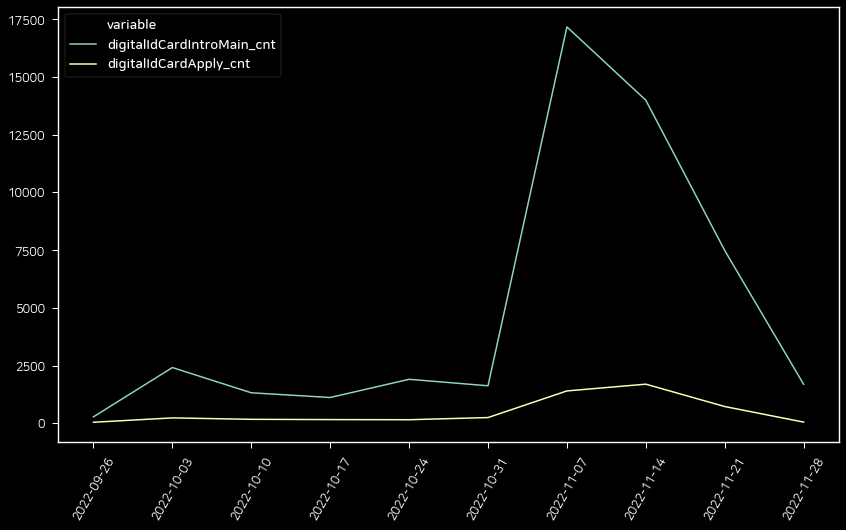

In [8]:
## 0) 디지털 주민증 데이터 세팅
s_date_drcard = '20220926'  # 디지털 주민증 시작일
df_app_log_drcard = DataImport.set_date_range(df = df_app_log,
    start= s_date_drcard, end = df_app_log.date.max())
    
## 1) 활성화 추이 분석
### (1) 디지털 주민증 신청페이지 & 신청 완료 조회  
df_drcard_intro_weekly = SphereUtils.Utils.calc_event_cnt_by_period(df_app_log_drcard, EVENT_DRCARD_INTRO_MAIN, period_standard = 'week', vis = False)
df_drcard_apply_done_weekly = SphereUtils.Utils.calc_event_cnt_by_period(df_app_log_drcard, EVENT_DRCARD_APPLY_DONE, period_standard = 'week', vis = False)
df_drcard_kpi_weekly = pd.concat(
    [df_drcard_intro_weekly.set_index('week'), df_drcard_apply_done_weekly.set_index('week')],axis = 1
    )
df_vis_long = df_drcard_kpi_weekly.reset_index().melt(id_vars = 'week')
SphereVis.vis_line_longform(df_vis_long, x = 'week', y = 'value', hue = 'variable')

In [ ]:
## 2) 사용자 분석
## output
lst_total_drcard = []
for _lst in dict_seg_project['3_drcard'].values() : lst_total_drcard = set(lst_total_drcard) | set(_lst)
_ = Profiling.demo_profiling(
    df_user_prop=df_prop.dropna(),
    KEY_ID=KEY_ID_DEVICE, 
    dict_user_list = {'drcard' : lst_total_drcard},
    total_avg = True)

In [ ]:
## 3) 디지털 주민증 퍼널 성과 분석
dict_drcard_funnel = {y : x for x,y in zip(LST_DRCARD_EVENTS, LST_DRCARD_EVENTS_FUNNEL_NM)}
df_funnel_output = Funnel.kpi_funnel_main(
        df_app_log, KEY_ID_DEVICE, dict_events = dict_drcard_funnel, 
        EVENT_ORDER = 'sapOrderPayment', PARAM_ORDER_ID = 'params_sapOrderId',
        KEY_ID_DEVICE = 'uid', KEY_ID_USER = 'user_id')
df_funnel_output['conversion_rate'] = round((df_funnel_output / df_funnel_output.shift(1)).fillna(1) * 100 ,2)
df_funnel_output

In [ ]:
## 4) 지점별 KPI
### (1) 지점별 QR 스캔
df_store_daily_wide = kto_drcard_weekly_report_custom.DrCardMain(df_app_log_drcard, df_param_drcard_qrscan)
df_store_ranking_pc, df_store_ranking_oc = kto_drcard_weekly_report_custom.drcard_store_vis(df_store_daily_wide, period_standard = 'week')

### (2) 지점별 QR 스캔 & 주민증 발급자수
df_param_drcard_qrscan_n_apply = df_param_drcard_qrscan[df_param_drcard_qrscan[KEY_ID_DEVICE].isin(lst_drcard_apply_done)]
df_store_n_apply_daily_wide = kto_drcard_weekly_report_custom.DrCardMain(df_app_log_drcard, df_param_drcard_qrscan_n_apply)
df_store_n_apply_ranking_pc, df_store_n_apply_ranking_oc = kto_drcard_weekly_report_custom.drcard_store_vis(df_store_n_apply_daily_wide, period_standard = 'week')
df_store_scan_apply_pc = KtoAnalysis.concat_cnt_n_conversion(
    df_store_ranking_pc.rename(columns = {'value' : 'QR_Scan'}),
    df_store_n_apply_ranking_pc.rename(columns = {'value' : 'Apply_Done'}))
df_store_scan_apply_oc = KtoAnalysis.concat_cnt_n_conversion(
    df_store_ranking_oc.rename(columns = {'value' : 'QR_Scan'}),
    df_store_n_apply_ranking_oc.rename(columns = {'value' : 'Apply_Done'}))
df_store_scan_apply_pc
df_store_scan_apply_oc

### (3) 지점별 QR스캔 유저의 성별 * 연령
lst_drcard_store_qc = list(df_param_drcard_qrscan[df_param_drcard_qrscan['지역'] == '평창']['장소명'].unique())
lst_drcard_store_oc = list(df_param_drcard_qrscan[df_param_drcard_qrscan['지역'] == '옥천']['장소명'].unique())
dict_drcard_total = dict_seg_project['3_drcard']
for _lst_drcard_store in [lst_drcard_store_qc, lst_drcard_store_oc] :   
    _dict_drcard_tmp = {_key: dict_drcard_total[_key] for _key in _lst_drcard_store}
    ## output
    _ = Profiling.demo_profiling(
        df_user_prop=df_prop.dropna(),
        KEY_ID=KEY_ID_DEVICE, 
        dict_user_list = _dict_drcard_tmp,
        total_avg = False)

In [ ]:
## 5) 지점별 중첩
df_drcard_qrscan_cross = KtoAnalysis.get_seg_cross_table(dict_seg = dict_seg_project['3_drcard'])
df_drcard_qrscan_cross

### (4) 여행 상품 홍보관

In [ ]:
## 1) 활성화 추이
df_app_log_promotion_main = df_app_log_promotion[df_app_log_promotion['abs_events'].apply(lambda x : EVENT_PROMOTION_MAIN in x)]
df_app_log_promotion_detail = df_app_log_promotion[df_app_log_promotion['abs_events'].apply(lambda x : EVENT_PROMOTION_DETAIL in x)]
df_promotion_main_device = df_app_log_promotion_main.groupby('week')[[KEY_ID_DEVICE]].nunique().reset_index()
df_promotion_detail_device = df_app_log_promotion_detail.groupby('week')[[KEY_ID_DEVICE]].nunique().reset_index()
df_promotion_main_weekly = KtoAnalysis.calc_event_cnt_by_period(df_app_log_promotion, EVENT_PROMOTION_MAIN, period_standard = 'week', vis = True)
df_promotion_detail_weekly = KtoAnalysis.calc_event_cnt_by_period(df_app_log_promotion, EVENT_PROMOTION_DETAIL, period_standard = 'week', vis = True)
df_promotion_output = pd.concat(
    [
    df_promotion_main_weekly.set_index('week'),
    df_promotion_detail_weekly.set_index('week'),
    df_promotion_main_device.set_index('week').rename(columns = {KEY_ID_DEVICE : 'promotionMain_device_cnt' }),
    df_promotion_detail_device.set_index('week').rename(columns = {KEY_ID_DEVICE : 'promotionDetail_device_cnt' })
    ], axis = 1
).iloc[:-1]
df_promotion_output

## 2) 성별 연령
_ = Profiling.demo_profiling(
        df_user_prop=df_prop.dropna(),
        KEY_ID=KEY_ID_DEVICE, 
        dict_user_list = {'여행상품홍보관' : lst_promotion_device},
        total_avg = True)


In [ ]:
## 3) 홍보관 기간별 선호 및 속성
### setting prep
lst_manual_period = df_param_promotion_detail['params_period'].value_counts()[:4].index
df_target_param = df_param_promotion_detail[
    df_param_promotion_detail['params_period'].isin(lst_manual_period)
    ]
TARGET_PARAM = 'params_period'
### count total value & each prop rate (gender & age) 
df_perfer_promotion_period = KtoAnalysis.clac_prop_preferenc(
    df_target_param, TARGET_PARAM, 
    df_prop, key_id = KEY_ID_DEVICE, 
    lst_prop_cate = ['gender', 'age_group_large']
    )
df_perfer_promotion_period

### (5) 꾸온꾸

In [ ]:
df_param_contents['week'] = pd.to_datetime(df_param_contents['date'], format='%Y%m%d %H:%M:%S').dt.week
df_param_contents['week'] = KtoPrep.convert_week_n_to_day(df_param_contents['week'])
df_param_gguonggu = df_param_contents[df_param_contents[PARAM_CONTENT_NAME].str.contains('기온별_여행코디', na=False)]


In [ ]:
# 1) 활성화 추이
df_param_contents['week'] = pd.to_datetime(df_param_contents['date'], format='%Y%m%d %H:%M:%S').dt.week
df_param_contents['week'] = KtoPrep.convert_week_n_to_day(df_param_contents['week'])
df_param_gguonggu = df_param_contents[df_param_contents[PARAM_CONTENT_NAME].str.contains('기온별_여행코디', na=False)]
df_cnt_gguonggu = df_param_gguonggu.groupby('week')[KEY_ID_DEVICE].nunique().reset_index()
df_cnt_gguonggu_device = df_param_gguonggu.groupby('week')[KEY_ID_DEVICE].size().reset_index()
df_gguonggu_output = pd.concat(
    [
        df_cnt_gguonggu.set_index('week').rename(columns = {KEY_ID_DEVICE : 'gguonggu_page_cnt' }),
        df_cnt_gguonggu_device.set_index('week').rename(columns = {KEY_ID_DEVICE : 'gguonggu_device_cnt' }),
    ], axis = 1
    )
df_gguonggu_output


## 2) 성별 연령
_ = Profiling.demo_profiling(
        df_user_prop=df_prop.dropna(),
        KEY_ID=KEY_ID_DEVICE, 
        dict_user_list = {'꾸온꾸' : list(df_param_gguonggu[KEY_ID_DEVICE].unique())},
        total_avg = True)

## 6)캠페인 성과 분석
 - 가볼래-터 구독
 - 앱설치 유도

### (1) 가볼래터 & 앱설치 유도

In [51]:
df_campaign_survey

,uid,click_boolean,click_date,campaign_nm,campaign_cate,questiontext,questionorder,replytext
0,Xg73iSRdTGG_cIBw9_U9og,True,"2022,06,05 19:16:21",[설문1] 여행가는 달 유저 - “대한민국 구석구석” 인지도 조사,여행가는 달,"방문 전에 ""대한민국 구석구석""를 알고 계셨나요?",0.0,아니오
1,wmiEzCwa929yGFH4L2QEkg,False,None,[설문1] 여행가는 달 유저 - “대한민국 구석구석” 인지도 조사,여행가는 달,NaN,NaN,NaN
2,C7zUXqzDlPLHTz458xho8w,False,None,[설문1] 여행가는 달 유저 - “대한민국 구석구석” 인지도 조사,여행가는 달,NaN,NaN,NaN
3,HnQnVd6cUJBSzx_ThcWt1w,True,"2022,06,05 19:49:23",[설문1] 여행가는 달 유저 - “대한민국 구석구석” 인지도 조사,여행가는 달,"방문 전에 ""대한민국 구석구석""를 알고 계셨나요?",0.0,예
4,z0RxYnPwUhteJnayMhCfwQ,False,None,[설문1] 여행가는 달 유저 - “대한민국 구석구석” 인지도 조사,여행가는 달,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1215495,WjEe8DfZRzOCdbDrdkGeHQ,False,None,[설문 3] 여행콕콕 AI콕콕플래너 만족도 조사 - 9월 개편,여행콕콕,NaN,NaN,NaN
1215496,fkMDbStyTPS210H06bTKvQ,False,None,[설문 3] 여행콕콕 AI콕콕플래너 만족도 조사 - 9월 개편,여행콕콕,NaN,NaN,NaN
1215497,uaUAGakgS7SureskJXtKHw,True,"2022,09,30 07:36:23",[설문 3] 여행콕콕 AI콕콕플래너 만족도 조사 - 9월 개편,여행콕콕,만족도를 별점으로 표시해주세요.😀,0.0,5
1215498,lpoVN-LbTBaVRtje51jDEA,False,None,[설문 3] 여행콕콕 AI콕콕플래너 만족도 조사 - 9월 개편,여행콕콕,NaN,NaN,NaN


In [36]:
list(dict_seg_from_install_referrs['SmartLinks'].keys())

['visitkorea app install link Campaign',
 'visitkorea app install link - v2',
 'testing01',
 'drcard_oc01',
 'drcard_oc02',
 'drcard_pc10',
 'drcard_pc03',
 'drcard_pc08',
 'drcard_pc09',
 'drcard_pc01',
 'drcard_pc05',
 'drcard_pc07',
 'drcard_oc03',
 'drcard_oc04',
 'drcard_pc11',
 'drcard_pc06',
 'drcard_pc04',
 'drcard_pc13',
 'drcard_pc15']

In [25]:
df_campaign_subs_install

,uid,click_boolean,click_date,campaign_nm,campaign_cate,questiontext,questionorder,replytext
111362,4izkEiAbutlq8EEbsZThSg,False,None,여행가는달 - 가볼래터 구독유도 B안 (6일),구독,NaN,NaN,NaN
111363,j89i9fgyjWp4wxcq_mjMOw,False,None,여행가는달 - 가볼래터 구독유도 B안 (6일),구독,NaN,NaN,NaN
111364,4_vBer_gpSJE_gNPrrmIjw,True,"2022,06,06 00:53:17",여행가는달 - 가볼래터 구독유도 B안 (6일),구독,NaN,NaN,NaN
111365,IR_KySiwI26ObX62qCToaw,False,None,여행가는달 - 가볼래터 구독유도 B안 (6일),구독,NaN,NaN,NaN
111366,BrVEehx8J6emzyqTmYmsVw,False,None,여행가는달 - 가볼래터 구독유도 B안 (6일),구독,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1206443,sb9Q1T1nAJxB-zMm12ALNA,False,None,[App] 대구석 앱설치 유도 - 구독완료자 (11월2),설치,NaN,NaN,NaN
1206444,w9XXiK6YuhSoCSqjsCBUMQ,False,None,[App] 대구석 앱설치 유도 - 구독완료자 (11월2),설치,NaN,NaN,NaN
1206445,dDLlyNY7j9gNg5hia03Xzg,False,None,[App] 대구석 앱설치 유도 - 구독완료자 (11월2),설치,NaN,NaN,NaN
1206446,zJ_Qgzde86dtOenh4rxBlw,True,"2022,11,30 14:30:58",[App] 대구석 앱설치 유도 - 구독완료자 (11월2),설치,NaN,NaN,NaN


In [22]:
# 1. prep
## 0) setting
# flag_date_app_sdk_installed = datetime(2022,8,9) 
## 1) campaign
lst_campaign_cate = ['구독', '설치']
df_campaign_subs_install =\
    df_campaign_survey[df_campaign_survey['campaign_cate'].isin(lst_campaign_cate)]
# ---------- 8월 이전 데이터 제외 ----------
lst_app_install_total = list(
    df_campaign_subs_install[
        df_campaign_subs_install['campaign_cate'] == '설치']
    ['campaign_nm'].unique())
LST_APP_INSTALL_BEFORE = list(set(lst_app_install_total) - set(LST_APP_INSTALL_AFTER))
df_campaign = df_campaign[
    ~df_campaign['campaign_nm'].isin(LST_APP_INSTALL_BEFORE)] 

## 2) app install user segment
lst_install_referrs_keys = list(dict_seg_from_install_referrs['SmartLinks'].keys())
dict_seg_from_install_referrs_cdp =\
    {_key: dict_seg_from_install_referrs['SmartLinks'][_key]
        for _key in lst_install_referrs_keys if 'install' in _key}

In [27]:
dict_seg_campaign_click_device.keys()

dict_keys(['여행가는 달', '설치', '디지털주민증', '원더티켓', '여행콕콕', '구독'])

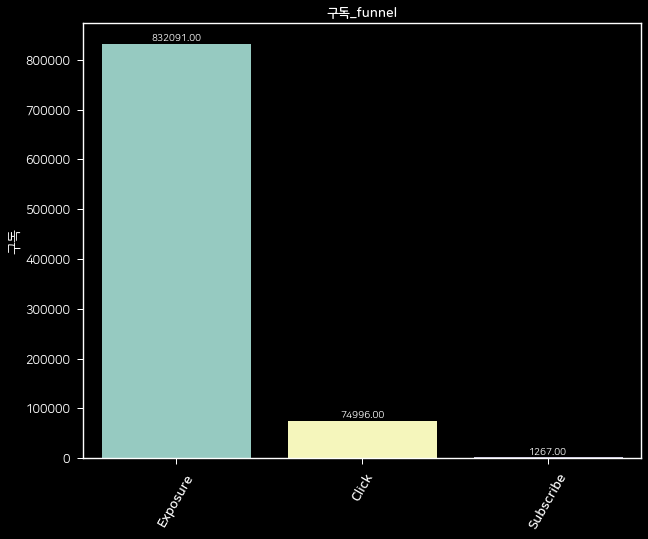

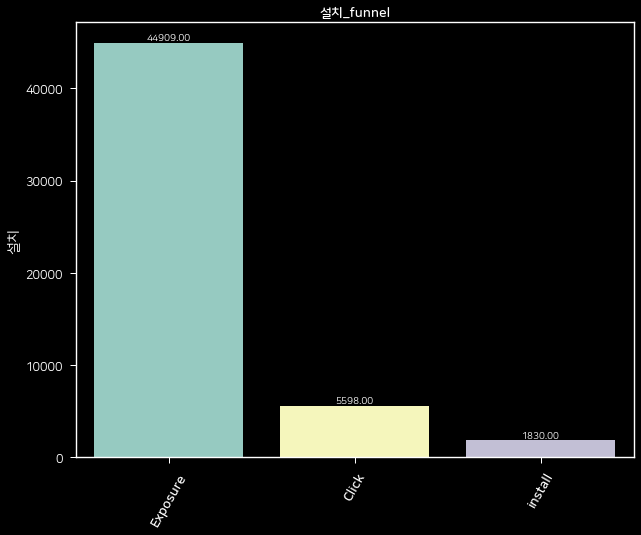

,구독,conversion
Exposure,832091,1.0000
Click,74996,0.0901
Subscribe,1267,0.0169


,설치,conversion
Exposure,44909,1.0000
Click,5598,0.1247
install,1830,0.3269


,구독,설치
전체,2525.00,20763.00
CDP 캠페인으로 확보한 수,1267.00,1830.00
전체중 비중(CDP 기여분,50.18,8.81


,구독수,구독자중 캠페인 클릭자 수,구독자중 캠페인 클릭자의 비율
5,57,17,29.82
6,400,241,60.25
7,345,212,61.45
8,608,231,37.99
9,301,232,77.08
10,426,243,57.04
11,391,93,23.79


,설치수,설치자중 캠페인 클릭자 수,설치자중 캠페인 클릭자의 비율
5,0,0,0.00
6,0,0,0.00
7,5,0,0.00
8,4872,64,1.31
9,5400,215,3.98
10,6082,890,14.63
11,4404,981,22.28


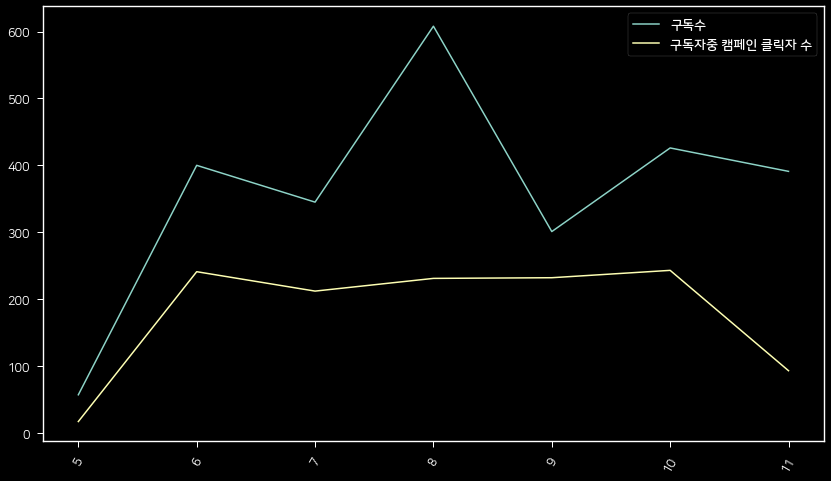

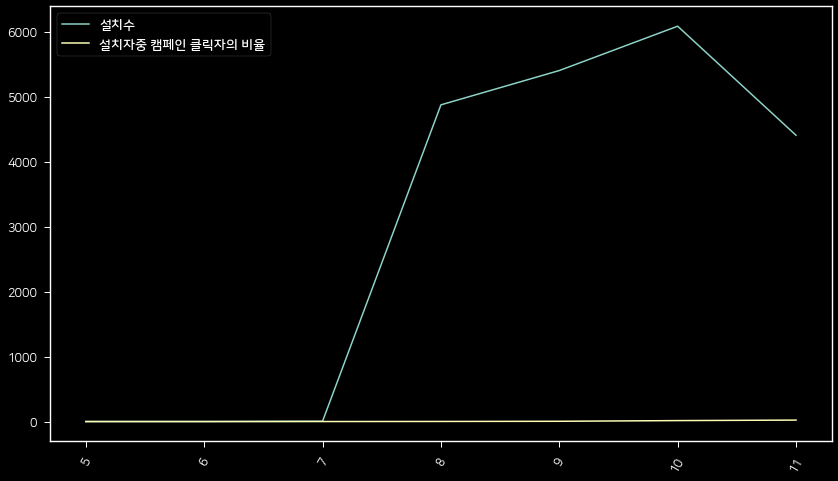

In [41]:
# 2. analysis
## 1) funnel
df_funnel_subscribe = KtoAnalysis.kto_campaign_kpi_funnel(
    df_campaign, KEY_ID_DEVICE,
    lst_subscribe_device, dict_seg_from_install_referrs_cdp, target_campaign = '구독') 
df_funnel_install = KtoAnalysis.kto_campaign_kpi_funnel(
    df_campaign, KEY_ID_DEVICE,
    lst_subscribe_device, dict_seg_from_install_referrs_cdp, target_campaign = '설치') 
df_funnel_subscribe
df_funnel_install

## 2) rate of total
df_campaign_kpi_total = KtoAnalysis.kto_campaign_kpi_total(
    lst_subscribe_device, lst_appinstall_device,
    dict_seg_campaign_click_device, dict_seg_from_install_referrs_cdp)
df_campaign_kpi_total

## 3) rate of month
dict_campaign_kpi_monthly = KtoAnalysis.kto_campaign_kpi_by_month(
        df_app_log,
        dict_subscribe_by_monthly, dict_appinstall_by_monthly,
        dict_seg_campaign_click_device)

dict_campaign_subscribe_monthly = pd.DataFrame().from_dict(dict_campaign_kpi_monthly['구독'], orient = 'index')
dict_campaign_appInstall_monthly = pd.DataFrame().from_dict(dict_campaign_kpi_monthly['설치'], orient = 'index')

## monthly vis
dict_campaign_subscribe_monthly
dict_campaign_appInstall_monthly
SphereVis.vis_line_longform(
    longform_data = dict_campaign_subscribe_monthly[['구독수','구독자중 캠페인 클릭자 수']].reset_index().melt(id_vars = ['index']), 
    x = 'index', y = 'value', hue = 'variable'
    )
SphereVis.vis_line_longform(
    longform_data = dict_campaign_appInstall_monthly[['설치수','설치자중 캠페인 클릭자의 비율']].reset_index().melt(id_vars = ['index']), 
    x = 'index', y = 'value', hue = 'variable'
    )

In [30]:
df_app_log['install_referrer'].unique()
df_app_log['install_referrer_campaign'].unique()

array(['organic', 'SmartLinks'], dtype=object)

array([None, '', 'visitkorea app install link Campaign',
       'visitkorea app install link - v2', 'testing01', 'drcard_oc01',
       'drcard_oc02', 'drcard_pc10', 'drcard_pc03', 'drcard_pc08',
       'drcard_pc09', 'drcard_pc01', 'drcard_pc05', 'drcard_pc07',
       'drcard_oc03', 'drcard_oc04', 'drcard_pc11', 'drcard_pc06',
       'drcard_pc04', 'drcard_pc13', 'drcard_pc15'], dtype=object)

## 4)대구석 사용자 분석
    A) 타겟 그룹 --> 사용자 속성 분석을 위해, User_id 활용  
        1) VIP  
            - 구독_O & 앱설치_O  
            - 컨텐츠 조회수 상/중/하  
        2) 잠재 사용자 그룹   
            - 구독_X & 사용시간 상위 30%   
            - 구독_X & 앱설치   
    B) 분석 항목  
        - 성별*연령  
        - 관심 컨텐츠  
        - 앱설치 분석   

### (0) total prop

test_th


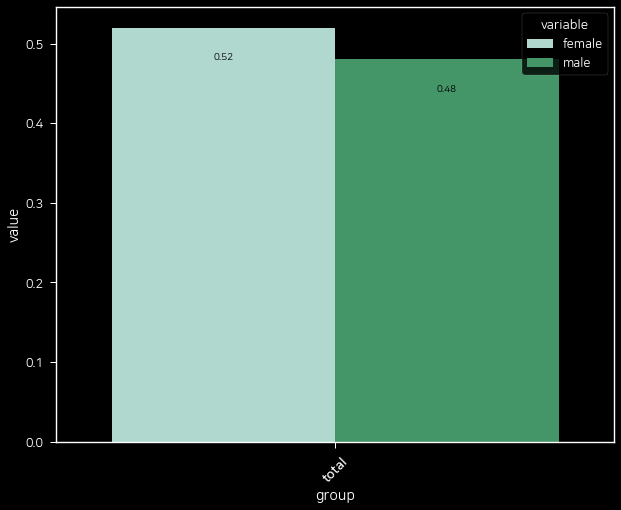

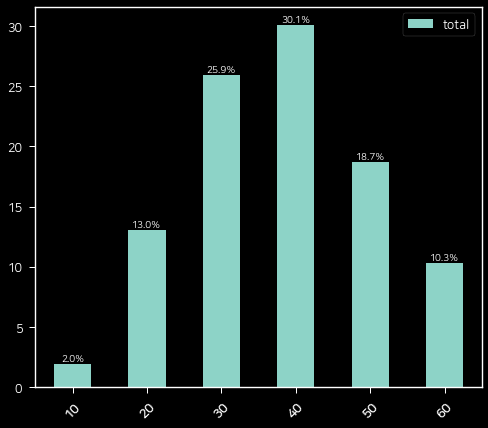

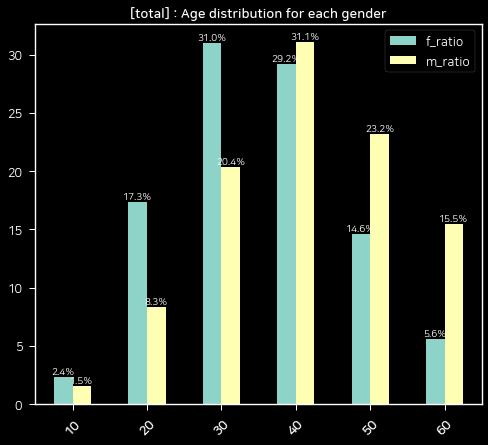

test_th


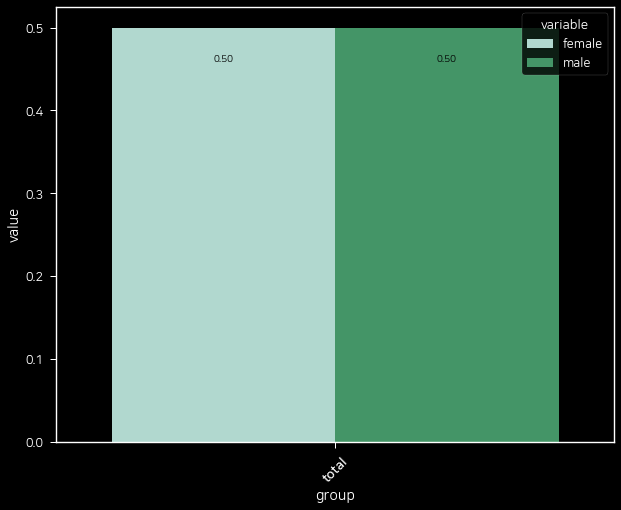

test_th


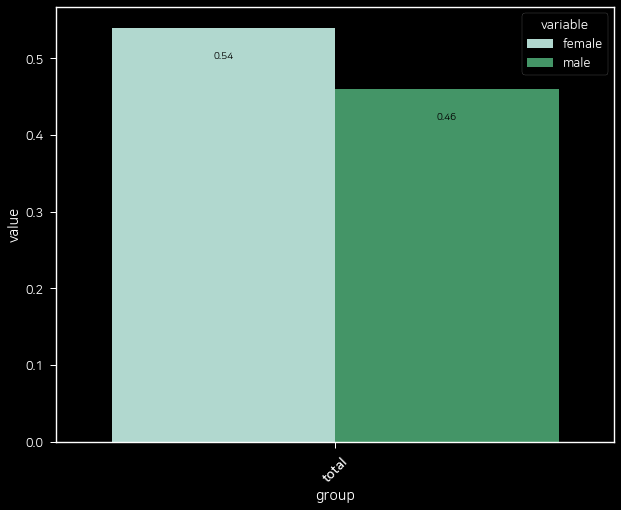

test_th


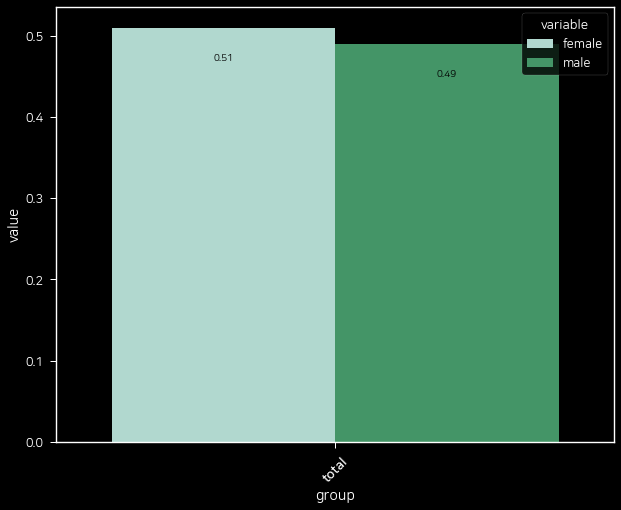

test_th


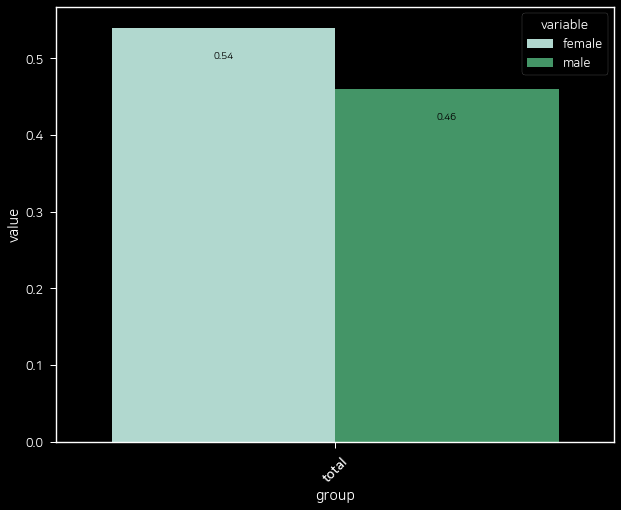

test_th


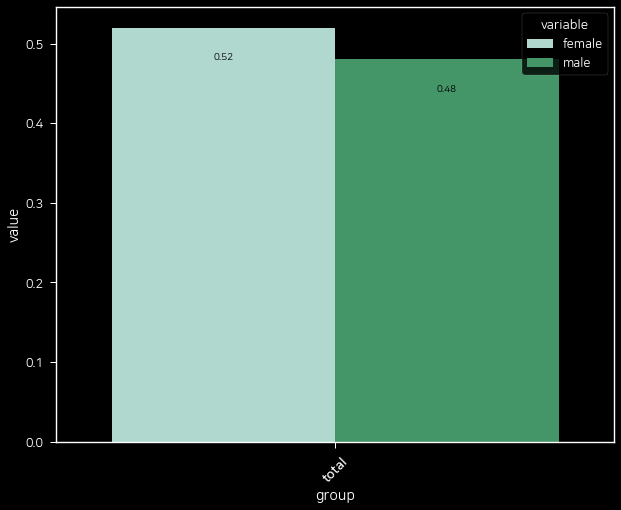

test_th


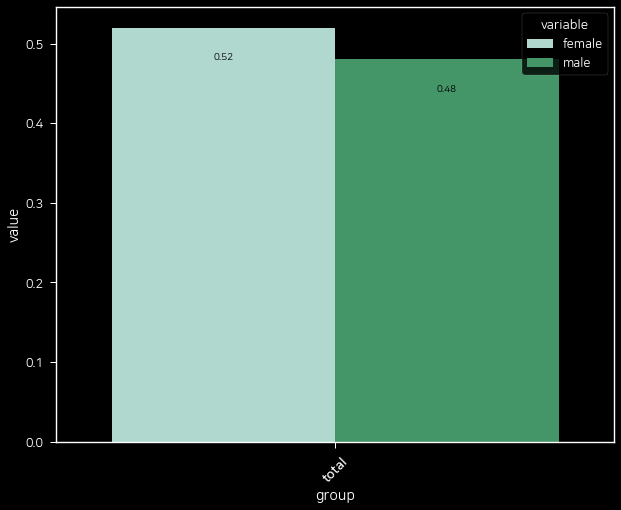

test_th


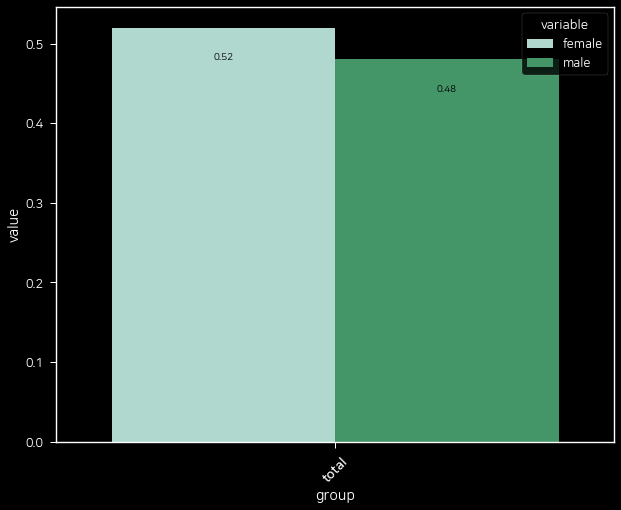

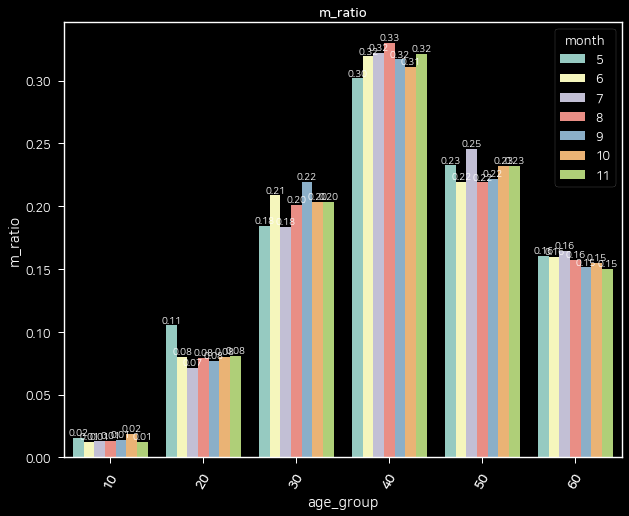

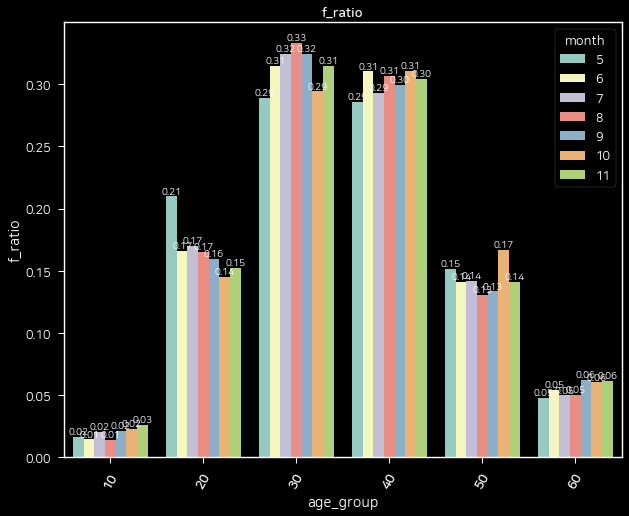

In [9]:
## 1) total
_ = Profiling.demo_profiling(
    df_user_prop=df_prop.dropna(),
    KEY_ID=KEY_ID_DEVICE, 
    dict_user_list = {'total' : list(df_app_log[KEY_ID_DEVICE].unique())},
    total_avg = False)

## 2) monthly
### (1) get monthly stats
dict_prop_output_montly = dict()
for _m in sorted(df_app_log['month'].unique()) : 
    _df_app_log_monthly = df_app_log[df_app_log['month'] == _m]
    _lst_total_device_by_monthly = list(_df_app_log_monthly[KEY_ID_DEVICE].unique())
    _prop_output = Profiling.demo_profiling(
        df_user_prop=df_prop.dropna(),
        KEY_ID=KEY_ID_DEVICE, 
        dict_user_list = {'total' : _lst_total_device_by_monthly},
        vis_type= 'gender_only',
        total_avg = False)
    dict_prop_output_montly[_m] = _prop_output['total']['age_gender']

### (2) concat
dict_prop_output_montly_copy = dict_prop_output_montly.copy()
for _m in dict_prop_output_montly_copy.keys() :
    # dict_prop_output_montly_copy[_m].columns = [x + f'_{_m}' for x in dict_prop_output_montly_copy[_m].columns]
    dict_prop_output_montly_copy[_m]['month'] = _m 
df_prop_stat_monthly = pd.concat(list(dict_prop_output_montly_copy.values()), axis = 0).reset_index().rename(columns = {'index' : 'age_group'})

### (3) stats
#### age only
# df_prop_stat_monthly['age_total_monthly'] = df_prop_stat_monthly['m'] + df_prop_stat_monthly['f']
# df_prop_stat_monthly['age_total_monthly'] / df_prop_stat_monthly.groupby('month')['age_total_monthly'].sum(axis =1 )
# df_prop_stat_monthly.head()
# df_age_monthly = df_prop_stat_monthly.groupby(['month','age_group']).sum()

#### gender only
# df_gender_monthly = df_prop_stat_monthly.groupby(['month']).sum()[['m','f']]
# df_gender_monthly['m_rate_monthly'] = df_gender_monthly['m'] / df_gender_monthly.sum(axis = 1)
# df_gender_monthly['f_rate_monthly'] = df_gender_monthly['f'] / df_gender_monthly.sum(axis = 1)
# df_gender_monthly.head()

#### age_gender
for _target_group in  ['m_ratio', 'f_ratio'] : 
    df_vis = df_prop_stat_monthly[['age_group','month',_target_group]].sort_values(['age_group',  'month']).reset_index(drop = True)
    SphereVis.basic_bar_plot(
        df_vis = df_vis, x = 'age_group', y = _target_group, hue = 'month', title = _target_group 
    )

### (1) Main Segment

#### linebyline

In [10]:
_df_target = df_app_log[df_app_log[KEY_ID_DEVICE].isin(dict_seg_age['20_30'])]
_df_subset_target_sample = _df_target.sample(int(len(_df_target) * 0.2))
Counter(_df_subset_target_sample['abs_events'].sum())
# _df_event_cnt = pd.DataFrame.from_dict(_dict_event_cnt, orient = 'index').\
#     rename(columns={0 : 'cnt'}).sort_values(by = 'cnt', ascending=False)
# _df_event_cnt['rate'] = round(_df_event_cnt['cnt'] / len(lst_target), 4)
# output_events_prefer = _df_event_cnt

Counter({'sapContentDetail': 14052,
         'balanceGameMain': 1585,
         'balanceGame': 1003,
         'travelLetterMain': 2014,
         'travelLetterNotLike': 269,
         'sapHome': 5658,
         'subscribeClicsapContentShare': 367,
         'subscribe': 266,
         'travelLetterLike': 1409,
         'safeTravelMain': 1344,
         'contentSurveyTake': 1023,
         'bottomNavi': 449,
         'drawerMain': 2472,
         'sapLogin': 1565,
         'sapContentCommentAdd': 494,
         'digitalIdCardMain': 319,
         'eventlMain': 941,
         'eventlBanner': 814,
         'homeBanner': 1213,
         'digitalIdCardIntroMain': 566,
         'digitalIdCardApplyMain': 271,
         'digitalIdCardApply': 149,
         'digitalIdCardDetail': 112,
         'digitalIdCardBenefiltDetail': 145,
         'homeSearch': 1849,
         'sapContentLikeAdd': 148,
         'region1': 193,
         'mypageMain': 317,
         '#appInstall': 75,
         'homeTopBanner': 663,
       

In [11]:
lst_target = list(set(dict_seg_gender['m']) & set(dict_seg_age['20_30']))

df_target = df_app_log[df_app_log[KEY_ID_DEVICE].isin(lst_target)]
df_prop_target = df_prop[df_prop[KEY_ID_DEVICE].isin(lst_target)].dropna()
df_param_target = df_param_contents[df_param_contents[KEY_ID_DEVICE].isin(lst_target)]
df_param_target_perfer = df_param_target.groupby(PARAM_CONTENT_NAME)[KEY_ID_DEVICE].nunique().\
    to_frame().rename(columns={KEY_ID_DEVICE : 'cnt'}).sort_values(by = 'cnt', ascending= False)

lst_compare = list(set(df_app_log[KEY_ID_DEVICE].unique()) - set(lst_target))

dict_seg_adid = app_pipe_obj.chage_key_id_seg_dict(
            df_app_log = df_app_log, before_key = KEY_ID_DEVICE,
            dict_seg = {'m_20_30' : lst_target, '나머지 전체' : lst_compare})

In [38]:
_lst_target_user = dict_seg_adid['m_20_30']
_lst_compare_user = dict_seg_adid['나머지 전체']
# appInstall_output = app_pipe_obj.appInstall_report_run(
#     _lst_target_user,_lst_compare_user, n_top_app = 1000, n_print = 100 )

In [26]:
lst_app_install_data = os.listdir(f'{INPUT_PATH_INSTALL}/{APP_KEY}/' +'android/')
latest_appinstall_data = [x for x in lst_app_install_data if 
                            (str(max(list(map(lambda x : int(re.findall("\d+", x)[1]), lst_app_install_data))))  in x) & 
                            ('accum' not in x ) & ('delete' not in x ) & ('install' not in x )][0] # f'{APP_KEY}_{PLATFORM}_{s_date}_{e_date}.json'
print('target latest file : ', latest_appinstall_data)


df_app_install, lst_app_cate = DataImport.appInstallData_import(
                                    INPUT_PATH = INPUT_PATH_INSTALL,
                                    APP_KEY = APP_KEY,
                                    PLATFORM = 'android',
                                    target_data_file = latest_appinstall_data)

target latest file :  kto_android_20220801_20221123.json


In [35]:
df_app_install.head(3)
lst_app_cate[0]

,total_apps,uid,adid
0,"[T world, (서비스 중지) 대한항공, TESSA : ART, THE NEW ...",Vpg4fmNCQ86eh-32zk3mwQ,6b704829-3d8e-402e-b4db-763831b96c6d
1,"[네이트온, 연세대학교 대표 모바일 앱 : 연세탑 Y-TOP, 팔 운동, Fores...",rRRofCpzR8KGF7TLqjkljg,56b7f627-6332-4406-abe0-a617157ea8a5
2,"[TV watching Guide & movies, Fitdays, 3D Monsu...",VU5nfkWzQmmU1Q0j3sDG6A,4789871c-1433-4157-9334-347867e8a9e0


{'name': 'DPI Checker',
 'app_id': 'U4oa0uGf',
 'code1': '7',
 'code2': '0',
 'cate1': '도구',
 'cate2': ''}

In [31]:
dict_app_cate = DataImport.make_dict_app_cate(lst_app_cate)
dict_app_cate_inv = dict([(value['name'], key) for key, value in dict_app_cate.items()])   ## 기존의 id로 되어있던 dict_app_cate에서 앱 이름, id를 추출해서 key=name, value=id로 두는 dict 생성
df_app_install['total_apps'] = df_app_install['total_apps'].apply(lambda x: DataImport.app_name_convert(dict_app_cate,x))    


In [40]:
df_app_install_target = df_app_install[df_app_install['adid'].isin(_lst_target_user)]
df_app_install_compare = df_app_install[df_app_install['adid'].isin(_lst_compare_user)]

df_compare_app_cnt, n_compare_user = AppInstallAnalysis.gen_df_app_count(
        df_app_install = df_app_install_compare,
    )

df_target_app_cnt, n_target_user  = AppInstallAnalysis.gen_df_app_count(
        df_app_install = df_app_install_target,
    )

In [48]:
df_compare_app_cnt, df_target_app_cnt = AppInstallAnalysis.extract_n_top_app_data(
    df_compare_app_cnt = df_compare_app_cnt, #df_total_app_count, 
    df_target_app_cnt = df_target_app_cnt,
    n_compare_user = n_compare_user, 
    n_target_user = n_target_user
)

df_compare_app_cnt
df_target_app_cnt 

,app_name,count,total_rate
283,"대한민국 구석구석(국내여행, 관광지, 음식, 숙박)",51715,1.000000
131,카카오톡 KakaoTalk,50652,0.979445
193,네이버 - NAVER,48537,0.938548
16,V3 Mobile Plus,48427,0.936421
227,삼성 음성 녹음,45762,0.884888
...,...,...,...
75567,Butt Exersices & Legs Workout,1,0.000019
75568,Free Exercises for Weight Loss,1,0.000019
75569,Yoga Poses and Asanas for Relief of Back Pain,1,0.000019
75570,"Yoga Poses & Asanas for Butt, Thighs and Legs",1,0.000019


,app_name,count,intersect_rate
109,"대한민국 구석구석(국내여행, 관광지, 음식, 숙박)",652,1.000000
39,카카오톡 KakaoTalk,642,0.984663
3,V3 Mobile Plus,630,0.966258
86,Samsung Calculator,606,0.929448
73,네이버 - NAVER,605,0.927914
...,...,...,...
6985,QUkR3Toe,1,0.001534
6984,jskJmJv1,1,0.001534
6983,Analog Palette: Instant Edition,1,0.001534
6982,ruKHqbpR,1,0.001534


In [49]:
df_app_relation_merge_fin = pd.merge(df_compare_app_cnt[['app_name', 'total_rate']],
                                             df_target_app_cnt[['app_name', 'intersect_rate']], 
                                             on = 'app_name')
df_app_relation_merge_fin

,app_name,total_rate,intersect_rate
0,"대한민국 구석구석(국내여행, 관광지, 음식, 숙박)",1.000000,1.000000
1,카카오톡 KakaoTalk,0.979445,0.984663
2,네이버 - NAVER,0.938548,0.927914
3,V3 Mobile Plus,0.936421,0.966258
4,삼성 음성 녹음,0.884888,0.921779
...,...,...,...
11992,c_E2bnBQ,0.000019,0.001534
11993,カラオケ ビッグエコー 公式アプリ,0.000019,0.001534
11994,키미 슈퍼스타: 말하는 패션 고양이,0.000019,0.001534
11995,Vape Tool,0.000019,0.001534


In [52]:
df_total_app_relation_fin = AppInstallAnalysis.calc_relataion(df_app_relation_merge_fin, how = 'rel')

df_total_app_relation_fin['cate_1'] = df_total_app_relation_fin['app_name'].apply(lambda x : AppInstallAnalysis.appNm_cate_math(
    appNm_query = x, cate_type = 'cate_1', dict_app_cate = dict_app_cate, dict_app_cate_inv = dict_app_cate_inv))

df_total_app_relation_fin['cate_2'] = df_total_app_relation_fin['app_name'].apply(lambda x : AppInstallAnalysis.appNm_cate_math(
    appNm_query = x, cate_type = 'cate_2', dict_app_cate = dict_app_cate, dict_app_cate_inv = dict_app_cate_inv))

df_total_app_relation_fin

df_total_app_relation_fin = df_total_app_relation_fin[['app_name', 'cate_1', 'cate_2', 'rel_relation']].reset_index(drop = True)
df_total_app_relation_fin
# # + cate_1이 없는 결과물은 앱이름-미맵핑 결과물로 처리하여 제거
df_total_app_relation_fin = df_total_app_relation_fin[df_total_app_relation_fin['cate_1'].isna() == False].reset_index(drop = True)
df_total_app_relation_fin

,app_name,total_rate,intersect_rate,rel_relation,cate_1,cate_2
11957,yXVmJZxy,0.000019,0.003067,157.634969,None,None
11982,Switch eShop Saver,0.000019,0.003067,157.634969,도구,
11519,AnTok,0.000019,0.003067,157.634969,금융,
11771,비타민티비 live cast - vitatv 365일 실시간 라이브 무료시청 인기B...,0.000019,0.003067,157.634969,엔터테인먼트,
11801,콕스네트웍스,0.000019,0.003067,157.634969,도구,
...,...,...,...,...,...,...
1027,포스티 - 백화점 패션 브랜드를 아울렛 가격으로,0.017326,0.001534,-0.911476,쇼핑,
1019,pmLclWKC,0.017461,0.001534,-0.912162,None,None
629,만보기 - 걸음 계산기,0.035077,0.003067,-0.912550,건강/운동,
776,지하철 노선도,0.025931,0.001534,-0.940852,여행 및 지역정보,교통수단정보


,app_name,cate_1,cate_2,rel_relation
0,yXVmJZxy,None,None,157.634969
1,Switch eShop Saver,도구,,157.634969
2,AnTok,금융,,157.634969
3,비타민티비 live cast - vitatv 365일 실시간 라이브 무료시청 인기B...,엔터테인먼트,,157.634969
4,콕스네트웍스,도구,,157.634969
...,...,...,...,...
11992,포스티 - 백화점 패션 브랜드를 아울렛 가격으로,쇼핑,,-0.911476
11993,pmLclWKC,None,None,-0.912162
11994,만보기 - 걸음 계산기,건강/운동,,-0.912550
11995,지하철 노선도,여행 및 지역정보,교통수단정보,-0.940852


,app_name,cate_1,cate_2,rel_relation
0,Switch eShop Saver,도구,,157.634969
1,AnTok,금융,,157.634969
2,비타민티비 live cast - vitatv 365일 실시간 라이브 무료시청 인기B...,엔터테인먼트,,157.634969
3,콕스네트웍스,도구,,157.634969
4,리훈,쇼핑,,157.634969
...,...,...,...,...
10535,팔도감 - 제철먹거리 직거래앱,식음료,,-0.904666
10536,포스티 - 백화점 패션 브랜드를 아울렛 가격으로,쇼핑,,-0.911476
10537,만보기 - 걸음 계산기,건강/운동,,-0.912550
10538,지하철 노선도,여행 및 지역정보,교통수단정보,-0.940852


test_th


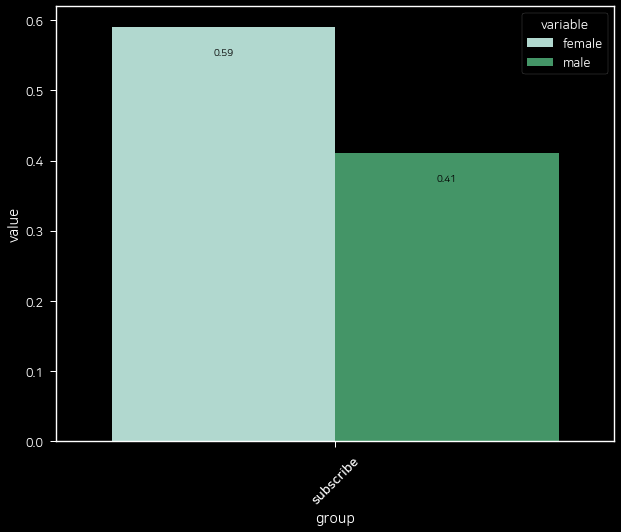

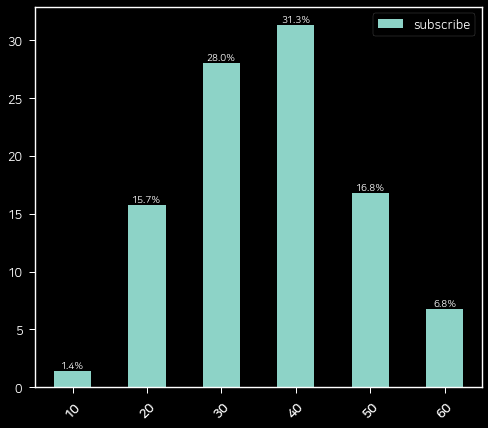

In [55]:
# 구독 segment profiling
AnalysisObj = KtoAnalysis(df_app_log, df_prop, df_param_contents)
## 3) 구독자
lst_target = lst_subscribe_device
dict_profiling_output_subscribe = AnalysisObj.profiling_pipe('subscribe', lst_target, app_pipe_obj, vis = True)

In [56]:
for _k in dict_profiling_output_subscribe.keys() :
    print(f'--------------------{_k}--------------------')
    if _k in ['prefer_Events', 'prefer_Contents', 'app_intsall' ] :
        dict_profiling_output_subscribe[_k].head(20)
    else :
        dict_profiling_output_subscribe[_k]

--------------------size--------------------


2525

--------------------age_gender--------------------


,m,f,m_ratio,f_ratio,subscribe
10,7,24,0.0076,0.0186,1.40
20,78,269,0.0852,0.2080,15.71
30,199,420,0.2172,0.3248,28.02
40,302,390,0.3297,0.3016,31.33
50,215,156,0.2347,0.1206,16.79
60,115,34,0.1255,0.0263,6.75


--------------------contents_cnt--------------------


9.98

--------------------conn_cnt--------------------


1.98

--------------------prefer_Events--------------------


,cnt,rate
sapContentDetail,3869,1.5323
sapHome,1022,0.4048
travelLetterMain,841,0.3331
balanceGameMain,686,0.2717
travelLetterLike,662,0.2622
subscribe,603,0.2388
balanceGame,479,0.1897
subscribeClicsapContentShare,449,0.1778
homeSearch,378,0.1497
drawerMain,353,0.1398


--------------------prefer_Contents--------------------


,cnt,rate
params_sapContentName,,
가볼래-터 구독하러 가기,2450,0.9703
여행구독 '가볼래-터' 구독자 레벨업을 위한 ★미션 참여 방법& 선물 언박싱★,1118,0.4428
여행상품 홍보관 오픈 기념 이벤트!,162,0.0642
여행재생목록 지도,157,0.0622
교통할인혜택,144,0.0570
"부산사랑해(海) 함께하면 행복해(海)! 부산 관광 스타기업과 함께 해양환경보전 서약하고, 여행을 선물하세요!",136,0.0539
숙박할인혜택,134,0.0531
＇당신의 최애 맛집은?＇최애 맛집 제보 EVENT 《그곳이 알고싶다》,114,0.0451
[드라이브 코스 추천] 차타고 떠나는 대한민국 구석구석 이색여행!,105,0.0416


--------------------app_intsall--------------------


,app_name,cate_1,cate_2,rel_relation
0,보고(VOGO) – 라이브 쇼핑,쇼핑,홈쇼핑,2.623390
1,SB톡톡플러스,금융,,2.424738
2,롯데면세점,쇼핑,면세점,2.339969
3,할리스커피,라이프스타일,브랜드스토어,2.330165
4,"지맵(Z-MAP) - 제로페이, 가맹점 찾기, 모바일상품권",지도/내비게이션,교통카드,2.149950
5,땡겨요,식음료,,2.066443
6,LinkedIn,비즈니스,취업/채용/알바,2.031937
7,티머니페이,금융,간편결제/페이/송금,1.989328
8,디지털OTP(스마트보안카드),금융,,1.922473
9,터치AK몰,쇼핑,종합몰/오픈마켓,1.916558


#### original code

In [47]:
# 1. 성별 & 연령
AnalysisObj = KtoAnalysis(df_app_log, df_prop, df_param_contents)

## 1) Male
lst_target = list(set(dict_seg_gender['m']) & set(dict_seg_age['20_30']))
dict_profiling_output_m_2030 = AnalysisObj.profiling_pipe('m_20_30', lst_target, app_pipe_obj ,vis = False)
lst_target = list(set(dict_seg_gender['m']) & set(dict_seg_age['40_50']))
dict_profiling_output_m_4050 = AnalysisObj.profiling_pipe('m_40_50', lst_target, app_pipe_obj ,vis = False)
## 2) Female
lst_target = list(set(dict_seg_gender['f']) & set(dict_seg_age['20_30']))
dict_profiling_output_f_2030 = AnalysisObj.profiling_pipe('f_20_30', lst_target, app_pipe_obj ,vis = False)
lst_target = list(set(dict_seg_gender['f']) & set(dict_seg_age['40_50']))
dict_profiling_output_f_4050 = AnalysisObj.profiling_pipe('f_40_50', lst_target, app_pipe_obj ,vis = False)

dict_profiling_output_f_2030['app_intsall'].head(30)
dict_profiling_output_m_2030['app_intsall'].head(30)
dict_profiling_output_f_4050['app_intsall'].head(30)
dict_profiling_output_m_4050['app_intsall'].head(30)

,app_name,cate_1,cate_2,rel_relation
0,임신육아종합포털(아이사랑 모바일),교육,유/아동/키즈,4.944242
1,에이블리 - 셀럽마켓 모음앱,쇼핑,,4.435450
2,지그재그 - 여성쇼핑몰 모음앱,쇼핑,,4.399080
3,여성생리달력 - 생리 및 가임기간 임신 배란,건강/운동,여성건강,4.299514
4,W컨셉,쇼핑,,4.215901
5,브랜디 - 하루배송,쇼핑,,4.162195
6,런데이 - 30분 달리기 PT,건강/운동,,4.070093
7,Foodie 푸디 - 일상을 맛있게,사진,카메라/촬영,4.011234
8,"택배파인더-로지아이,배송조회,포인트,택배예약,편의점택배",라이프스타일,택배/배달,3.921547
9,화해 - 6년 연속 1위 화장품 앱,뷰티,화장품/메이크업,3.888379


,app_name,cate_1,cate_2,rel_relation
0,Steam,엔터테인먼트,게임/게임방송/게임정보,6.096439
1,"Discord - 친구와 대화, 영상 채팅, 모임",커뮤니케이션,영상/음성/그룹통화,4.360984
2,"Twitch: 리그 오브 레전드, Hearthstone, MMO 게임 스트리밍 라이...",엔터테인먼트,게임/게임방송/게임정보,4.019465
3,KREAM (크림) - 한정판 거래의 FLEX,쇼핑,,3.900623
4,Chrome 원격 데스크톱,도구,기기제어/연결/리모콘,3.338133
5,유니콘 HTTPS 우회앱 - 안전하고 빠른 HTTPS/SNI 차단 우회앱,도구,VPN,3.185195
6,잡플래닛-2020년 일하기 좋은 기업은 어디?,비즈니스,취업/채용/알바,3.134039
7,지쿠터(Gcooter) - 대한민국 대표 공유 마이크로 모빌리티,라이프스타일,,3.040825
8,그린카 – 이동을 새로 그리다,지도/내비게이션,카쉐어링,2.889770
9,레드커넥트 - 300만 헌혈자를 위한 공식 헌혈 앱,라이프스타일,기관/협회/단체포털,2.883822


,app_name,cate_1,cate_2,rel_relation
0,"WOO! Fashion, 우패션 - 백화점 브랜드 다모아",쇼핑,백화점,2.957288
1,"하이클래스-알림장, 가정통신문, 하이톡",교육,,2.486441
2,학교종이,생산성,메모/다이어리/할일,2.279636
3,아이엠스쿨 - 한국 1위 알림장,교육,,2.097745
4,건강상태 자가진단(교육부),건강/운동,기관/단체/협회,2.061103
5,온통대전,금융,신용카드/체크카드/앱카드,1.920095
6,클래스팅 - 온라인 교실,교육,초등학생,1.916158
7,스마트 공지시스템 e알리미,커뮤니케이션,,1.915826
8,오아시스마켓 - 오아시스 유기농 새벽을 엽니다!,쇼핑,,1.795706
9,워크온(WalkON) - 걸음이 혜택이 되는 플랫폼,건강/운동,,1.785787


,app_name,cate_1,cate_2,rel_relation
0,에너지 플러스,라이프스타일,,1.924178
1,Google 피트니스: 건강 및 활동 추적,건강/운동,,1.702738
2,Microsoft Authenticator,비즈니스,전자인증/간편인증,1.649566
3,BLUE 현대오일뱅크 보너스카드,라이프스타일,멤버십/회원카드/상품권,1.545518
4,S-OIL 구도일 Family,라이프스타일,멤버십/회원카드/상품권,1.541845
5,Files by Google: Clean up space on your phone,도구,파일탐색/관리/공유,1.467158
6,1Q 통합인증 - KEB하나은행 보안인증서비스,금융,,1.440958
7,디지털원패스,도구,,1.424532
8,캐롯손해보험,금융,보험/생명/화재,1.298569
9,Microsoft Edge,커뮤니케이션,브라우저,1.279166


In [ ]:
# 2. 주요 Seg
AnalysisObj = KtoAnalysis(df_app_log, df_prop, df_param_contents)
## 3) 구독자
lst_target = lst_subscribe_device
dict_profiling_output_subscribe = AnalysisObj.profiling_pipe('subscribe', lst_target, app_pipe_obj, vis = True)
for _k in dict_profiling_output_subscribe.keys() :
    print(f'--------------------{_k}--------------------')
    if _k in ['prefer_Events', 'prefer_Contents', 'app_intsall' ] :
        dict_profiling_output_subscribe[_k].head(20)
    else :
        dict_profiling_output_subscribe[_k]

In [ ]:
## 4) 접속시간 상위
lst_target = list(set(dict_seg_duration['high']) - set(lst_subscribe_device))[:10000]
lst_target = list(dict_seg_duration['high'])[:10000]
dict_profiling_output_duration = AnalysisObj.profiling_pipe('duration_high', lst_target, app_pipe_obj, vis = True)
for _k in dict_profiling_output_duration.keys() :
    print(f'--------------------{_k}--------------------')
    if _k in ['prefer_Events', 'prefer_Contents', 'app_intsall' ] :
        dict_profiling_output_duration[_k].head(20)
    else :
        dict_profiling_output_duration[_k]

### (2) Segment Clustering

In [7]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

# output stats
def cluster_output_stats_kto(df_target, pred) :
    df_output = df_target.copy()
    ## merge pred
    df_output['cluster'] = pred

    # for i in ['contents_cnt','day_cnt'] :
    #     df_output[i] = np.exp((np.exp(df_output[i]) -1)  / 10) - 1

    lst_user_cnt = []
    lst_kpi_1_cnt = []
    lst_kpi_2_cnt = []
    lst_kpi_3_duration = []
    for i in list(set(pred)) :
        # print(f'----cluster : {i}----')
        df_subset = df_output[df_output['cluster'] == i] 
        kpi_1_cnt_mean = df_subset['contents_cnt'].mean()
        kpi_2_cnt_mean = df_subset['day_cnt'].mean()
        kpi_3_duration_mean = df_subset['duration'].mean()
        lst_user_cnt.append(len(df_subset))
        lst_kpi_1_cnt.append(round(kpi_1_cnt_mean, 4))
        lst_kpi_2_cnt.append(round(kpi_2_cnt_mean, 4))
        lst_kpi_3_duration.append(round(kpi_3_duration_mean, 4))

        # print(f'label_{i} : n_user -> {len(df_subset)}')
        # print(f'label_{i} : buy_cnt_mean -> {round(buy_cnt_mean, 4)}')
        # print(f'label_{i} : excg_cnt_mean -> {round(excg_cnt_mean, 4)}')

    df_cluster_result = pd.DataFrame(
        {   'n_user_cnt_avg' : lst_user_cnt,
            'contents_cnt_avg' : lst_kpi_1_cnt,
            'day_cnt_avg' : lst_kpi_2_cnt,
            'duration_avg' : lst_kpi_3_duration
        },
        index = list(set(pred))
    )

    return df_cluster_result

In [13]:
#-------------------------#
# 1. Data setting
#-------------------------#
## 1) subscribe table
# df_app_log['subscribe_boolean'] = df_app_log['abs_events'].apply(lambda x : True if EVENT_SUBSCRIBE in x else False)
# df_subscribe_boolean = df_app_log.groupby(KEY_ID_DEVICE)['subscribe_boolean'].sum().to_frame().reset_index()
# df_subscribe_boolean['subscribe_boolean'] = df_subscribe_boolean['subscribe_boolean'].apply(lambda x : x if x == 0 else 1 )
df_duration = df_app_log[[KEY_ID_DEVICE, 'duration']].groupby(KEY_ID_DEVICE).sum().reset_index()
## 2) contents cnt table
df_content_cnt = df_param_contents.groupby(KEY_ID_DEVICE)[PARAM_CONTENT_NAME].nunique().\
    to_frame().rename(columns = {PARAM_CONTENT_NAME : 'contents_cnt'}).reset_index()
## 3) day cnt tabel
df_day_cnt = df_app_log.groupby(KEY_ID_DEVICE)['day'].nunique().\
    to_frame().rename(columns = {'day' : 'day_cnt'}).reset_index()
## 4) color palette
color_palette = sns.color_palette("Paired", 10)

#-------------------------#
# 2. data merge
#-------------------------#
df_subscribe_content = pd.merge(
        df_duration,
        df_content_cnt,
        how = 'outer'
        )
df_subscribe_content_conn = pd.merge(
        df_subscribe_content,
        df_day_cnt,
        how = 'outer'
        ).set_index(KEY_ID_DEVICE).dropna()
## columnb order 
df_subscribe_content_conn = df_subscribe_content_conn[['duration','contents_cnt','day_cnt']] # 

#-------------------------#
# 3. Preprocess
#-------------------------#
# ## 1) delete under n seconde user
# df_subscribe_content_conn = df_subscribe_content_conn[
#     ((df_subscribe_content_conn['day_cnt'] >= 1) &
#     (df_subscribe_content_conn['contents_cnt'] >= 1)) 
#     ]
print('num of target users : ',len(df_subscribe_content_conn))

## 2) sampling
# df_target = df_subscribe_content_conn.copy()
df_raw = df_subscribe_content_conn.sample(100000, random_state = 1234)
df_target = df_subscribe_content_conn.sample(100000, random_state = 1234)

## 3) scaling
data_raw = df_target.values
# df_target['subscribe_boolean'] = df_target['subscribe_boolean']# round(np.log(df_target['age'] + 1), 2)
df_target['duration'] = round(np.log(df_target['duration'] + 1), 2)
df_target['contents_cnt'] = np.log(np.log(df_target['contents_cnt'] + 1) * 10 + 1)
df_target['day_cnt'] = np.log(np.log(df_target['day_cnt'] + 1) * 10 + 1)

## 4) make array type
data = df_target.values

## 5) min-max scaling
scaler = MinMaxScaler()
scaler.fit(data)
data = scaler.transform(data)


num of target users :  1823199


MinMaxScaler()

================before clustering================


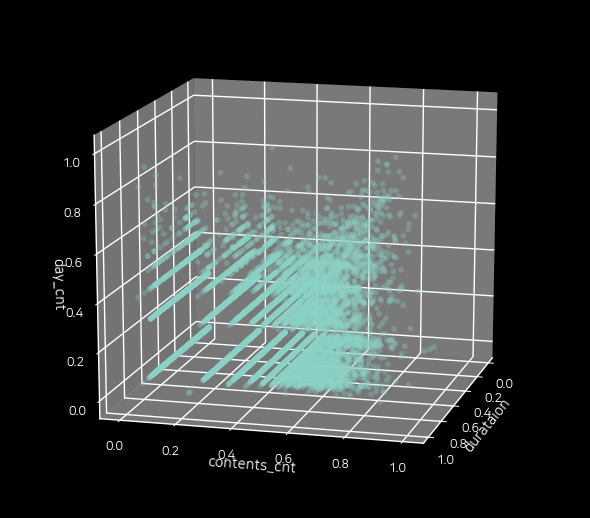

In [14]:
#-------------------------#
# 4. clustreing
## 1) vis before clustering
print('================before clustering================')
fig = plt.figure()
_ = ax = Axes3D(fig)
_ = ax.scatter(
    data[:,0], data[:,1], data[:,2],
    alpha = 0.3, s=30)
_ = ax.view_init(elev = 15, azim=15)
_ = ax.set_xlabel('durataion')
_ = ax.set_ylabel('contents_cnt')
_ = ax.set_zlabel('day_cnt')
plt.show()

0.15 300
================modling================


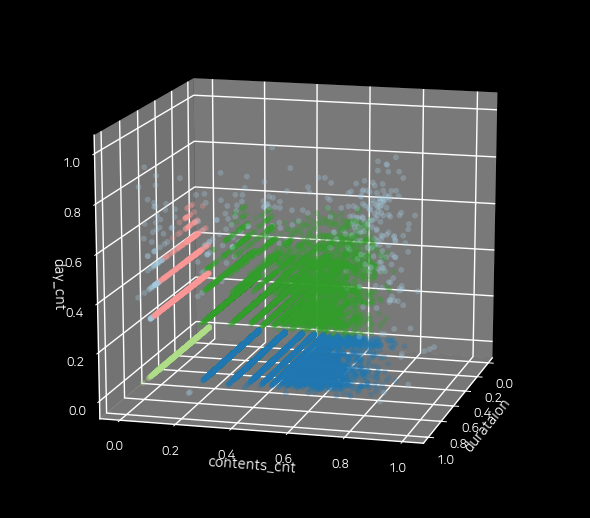

,n_user_cnt_avg,contents_cnt_avg,day_cnt_avg,duration_avg
0,21969,2.6649,2.0708,3.0410
1,68904,2.0708,2.0708,1.3424
2,6718,2.8580,2.5829,4.0500
3,2057,2.0708,2.5433,2.5991
-1,352,3.1235,3.0529,7.0394


,n_user_cnt_avg,contents_cnt_avg,day_cnt_avg,duration_avg
0,21969,3.6045,1.0000,182.7225
1,68904,1.0000,1.0000,28.5547
2,6718,6.9214,2.5912,369.2035
3,2057,1.0000,2.3184,85.4509
-1,352,52.3835,9.6790,4040.0804


In [15]:
# 1)parameter tunning
lst_eps = [0.15]#[0.1, 0.15, 0.2]
lst_min_samples = [300]#[100, 300, 500] #, 1000] #, 100]
lst_azim = [15] #, 30, 45] 
for _e in lst_eps :
    for _min_sample in lst_min_samples :
        for _azim in lst_azim :
            print(_e, _min_sample)
            print('================modling================')
            # 2) mdeling clustering
            model = DBSCAN(
                eps= _e, min_samples=_min_sample)
            _ = model.fit_predict(data)
            pred = model.fit_predict(data)

            ## 3) output vis 
            fig = plt.figure()
            _ = ax = Axes3D(fig)
            _ = ax.scatter(
                # data[:,0],
                ## if min-max O 
                data[:,0], 
                data[:,1], 
                data[:,2], 
                ## if min-max X 
                # (np.exp(data[:,0]) -1) / 10 , 
                # (np.exp(data[:,1]) -1) / 10 , 
                # (np.exp(data[:,2]) -1) / 10, 
                c=[color_palette[x+1] for x in model.labels_],
                alpha = 0.3, s=30)
            _ = ax.view_init(elev = 15, azim=_azim)
            _ = ax.set_xlabel('durataion')
            _ = ax.set_ylabel('contents_cnt')
            _ = ax.set_zlabel('day_cnt')
            plt.show()

            ## 4) output stat
            # log -> exp
            df_cluster_result = cluster_output_stats_kto(df_target, pred)
            df_cluster_result_raw = cluster_output_stats_kto(df_raw, pred)
            df_cluster_result
            df_cluster_result_raw

test_th


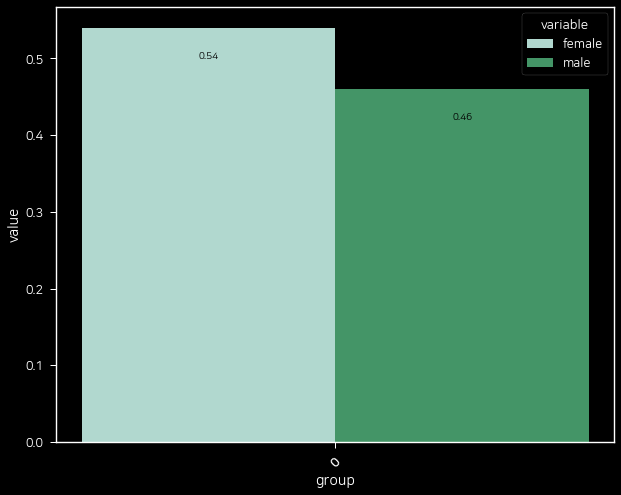

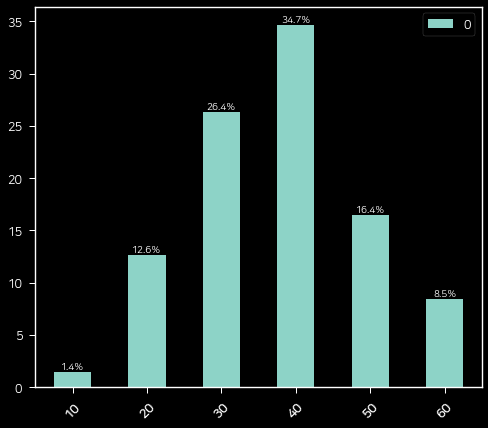

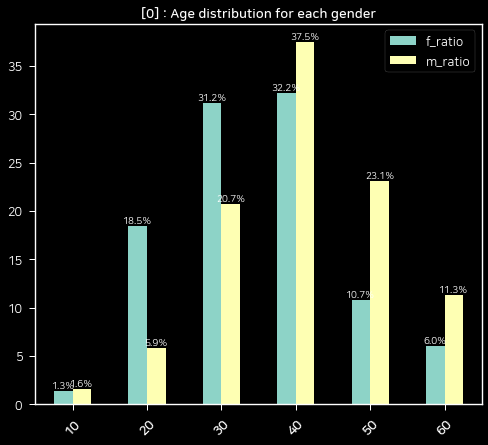

test_th


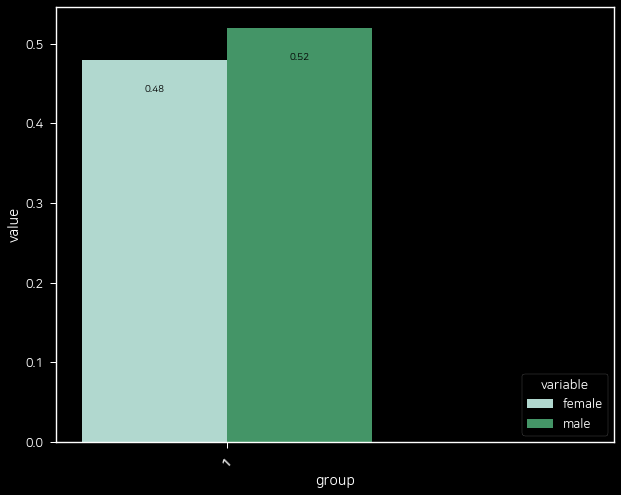

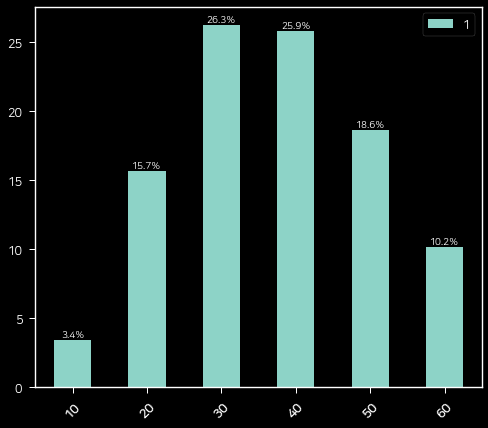

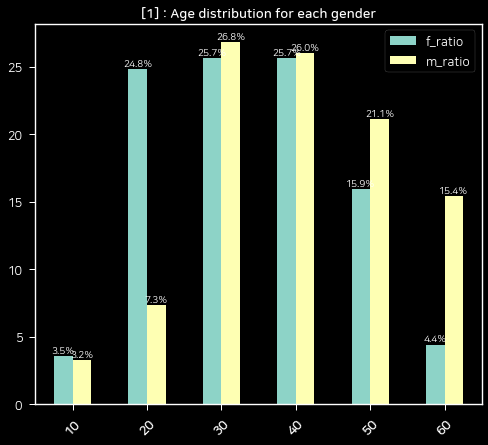

test_th


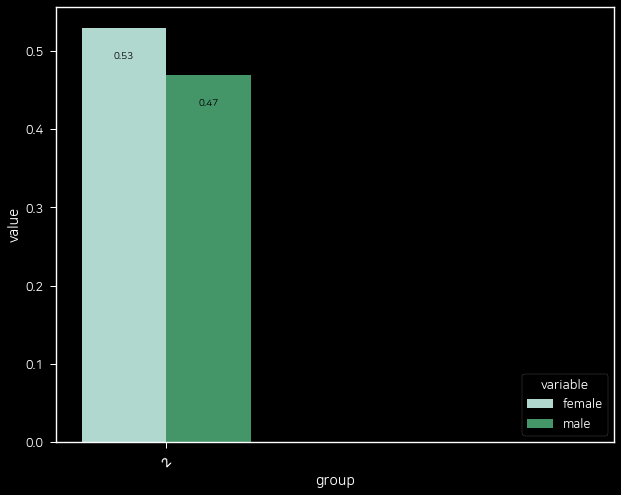

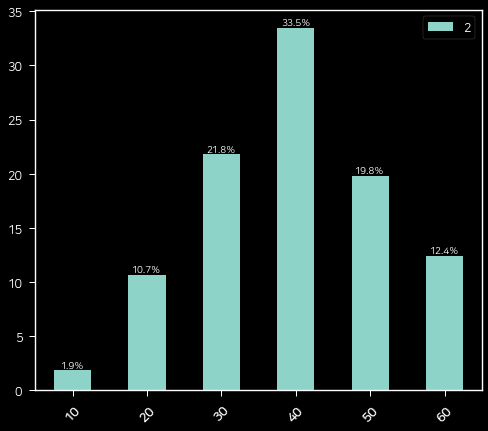

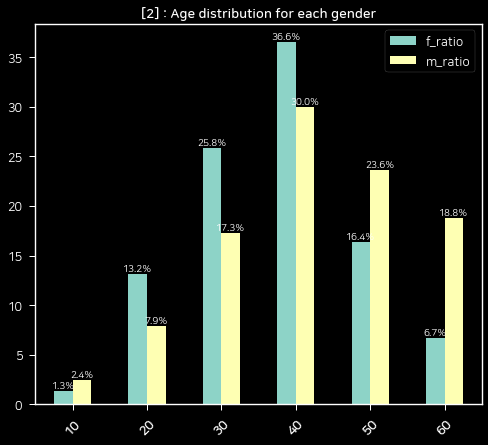

test_th


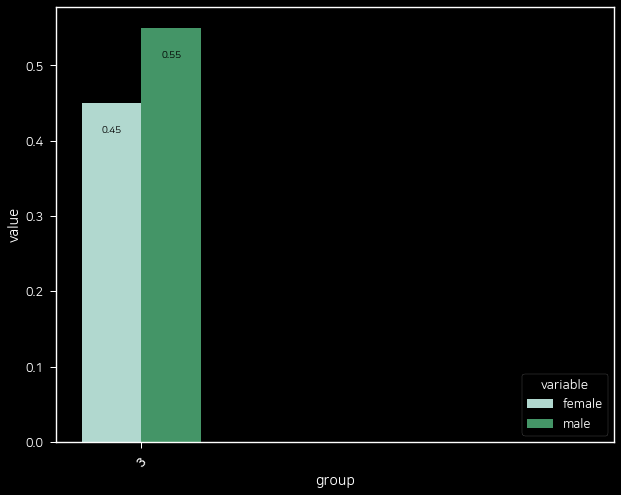

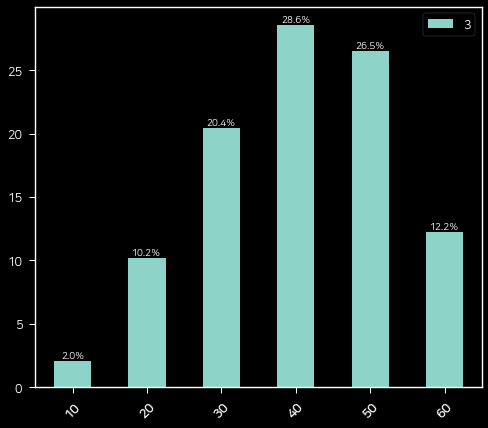

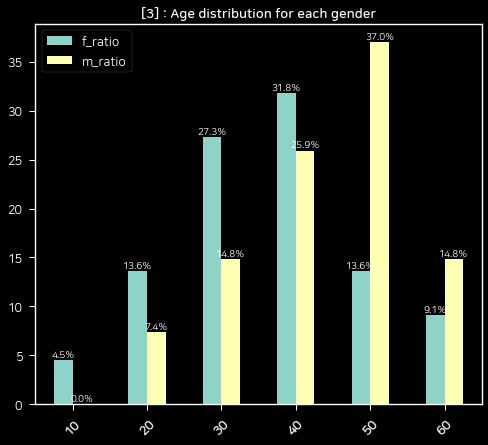

test_th


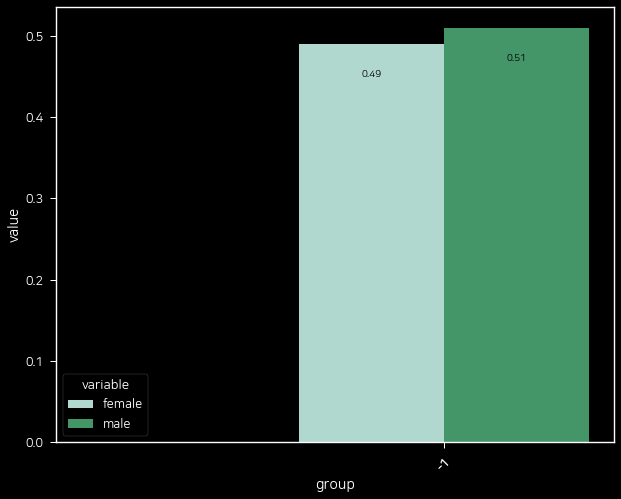

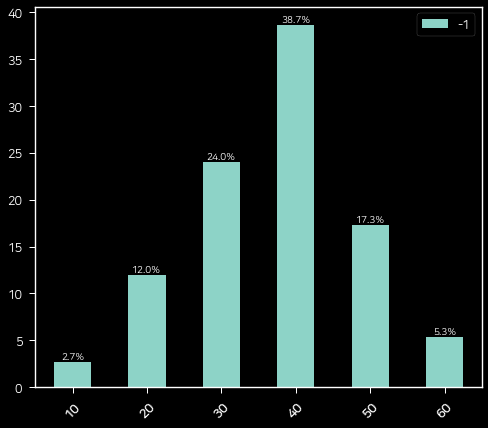

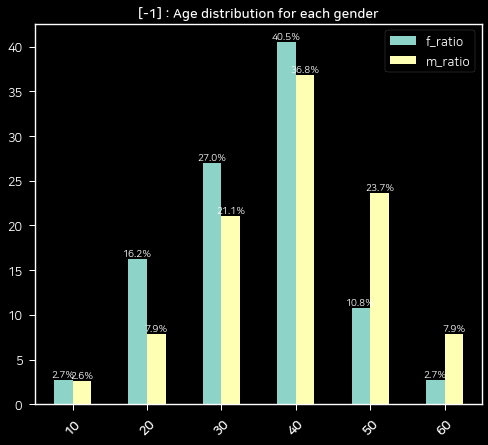

In [26]:
df_target['pred'] = pred
# dbscan segment별 성별 & 연령
dict_prop_segment = dict()
for _c in df_target['pred'].unique() :
    _lst_target = list(df_target[df_target['pred'] == _c].reset_index()[KEY_ID_DEVICE].unique())
    dict_prop_segment[_c] = dict()
    _output_prop = Profiling.demo_profiling(
        df_user_prop=df_prop.dropna(),
        KEY_ID=KEY_ID_DEVICE, 
        dict_user_list = {_c : _lst_target},
        total_avg = False)

    _df_taget_prop = _output_prop[_c]['age_gender']
    
    total_count = _df_taget_prop[['m', 'f']].sum().sum()
    gender_rate_m = round(_df_taget_prop['m'].sum() / total_count, 4)
    gender_rate_f = round(_df_taget_prop['f'].sum() / total_count, 4)
    avg_age = sum(
        [int(x) * y for x,y in zip(_df_taget_prop.index, _df_taget_prop[['m', 'f']].sum(axis =1))]
        ) / total_count

    dict_prop_segment[_c]['gender_rate_f'] = gender_rate_f
    dict_prop_segment[_c]['gender_rate_m'] = gender_rate_m
    dict_prop_segment[_c]['age'] = avg_age

In [27]:
pd.DataFrame.from_dict(dict_prop_segment, orient='index')

,gender_rate_f,gender_rate_m,age
0,0.5379,0.4621,37.743682
1,0.4788,0.5212,37.118644
2,0.5299,0.4701,39.586895
3,0.4490,0.5510,40.408163
-1,0.4933,0.5067,37.200000


test_th


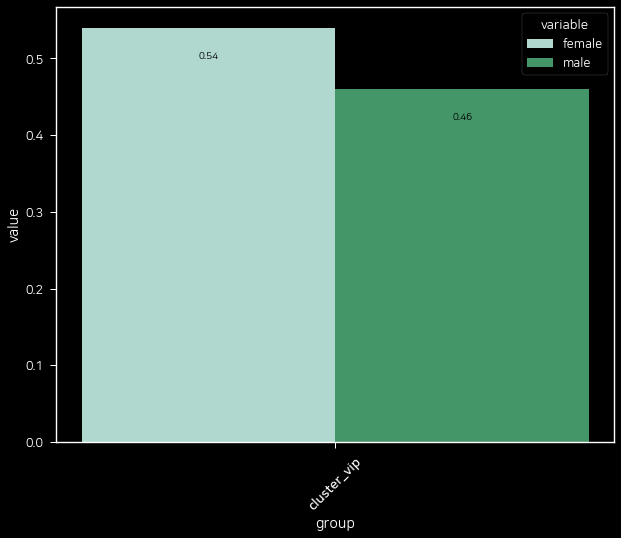

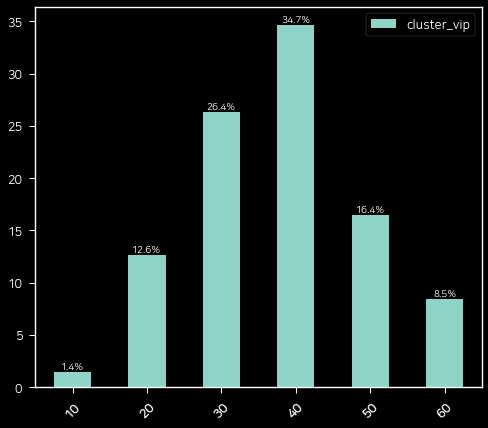

--------------------size--------------------


21969

--------------------age_gender--------------------


,m,f,m_ratio,f_ratio,cluster_vip
10,4,4,0.0156,0.0134,1.44
20,15,55,0.0586,0.1846,12.64
30,53,93,0.2070,0.3121,26.35
40,96,96,0.3750,0.3221,34.66
50,59,32,0.2305,0.1074,16.43
60,29,18,0.1133,0.0604,8.48


--------------------contents_cnt--------------------


3.6

--------------------conn_cnt--------------------


1.0

--------------------prefer_Events--------------------


,cnt,rate
sapContentDetail,11253,0.5122
sapHome,1673,0.0762
couponContent,861,0.0392
contentMain,726,0.0330
drawerMain,547,0.0249
homeSearch,540,0.0246
homeBanner,522,0.0238
contentsBanner,417,0.0190
monthForTripMain,408,0.0186
festivalMain,363,0.0165


--------------------prefer_Contents--------------------


,cnt,rate
params_sapContentName,,
가볼래-터 구독하러 가기,2063,0.0939
교통할인혜택,1831,0.0833
숙박할인혜택,1466,0.0667
여행재생목록 지도,1115,0.0508
＂디지털 관광주민증＂발급 인증하고 선물 받자!,1000,0.0455
놀거리 할인혜택,838,0.0381
나의 여행 탄소 배출량 알아보기 이벤트,748,0.0340
유휴 커피트럭 신청 이벤트,666,0.0303
2022 놀이공원 할인대전,569,0.0259


--------------------app_intsall--------------------


,app_name,cate_1,cate_2,rel_relation
0,뮤직카우,금융,금융 보조도구,0.956647
1,여행을 가볍게 노랑풍선,여행 및 지역정보,여행/투어예약,0.845024
2,제이티아이알리미,라이프스타일,기관/협회/단체포털,0.827714
3,GS THE FRESH(GS수퍼마켓),쇼핑,,0.789453
4,캠핏 CAMFIT,여행 및 지역정보,,0.728863
5,이랜드몰 - Eland mall,쇼핑,브랜드몰,0.676508
6,[공식]애터미 모바일 - ATOMY Mobile,비즈니스,기업몰/복지몰,0.675184
7,1945 비행기게임 : 슈팅게임,게임,아케이드,0.665082
8,제주안심코드,건강/운동,,0.630355
9,국민신문고,라이프스타일,기관/협회/단체포털,0.625776


,final_cdj_path,cnt,ratio
0,"[sapHome, homeBanner, sapContentDetail]",193,23.98
1,"[sapHome, homeSearch, sapContentDetail]",160,19.88
2,"[sapHome, homeTopBanner, sapContentDetail]",53,6.58
3,"[sapHome, drawerMain, sapContentDetail]",47,5.84
4,"[sapHome, drawerMain, eventlMain, eventlBanner...",42,5.22
5,"[sapHome, bottomNavi, sapContentDetail]",36,4.47
6,"[sapHome, topSearchedWords, sapContentDetail]",31,3.85
7,"[sapHome, topTravelMain, topTravelBanner, cont...",27,3.35
8,"[sapHome, drawerMain, topTravelMain, topTravel...",24,2.98
9,"[sapHome, monthForTripMain, contentsBanner, sa...",19,2.36


In [33]:
## 5) 클러스터링 VIP
AnalysisObj = KtoAnalysis(df_app_log, df_prop, df_param_contents)
# lst_target_cluster_device = df_target[df_target['pred'] == 2].index
lst_target_cluster_device = df_target[df_target['pred'] == 0].index
lst_target = lst_target_cluster_device
dict_profiling_output_target_cluster = AnalysisObj.profiling_pipe('cluster_vip', lst_target, app_pipe_obj, vis = True)
for _k in dict_profiling_output_target_cluster.keys() :
    print(f'--------------------{_k}--------------------')
    if _k in ['prefer_Events', 'prefer_Contents', 'app_intsall' ] :
        dict_profiling_output_target_cluster[_k].head(10)
    else :
        dict_profiling_output_target_cluster[_k]

## + CDJ
df_app_log_for_cdj = df_app_log[df_app_log[KEY_ID_DEVICE].isin(lst_target_cluster_device)]
cdj_target_cluster_output_impurity_03_jaccard_07, _ = CDJ_main.run_cdj(df_app_log_for_cdj, EVENT_CONTENT_DETAIL, impurity=0.3, jaccard_score=0.7)
cdj_target_cluster_output_impurity_03_jaccard_07

## 7)검색어 분석
    2안)  검색어 입력 유저의, '검색 이전' 또는 '직후' 조회 컨텐츠 탐색 (커스텀)
    : 앞선 방식보다 정확하게 검색어 직전 조회 컨텐츠를 살펴봄으로써, 대구석의 어떤 컨텐츠가 해당 검색어에 영향을 미쳤는지 살펴 볼 수 있습니다.
    step_1 :  특정 인기 검색어 입력한 유저들을 사용자 그룹으로 설정
    step_2 : 해당 유저별로, 검색이전 시점의 행동데이터를 구분하여, 검색 직전 또는 직후에 조회된 컨텐츠 파악
        EX) 음악축제

In [ ]:
def calc_query_ranking(df_param_search_recent, lst_target = None, n = 30) :
    if lst_target == None :
        df_query_ranking = df_param_search_recent['params_words'].value_counts().head(n).to_frame()
        return df_query_ranking 
    else :
        df_query_ranking = [df_param_search_recent[KEY_ID_DEVICE].isin(lst_target)]['params_words'].value_counts().head(n).to_frame()
        return df_query_ranking 

def count_dict(dict_target, x) :
    if x not in dict_target.keys() : dict_target[x] = 1
    else : dict_target[x] += 1
    return dict_target
    
def dict_to_frame(dict_target) :
    df_output = pd.DataFrame.from_dict(
        dict_target, orient = 'index'
        ).sort_values(by = 0, ascending = False).rename(columns = {0 : 'cnt'})
    df_output['rate'] = round(df_output['cnt'] / df_output['cnt'].sum(), 4)
    return df_output



def analysis_active_pattern(df_app_log_target, lst_targets, lst_titles ) :
    dict_stats_output = dict()
    lst_for_df_vis = []
    for _lst_target, title in zip(lst_targets, lst_titles) :
        dict_stats_output[title] = dict()
        ## (0) 유저수 
        size = len(_lst_target)
        # print(f'[{title}] 크기 : {size}')
        df_target = df_app_log_target[df_app_log_target[KEY_ID_DEVICE].isin(_lst_target)]

        ## (1) 사용자 대비 duration & pv
        n_event_pp = df_target.groupby(KEY_ID_DEVICE)['n_events'].sum().mean()
        duration_pp = df_target.groupby(KEY_ID_DEVICE)['duration'].sum().mean()
        # print(f'[{title}] 인당 이벤트 수(유사 PV) : {round(n_event_pp, 4)}')
        # print(f'[{title}] 인당 체류시간 : {round(duration_pp, 4)}')
        dict_stats_output[title]['크기'] = size
        dict_stats_output[title]['인당 이벤트 수(PV)'] = n_event_pp
        dict_stats_output[title]['인당 체류시간'] = duration_pp
        df_stats_output = pd.DataFrame.from_dict(dict_stats_output, orient='index')
        print('------------------------------------')

        ## (2) 사용 시간대
        _df_vis = df_target.groupby('hour').size().to_frame().add(
            pd.DataFrame.from_dict({'hour' : [ x for x in range(0, 24)],0 : [ 0 for x in range(0, 24)]}).set_index('hour'),
            fill_value=0
            ).reset_index().rename(columns = {0 : title})
        _df_vis[title] = round(_df_vis[title] / _df_vis[title].sum(), 4)
        lst_for_df_vis.append(_df_vis)
    df_vis = pd.concat(lst_for_df_vis).melt(id_vars = 'hour')
    return df_vis, df_stats_output

In [ ]:
df_app_log_recent.sort_values(by = KEY_ID_DEVICE)

In [ ]:
# # 1) df_app_log
from return_pickle import * 
search_s_date = '20221024'
search_e_date = '20221124'
CheckDate.check_date_return_pickle(s_date = search_s_date, e_date=search_e_date)
df_app_log_recent = ReadFile.read_pickle(s_date= search_s_date, e_date= search_e_date)
df_app_log_recent = SpherePrep.BasicPrep.basic_prep(df_app_log_recent, month = True)

## 2) param
### all
_, df_param_all = DataImport.json_to_dataframe_nodeN(
    df_app_log_recent, [KEY_ID_DEVICE, KEY_ID_USER], 
    )
df_param_all['date'] = pd.to_datetime(df_param_all['date'], format='%Y%m%d %H:%M:%S')
df_param_all['params_words'] = df_param_all['params_words'].apply(lambda x : x.replace(' ', '') if isinstance(x, str) else x)
### search
df_param_search_recent = DataImport.extract_event_param(df_param_all, EVENT_SEARCH).drop_duplicates()
df_param_search_recent = df_param_search_recent[~df_param_search_recent['params_words'].isna()]
df_param_search_recent['params_words'] = df_param_search_recent['params_words'].apply(lambda x : x.replace(' ', ''))
df_param_search_recent = df_param_search_recent[
    (df_param_search_recent['date'] <= datetime(2022, 11, 24)) &
    (df_param_search_recent['date'] >= datetime(2022, 11, 24) - timedelta(days = 28))
    ]

## 3) "session" referr -- web 유입
lst_extrated_referr_cols = ['utm_campaign', 'utm_source', 'utm_medium']
df_app_log_recent = SpherePrep.Attribution_Prep.gen_session_referr_cols(
    df_app_log_recent, referr_col = 'referrer', 
    lst_extrated_referr_cols = lst_extrated_referr_cols,
    fill_na_organic = True
    )

In [ ]:
## 3) 검색어 확인
### (1) 주요 분석 검색어 확인
df_param_search_recent_2 = df_param_search_recent[
    (df_param_search_recent['date'] <= datetime(2022, 11, 24)) &
    (df_param_search_recent['date'] >= datetime(2022, 11, 24) - timedelta(days = 14))
    ]
df_param_search_recent_2.day.min(), df_param_search_recent_2.day.max()
df_query_ranking = calc_query_ranking(df_param_search_recent_2, n = 100)
df_query_ranking.head(25)
lst_music_festival_query = ['음악축제', '음악']
lst_music_festival_query = ['음악축제', '서울국악축제', '정선아리랑제','전주세계소리축제', '안동국제탈춤페스티벌', '밀양아리랑대축제', '영동난계국악축제']
### (2) 주요 분석 검색어의, 일별 추이 확인
df_vis = df_param_search_recent[
    df_param_search_recent['params_words'].isin(lst_music_festival_query)
].groupby(['day', 'params_words'])[KEY_ID_DEVICE].count().to_frame().reset_index()
SphereVis.vis_line_longform(longform_data=df_vis, x = 'day', y = KEY_ID_DEVICE, hue = 'params_words')

## 4) 분석 대상 추출 --> 최근 검색 유저로 한정
df_param_all_recent = df_param_all[
    (df_param_all['date'] >= datetime(2022,11,13))
    ]
lst_search_device = df_param_search_recent[
    (df_param_search_recent['params_words'].isin(lst_music_festival_query)) &
    (df_param_search_recent['date'] >= datetime(2022,11,13))
    ][KEY_ID_DEVICE].unique()
print(f'target search device count : {len(lst_search_device)}')

In [ ]:
# 가설_2 : 동일 IP에 물려 있는 키값 확인
lst_same_ip_ids = []
## 1) ip 컬럼 생성
df_app_log_recent['ip'] = df_app_log_recent['session'].apply(lambda x : x['ip'])
df_app_log_recent_search = df_app_log_recent[df_app_log_recent[KEY_ID_DEVICE].isin(lst_search_device)]
## 2) 가장 많은 아이디가 물려 있는 IP 확인
df_id_ip = df_app_log_recent_search[[KEY_ID_DEVICE, 'ip']].drop_duplicates()
df_id_ip_rank = df_id_ip.groupby('ip').size().sort_values(ascending = False)
## 3) 동일 IP 유저의들의 검색어 및 컨텐츠 확인
dict_ip_cnt = dict()
for _most_ip in df_id_ip_rank.index[:20] : 
    _lst_same_ip_ids = df_id_ip[df_id_ip['ip'] == _most_ip][KEY_ID_DEVICE].unique()
    lst_same_ip_ids += list(_lst_same_ip_ids)
    df_param_all_same_ip = df_param_all_recent[df_param_all_recent[KEY_ID_DEVICE].isin(_lst_same_ip_ids)]
    dict_ip_cnt[_most_ip] = len(_lst_same_ip_ids)
    print('------------', _most_ip, '동일 IP 기기수 :', len(_lst_same_ip_ids), '------------')
    # df_param_all_same_ip[PARAM_CONTENT_NAME].value_counts().to_frame().head()
    # df_param_all_same_ip['params_words'].value_counts().to_frame().head()

pd.DataFrame.from_dict(dict_ip_cnt, orient = 'index')

## 4) 전체 검색어 순위에서, 동일 IP 유저들의 검색어가 차지하는 비중 확인
calc_query_ranking(df_param_search_recent_2, n = 10)
len(lst_search_device)
len(lst_same_ip_ids)
calc_query_ranking(df_param_search_recent_2[df_param_search_recent_2[KEY_ID_DEVICE].isin(lst_same_ip_ids)], n = 10)

In [ ]:
# 가설_3 : 사용 시간 패턴을 기준으로 이상 유저 탐색
## prep
df_app_log_recent['hour'] = pd.to_datetime(df_app_log_recent['date'], format='%Y%m%d %H:%M:%S').dt.hour
df_app_log_recent['n_events'] = df_app_log_recent['abs_events'].apply(lambda x : len(x))

## segment setting
lst_search_device_target = lst_search_device.copy()
lst_search_device_all, _ = BasicSegment.gen_event_boolen_user_lst(df_target = df_app_log_recent, key_id=KEY_ID_DEVICE, target_property_event = EVENT_SEARCH)
lst_search_device_others = list(set(lst_search_device_all) - set(lst_search_device))

In [ ]:
# (1) 
lst_targets = [lst_search_device, lst_search_device_others]
lst_titles = ['음악축제 관련 키워드 검색 유저', '이외 키워드 검색 유저']

df_vis_1, df_stats_output_1 = analysis_active_pattern(df_app_log_recent, lst_targets, lst_titles )
df_stats_output_1
## plt_1
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(12,6))
_ = sns.lineplot(
    data = df_vis_1[df_vis_1['variable'] == '음악축제 관련 키워드 검색 유저'], 
    x= 'hour', y = 'value', alpha=0.8, ax=ax1, color = 'r')
_ = plt.ylabel('음악축제 관련 키워드 검색 유저', color = 'r')
## plt_2
ax2 = ax1.twinx()
_ = sns.lineplot(
    data = df_vis_1[df_vis_1['variable'] == '이외 키워드 검색 유저'], 
    x= 'hour', y = 'value',  alpha=0.8, color = 'b', ax=ax2)
_ = plt.ylabel('이외 키워드 검색 유저', color = 'b')
_ = plt.title(' vs '.join(lst_titles) )
_ = plt.xticks([x for x in range(0, 24)])

In [ ]:
lst_targets = [lst_same_ip_ids, list(set(lst_search_device) - set(lst_same_ip_ids))]
lst_titles = ['음악축제 검색 유저중, 동일 IP 유저', '음악축제 검색 유저중, 서로 다른 IP 유저']

df_vis_1, df_stats_output_2 = analysis_active_pattern(df_app_log_recent, lst_targets, lst_titles )
df_stats_output_2
## plt_1
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(12,6))
_ = sns.lineplot(
    data = df_vis_1[df_vis_1['variable'] == lst_titles[0]], 
    x= 'hour', y = 'value', alpha=0.8, ax=ax1, color = 'r')
_ = plt.ylabel(lst_titles[0], color = 'r')
## plt_2
ax2 = ax1.twinx()
_ = sns.lineplot(
    data = df_vis_1[df_vis_1['variable'] == lst_titles[1]], 
    x= 'hour', y = 'value',  alpha=0.8, color = 'b', ax=ax2)
_ = plt.ylabel(lst_titles[1], color = 'b')
_ = plt.title(' vs '.join(lst_titles) )
_ = plt.xticks([x for x in range(0, 24)])

In [ ]:
# 1. 가설_1 : 검색 유저 행동
dict_separate_type = {
    '단순 외부 유입' : [],
    '사전 연관 키워드 검색' : [],
    '사전 연관 컨텐츠 조회' : [],
    '기타' : []
    } 

dict_before_search = dict() 
dict_before_contents = dict() 
dict_before_etc_events = dict() 

lst_contents_banner_events = [EVENT_CONTENT_DETAIL] #, EVENT_HOME_BANNER, EVENT_HOME_TOP_BANNER]
lst_search_events = [EVENT_SEARCH] #, 'topSearchedWords']
## 1) 해당 검색 유저의 직전 행동
for _key_device in list(set(lst_search_device) - set(lst_same_ip_ids)) :
    ### (1) 타겟 유저의 행동 모두 탐색
    _df_param_target = df_param_all_recent[
        (df_param_all_recent[KEY_ID_DEVICE] == _key_device) &
        (df_param_all_recent['name'] != 'sapHome')
        ].reset_index()
    
    ### (2) feature selection
    _df_param_target = _df_param_target[['day', 'date', KEY_ID_DEVICE, 'name', PARAM_CONTENT_NAME, 'params_words']]
    
    ### (3) find before events
    #### find first index of search target query 
    first_search_events_index = _df_param_target[
        (_df_param_target['name'] == EVENT_SEARCH) &
        (_df_param_target['params_words'].isin(lst_music_festival_query))
        ].index[0]
    #### get before data 
    _df_param_target_before = _df_param_target[:first_search_events_index]


    ### (4) separate type
    _lst_target_events = list(_df_param_target_before['name'].unique())
    #### (a) external reason : 사전 행동 없이, 쿼리 검색
    if len(_lst_target_events) == 0 :
        dict_separate_type['단순 외부 유입'].append(_key_device) 
    
    #### (b) relevent query : 연관 검색어
    elif set(_lst_target_events) & set(lst_search_events) : 
        dict_separate_type['사전 연관 키워드 검색'].append(_key_device) 
        for _words in _df_param_target_before[_df_param_target_before['name'].isin(lst_search_events)]['params_words'] : 
            if isinstance(_words, str) :
                dict_before_search = count_dict(dict_before_search, _words)
        
    #### (c) relevent contents or banner : 연관 컨텐츠 또는 배너
    elif set(_lst_target_events) & set(lst_contents_banner_events) : 
        dict_separate_type['사전 연관 컨텐츠 조회'].append(_key_device) 
        for _contents_nm in _df_param_target_before[_df_param_target_before['name'].isin(lst_contents_banner_events)][PARAM_CONTENT_NAME] : 
            if isinstance(_contents_nm, str) :
                dict_before_contents = count_dict(dict_before_contents, _contents_nm)
        
    else : 
        dict_separate_type['기타'].append(_key_device) 
        for _event in _df_param_target_before['name'] : 
            dict_before_etc_events = count_dict(dict_before_etc_events, _event)

# # print('result : ')

In [ ]:
dict_to_frame({_k : len(dict_separate_type[_k]) for _k in dict_separate_type.keys()})
dict_to_frame(dict_before_search).head(20)
dict_to_frame(dict_before_contents).head(20)
dict_to_frame(dict_before_etc_events).head()


# 컨텐츠 메인 -> 축제 선택 비중
((~df_param_all_recent[KEY_ID_DEVICE].isin(lst_search_device)) & (df_param_all_recent['name'] ==  'contentMain') ).sum() / (~df_param_all_recent[KEY_ID_DEVICE].isin(lst_search_device)).sum()
df_tmp = df_param_all_recent[
    (~df_param_all_recent[KEY_ID_DEVICE].isin(lst_search_device)) &
    (df_param_all_recent['name'] ==  'contentMain') 
    ]
round(df_tmp.groupby('params_sapContentCat1Name').size() / len(df_tmp), 4)


((df_param_all_recent[KEY_ID_DEVICE].isin(lst_search_device)) & (df_param_all_recent['name'] ==  'contentMain') ).sum() / (df_param_all_recent[KEY_ID_DEVICE].isin(lst_search_device)).sum()
df_tmp = df_param_all_recent[
    (df_param_all_recent[KEY_ID_DEVICE].isin(lst_search_device)) &
    (df_param_all_recent['name'] ==  'contentMain') 
    ]
round(df_tmp.groupby('params_sapContentCat1Name').size() / len(df_tmp), 4)


In [ ]:
lst_targets = dict_separate_type.values()
lst_titles = dict_separate_type.keys()
df_vis_2, df_stats_output_3 = analysis_active_pattern(df_app_log_recent, lst_targets, lst_titles )
round(df_stats_output_3,2)
## plt_1
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(12,6))
_ = sns.lineplot(
    data = df_vis_2, 
    x= 'hour', y = 'value', hue = 'variable')

## plt_2
ax2 = ax1.twinx()
_ = sns.lineplot(
    data = df_vis_1[df_vis_1['variable'] == '이외 키워드 검색 유저'], 
    x= 'hour', y = 'value',  alpha=0.8, color = 'b', ax=ax2)
_ = plt.ylabel('이외 키워드 검색 유저', color = 'b')
# _ = plt.title(' vs '.join(lst_titles) )
_ = plt.xticks([x for x in range(0, 24)])